In [19]:
!pip install CBFV

In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from CBFV.composition import generate_features


## Load the pre-processed dataset

We will start with the processed dataset that we saved from the last notebook.

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/jupyter/2D/data/C2DB_TDSL_class.csv')

df

Formula  Thermodynamic stability level
0           Ag2                            1.0
1     Ag2Au2Cl8                            3.0
2        Ag2Br2                            3.0
3      Ag2Br2N2                            1.0
4      Ag2Br2O2                            1.0
...         ...                            ...
2809      ZrSTe                            3.0
2810      ZrSb2                            2.0
2811      ZrSe2                            3.0
2812     ZrSeTe                            3.0
2813      ZrTe2                            3.0

[2814 rows x 2 columns]

## Generate features using the `CBFV` package

To featurize the chemical compositions from a chemical formula (e.g. "Al2O3") into a composition-based feature vector (CBFV), we use the open-source [`CBFV` package](https://github.com/kaaiian/CBFV).

The `generate_features` function from the CBFV package expects an input DataFrame containing at least the columns `['formula', 'target']`. You may also have extra feature columns (e.g., `temperature` or `pressure`, other measurement conditions, etc.).

Since the `generate_features` function expects the target variable column to be named `target`, we have to rename 


In [23]:
rename_dict = {'Formula': 'formula', list(df.columns)[1]: 'target'}
df = df.rename(columns=rename_dict)
df.head()

formula  target
0        Ag2     1.0
1  Ag2Au2Cl8     3.0
2     Ag2Br2     3.0
3   Ag2Br2N2     1.0
4   Ag2Br2O2     1.0

Now we can use the `generate_features` function to generate the CBFVs from the input data.

Note that we have specified several keyword arguments in our call to `generate_features`:
* `elem_prop='oliynyk'`
* `drop_duplicates=False`
* `extend_features=True`
* `sum_feat=True`

A short explanation for the choice of keyword arguments is below:
* The `elem_prop` parameter specifies which CBFV featurization scheme to use (there are several). For this tutorial, we have chosen to use the `oliynyk` CBFV featurization scheme.
* The `drop_duplicates` parameter specifies whether to drop duplicate formulae during featurization.
* The `extend_features` parameter specifies whether to include extended features (features that are not part of `['formula', 'target']`) in the featurized data.
* The `sum_feat` parameter specifies whether to calculate the sum features when generating the CBFVs for the chemical formulae. We do in our case (`True`).


In [24]:
from time import time

from sklearn.dummy import DummyClassifier

from sklearn.linear_model import RidgeClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def instantiate_model(model_name):
    model = model_name()
    return model

def fit_model(model, X_train, y_train):
    ti = time()
    model = instantiate_model(model)
    model.fit(X_train, y_train)
    fit_time = time() - ti
    return model, fit_time

def evaluate_model(model, X, y_act):
    y_pred = model.predict(X)
    r2 = r2_score(y_act, y_pred)
    mae = mean_absolute_error(y_act, y_pred)
    rmse_val = mean_squared_error(y_act, y_pred, squared=False)
    return r2, mae, rmse_val

def fit_evaluate_model(model, model_name, X_train, y_train, X_val, y_act_val):
    model, fit_time = fit_model(model, X_train, y_train)
    r2_train, mae_train, rmse_train = evaluate_model(model, X_train, y_train)
    r2_val, mae_val, rmse_val = evaluate_model(model, X_val, y_act_val)
    result_dict = {
        'model_name': model_name,
        'model_name_pretty': type(model).__name__,
        'model_params': model.get_params(),
        'fit_time': fit_time,
        'r2_train': r2_train,
        'mae_train': mae_train,
        'rmse_train': rmse_train,
        'r2_val': r2_val,
        'mae_val': mae_val,
        'rmse_val': rmse_val}
    return model, result_dict

def append_result_df(df, result_dict):
    df_result_appended = df.append(result_dict, ignore_index=True)
    return df_result_appended

def append_model_dict(dic, model_name, model):
    dic[model_name] = model
    return dic

def plot_pred_act(f, act, pred, model, reg_line=True, label=''):
    xy_max = np.max([np.max(act), np.max(pred)])

    plot = plt.figure(figsize=(6,6))
    plt.plot(act, pred, 'o', ms=9, mec='k', mfc='silver', alpha=0.4)
    plt.plot([0, xy_max], [0, xy_max], 'k--', label='ideal')
    if reg_line:
        polyfit = np.polyfit(act, pred, deg=1)
        reg_ys = np.poly1d(polyfit)(np.unique(act))
        plt.plot(np.unique(act), reg_ys, alpha=0.8, label='linear fit')
    plt.axis('scaled')
    plt.xlabel(f'Actual {label}')
    plt.ylabel(f'Predicted {label}')
    plt.title(f'{f}:{type(model).__name__}, r2: {r2_score(act, pred):0.4f}')
    plt.legend(loc='upper left')
    
    return plot

In [25]:
df_classics = pd.DataFrame(columns=['model_name',
                                  'model_name_pretty',
                                  'model_params',
                                  'fit_time',
                                  'r2_train',
                                  'mae_train',
                                  'rmse_train',
                                  'r2_val',
                                  'mae_val',
                                  'rmse_val'])
# df_classics

# Build a dictionary of model names
classic_model_names = OrderedDict({
    'dumr': DummyClassifier,
    'rr': RidgeClassifier,
    'abr': AdaBoostClassifier,
    'gbr': GradientBoostingClassifier,
    'rfr': RandomForestClassifier,
    'etr': ExtraTreesClassifier,
    'svr': SVC,
    'lsvr': LinearSVC,
    'knr': KNeighborsClassifier,
})

Processing Input Data: 100%|██████████| 2814/2814 [00:00<00:00, 18141.62it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 2814/2814 [00:00<00:00, 6468.20it/s]


	Creating Pandas Objects...
Now fitting and evaluating model dumr: DummyClassifier
Now fitting and evaluating model rr: RidgeClassifier
Now fitting and evaluating model abr: AdaBoostClassifier
Now fitting and evaluating model gbr: GradientBoostingClassifier
Now fitting and evaluating model rfr: RandomForestClassifier
Now fitting and evaluating model etr: ExtraTreesClassifier
Now fitting and evaluating model svr: SVC
Now fitting and evaluating model lsvr: LinearSVC


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Now fitting and evaluating model knr: KNeighborsClassifier
Finished fitting 9 models, total time: 388.00 s


Processing Input Data: 100%|██████████| 2814/2814 [00:00<00:00, 11590.33it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 2814/2814 [00:00<00:00, 9603.46it/s]


	Creating Pandas Objects...
Now fitting and evaluating model dumr: DummyClassifier
Now fitting and evaluating model rr: RidgeClassifier
Now fitting and evaluating model abr: AdaBoostClassifier
Now fitting and evaluating model gbr: GradientBoostingClassifier
Now fitting and evaluating model rfr: RandomForestClassifier
Now fitting and evaluating model etr: ExtraTreesClassifier
Now fitting and evaluating model svr: SVC
Now fitting and evaluating model lsvr: LinearSVC


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Now fitting and evaluating model knr: KNeighborsClassifier
Finished fitting 9 models, total time: 13.34 s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

	Featurizing Compositions...


Assigning Features...: 100%|██████████| 2814/2814 [00:00<00:00, 7430.70it/s]


	Creating Pandas Objects...
Now fitting and evaluating model dumr: DummyClassifier
Now fitting and evaluating model rr: RidgeClassifier
Now fitting and evaluating model abr: AdaBoostClassifier
Now fitting and evaluating model gbr: GradientBoostingClassifier
Now fitting and evaluating model rfr: RandomForestClassifier
Now fitting and evaluating model etr: ExtraTreesClassifier
Now fitting and evaluating model svr: SVC
Now fitting and evaluating model lsvr: LinearSVC


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Now fitting and evaluating model knr: KNeighborsClassifier
Finished fitting 9 models, total time: 182.49 s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

	Featurizing Compositions...


Assigning Features...: 100%|██████████| 2814/2814 [00:00<00:00, 8414.20it/s]


	Creating Pandas Objects...
Now fitting and evaluating model dumr: DummyClassifier
Now fitting and evaluating model rr: RidgeClassifier
Now fitting and evaluating model abr: AdaBoostClassifier
Now fitting and evaluating model gbr: GradientBoostingClassifier
Now fitting and evaluating model rfr: RandomForestClassifier
Now fitting and evaluating model etr: ExtraTreesClassifier
Now fitting and evaluating model svr: SVC
Now fitting and evaluating model lsvr: LinearSVC


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Now fitting and evaluating model knr: KNeighborsClassifier
Finished fitting 9 models, total time: 28.30 s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

	Featurizing Compositions...


Assigning Features...: 100%|██████████| 2814/2814 [00:00<00:00, 8188.02it/s]


	Creating Pandas Objects...
Now fitting and evaluating model dumr: DummyClassifier
Now fitting and evaluating model rr: RidgeClassifier
Now fitting and evaluating model abr: AdaBoostClassifier
Now fitting and evaluating model gbr: GradientBoostingClassifier
Now fitting and evaluating model rfr: RandomForestClassifier
Now fitting and evaluating model etr: ExtraTreesClassifier
Now fitting and evaluating model svr: SVC
Now fitting and evaluating model lsvr: LinearSVC


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Now fitting and evaluating model knr: KNeighborsClassifier
Finished fitting 9 models, total time: 181.34 s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

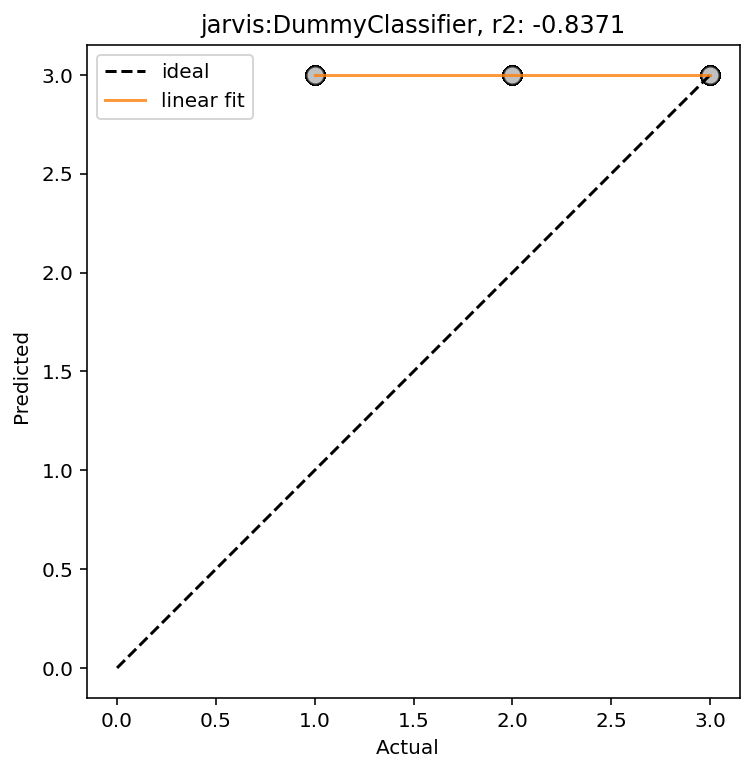

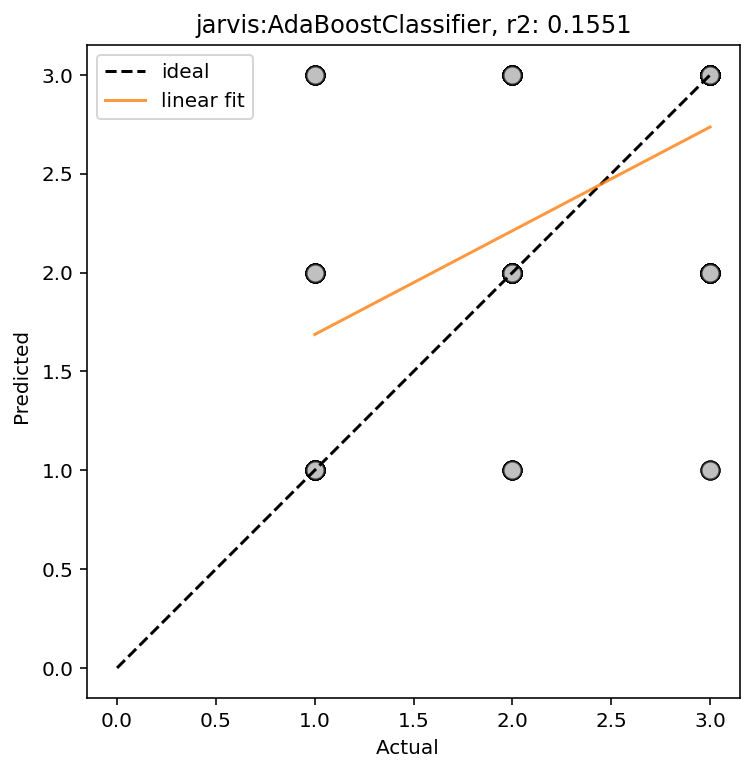

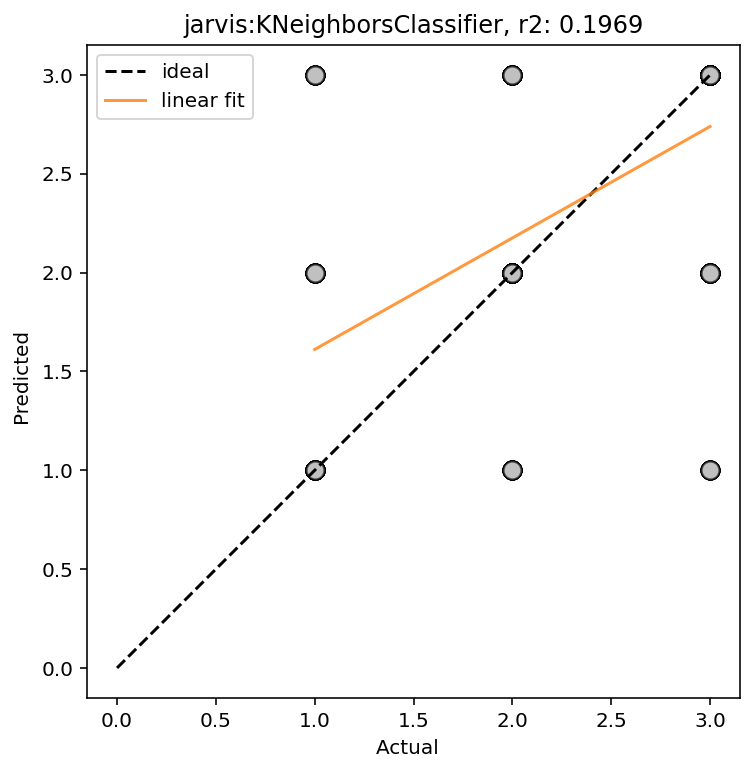

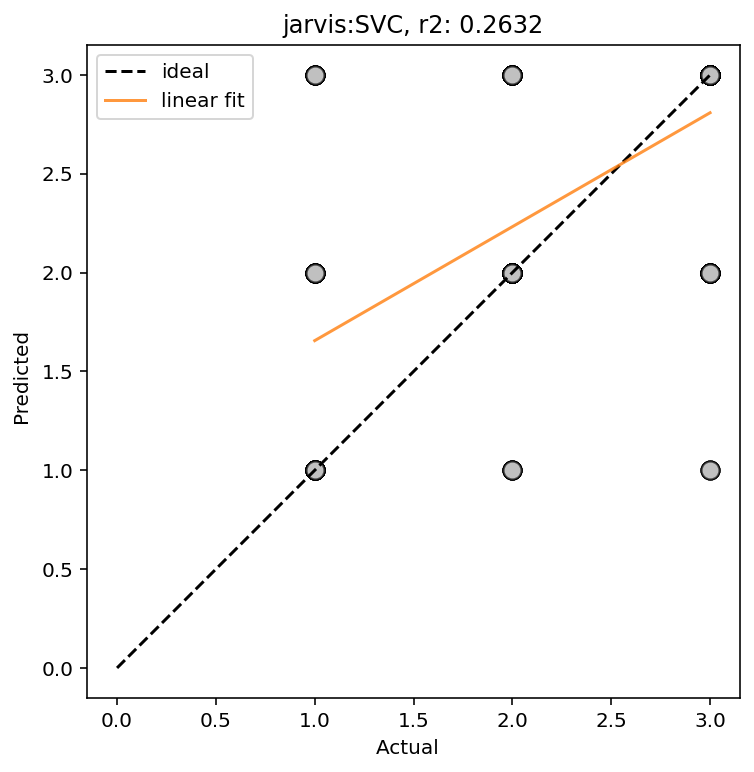

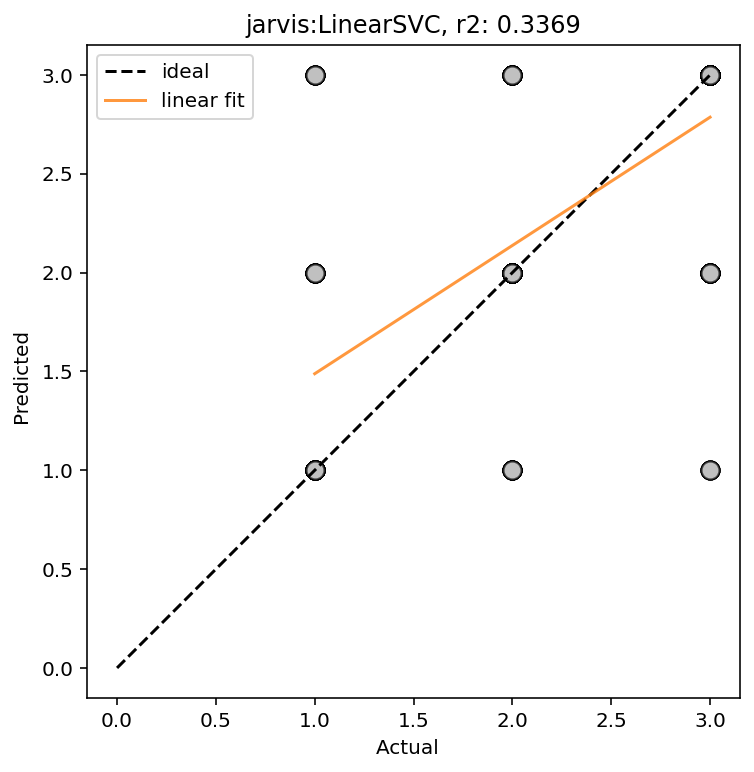

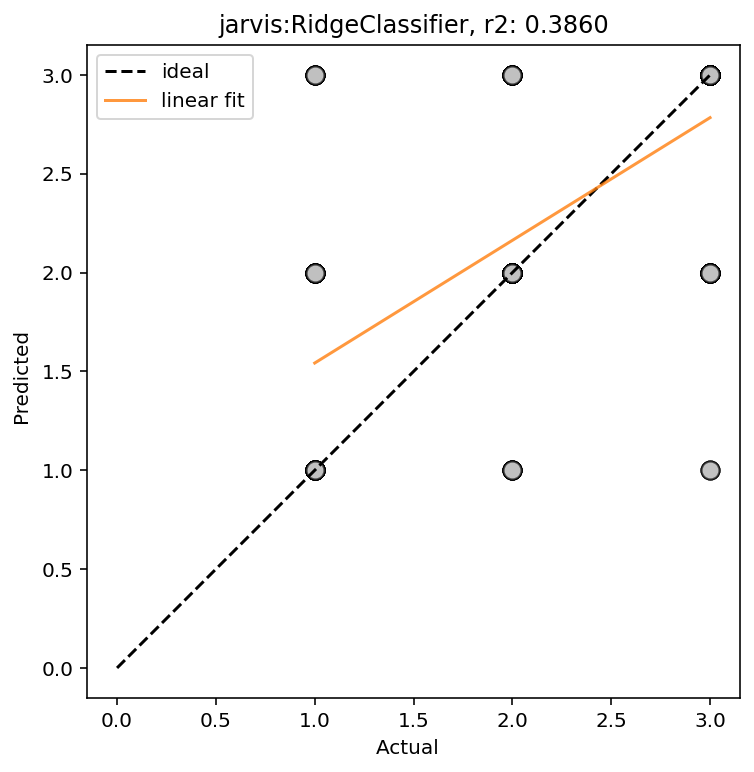

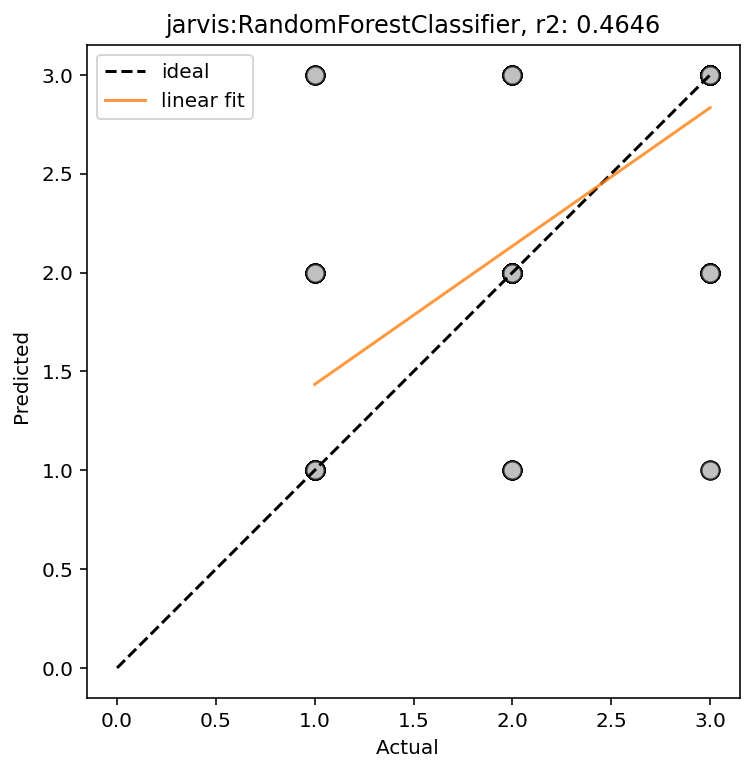

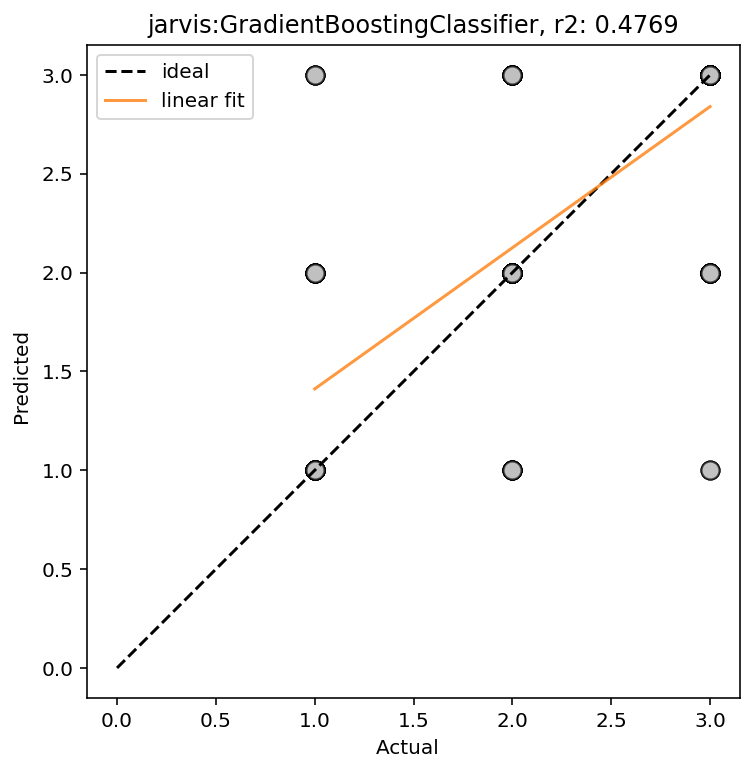

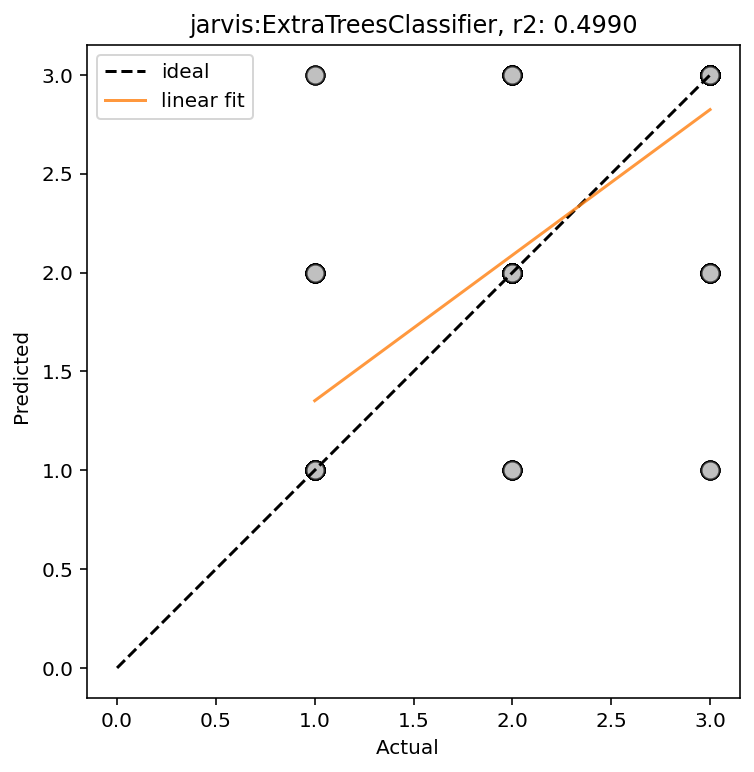

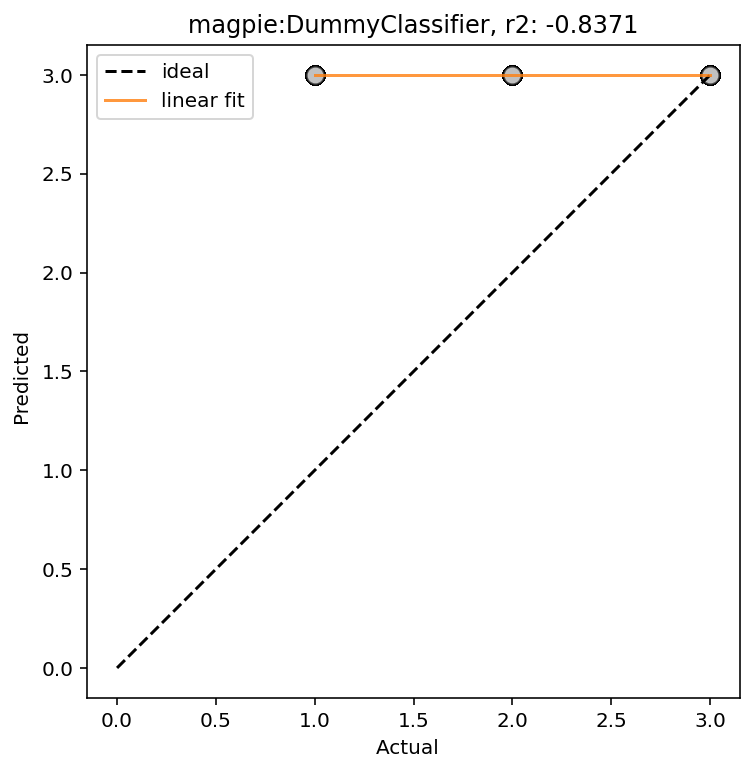

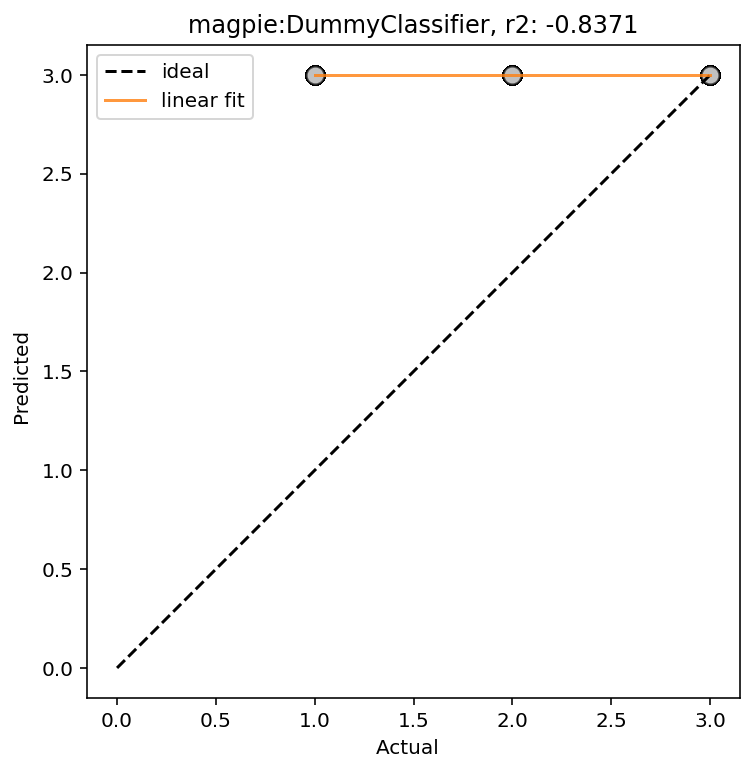

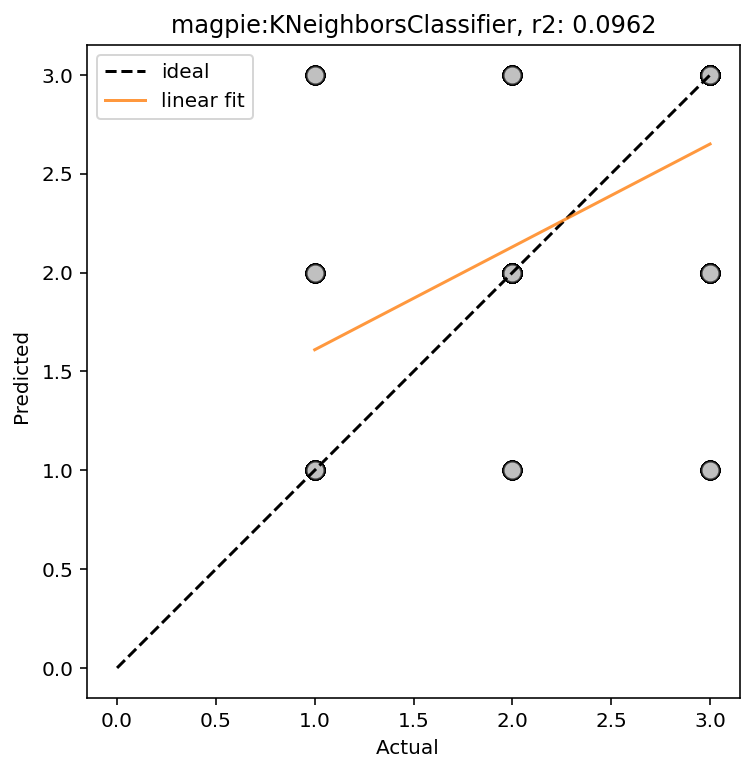

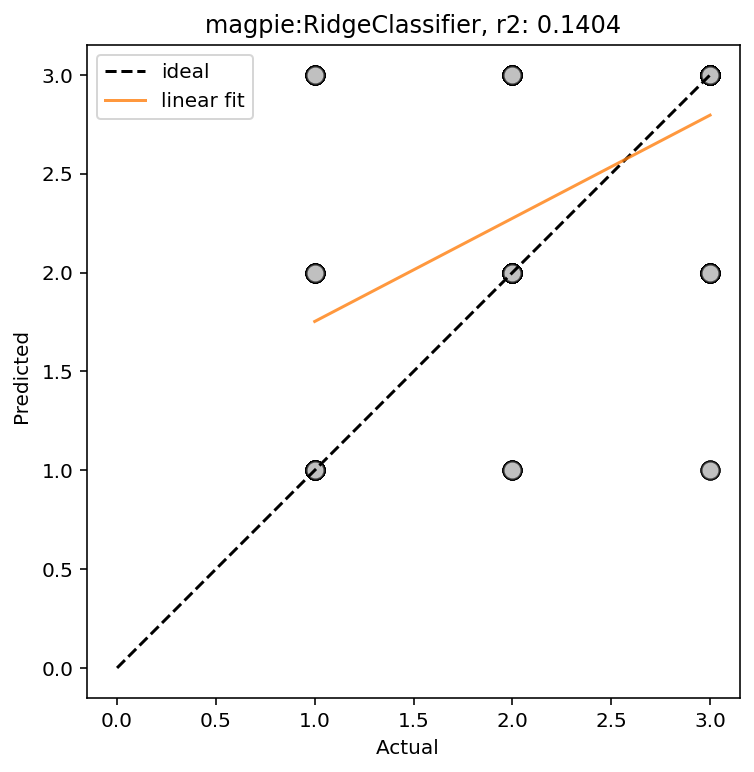

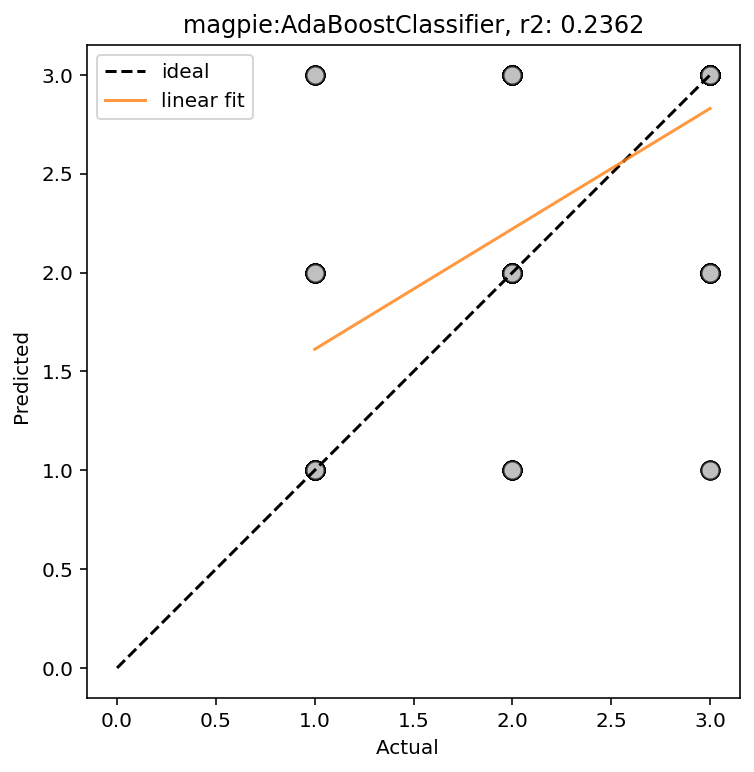

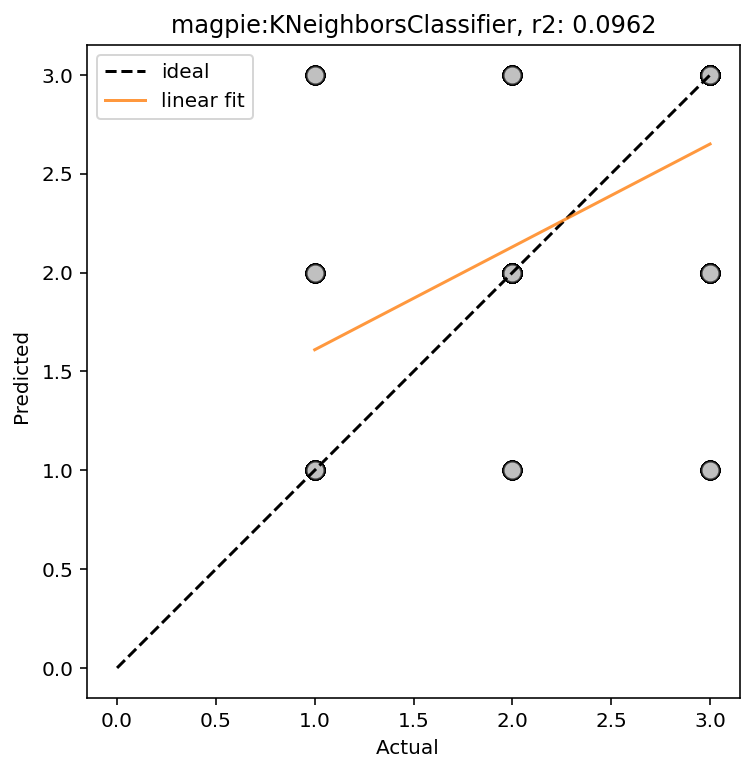

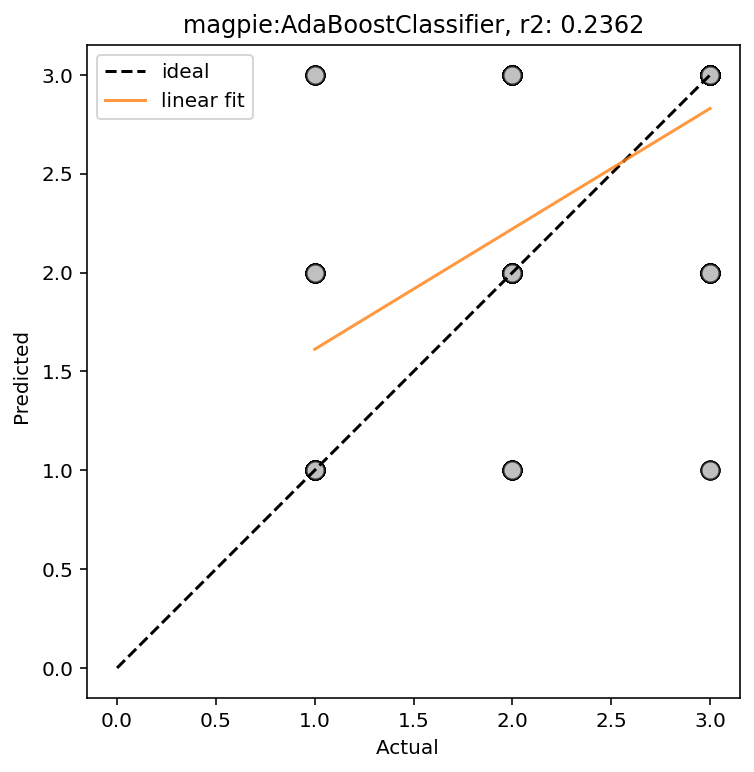

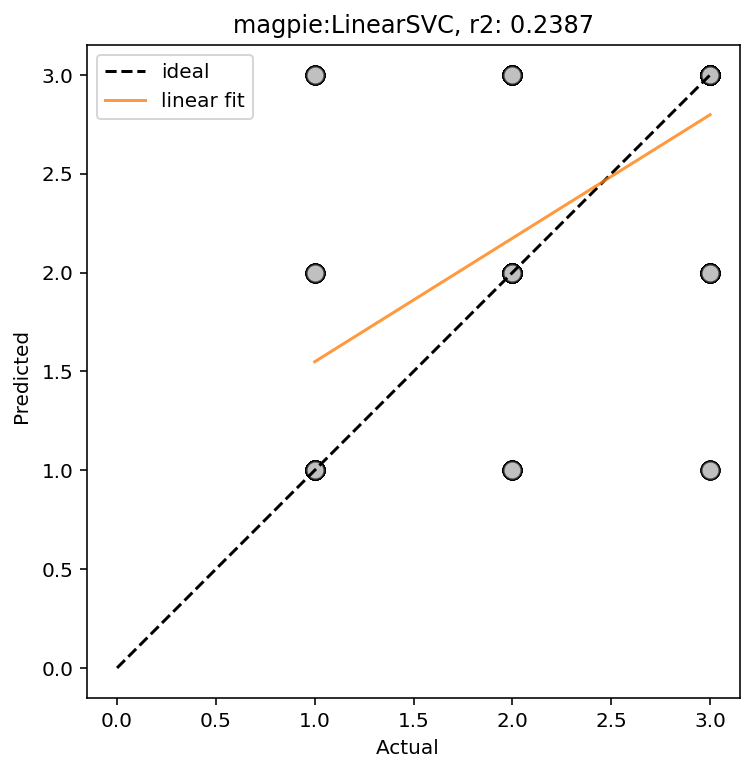

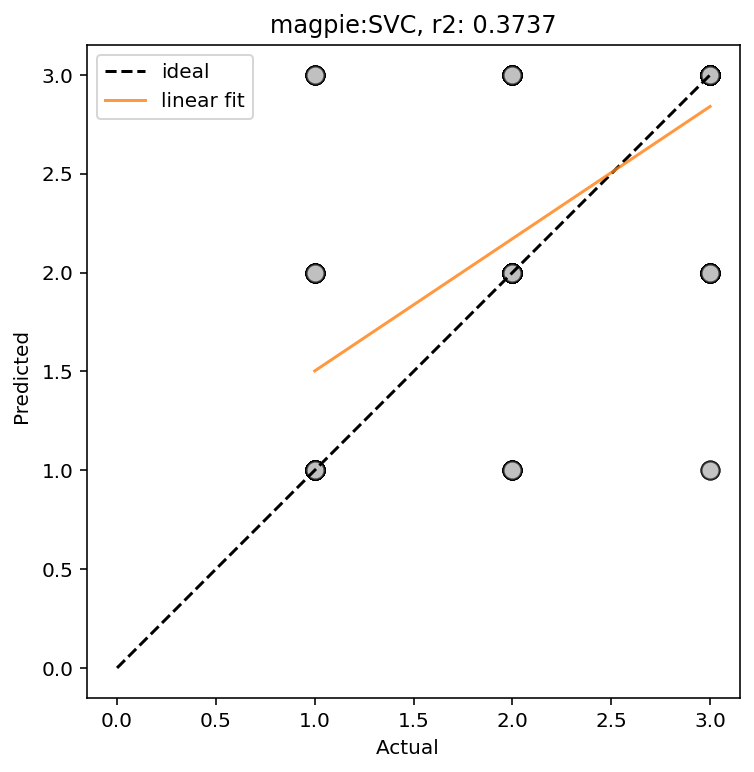

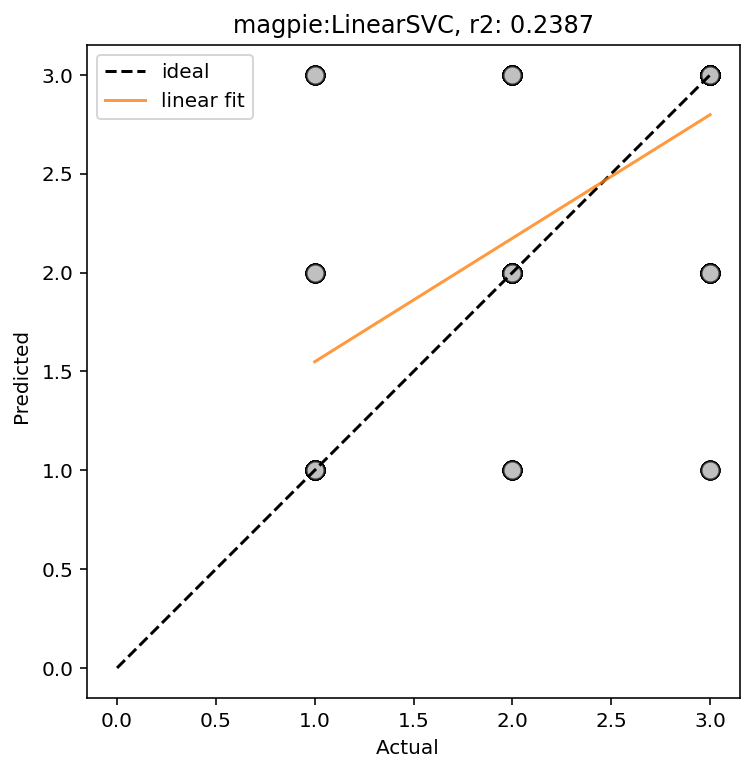

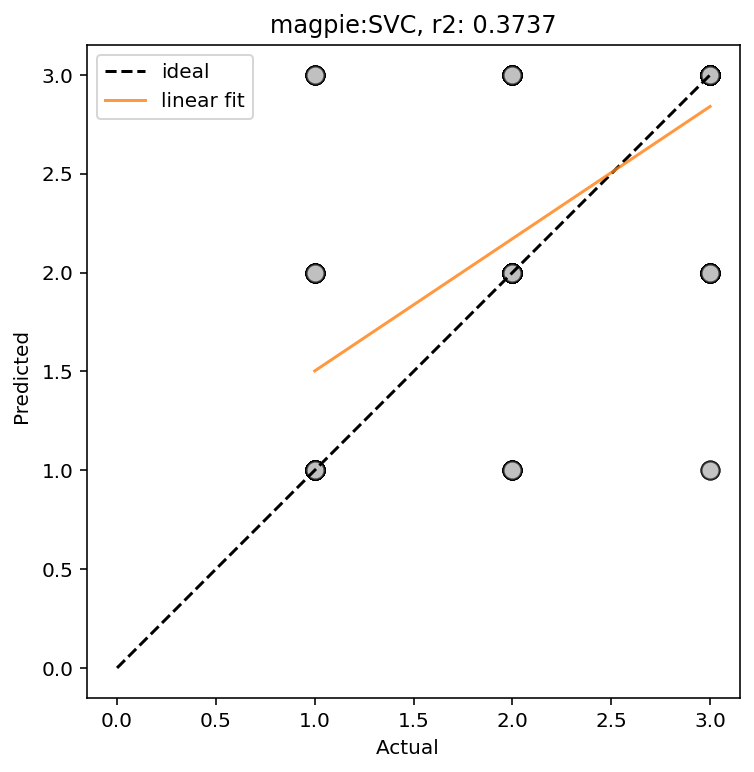

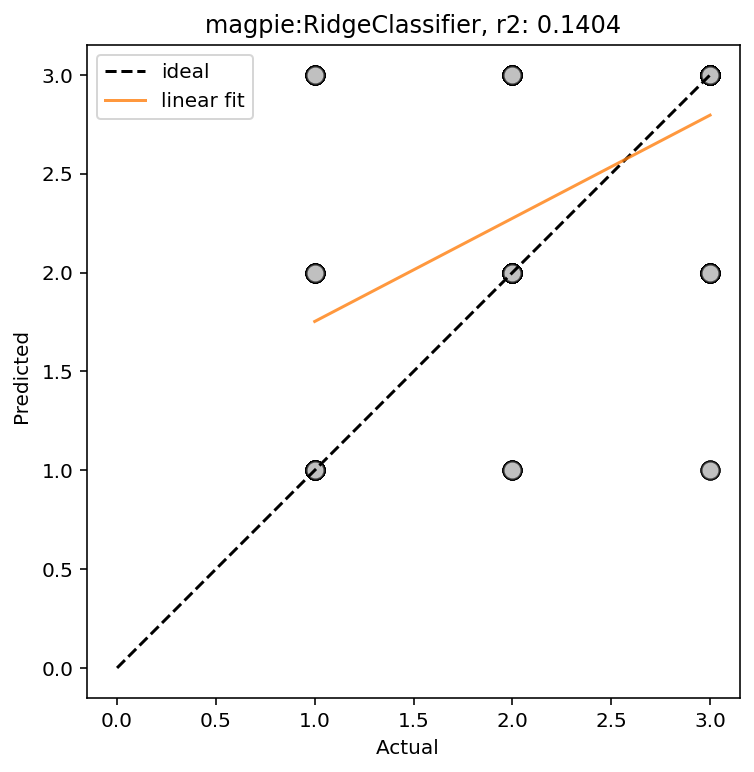

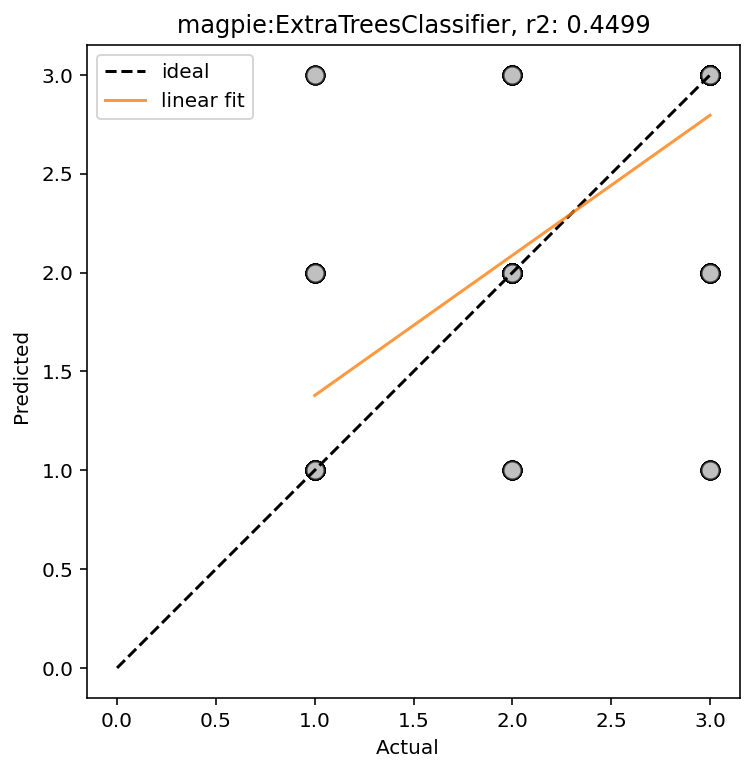

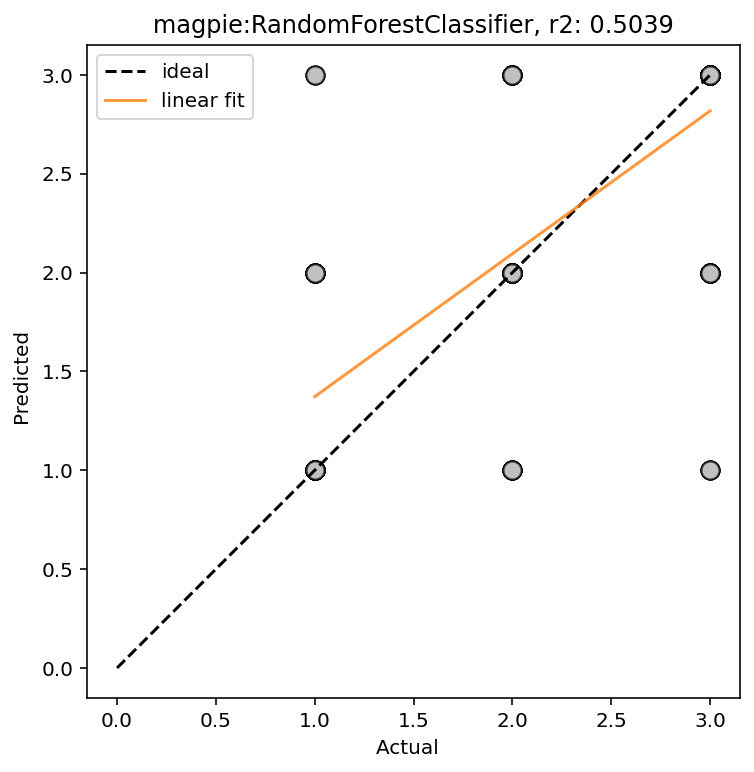

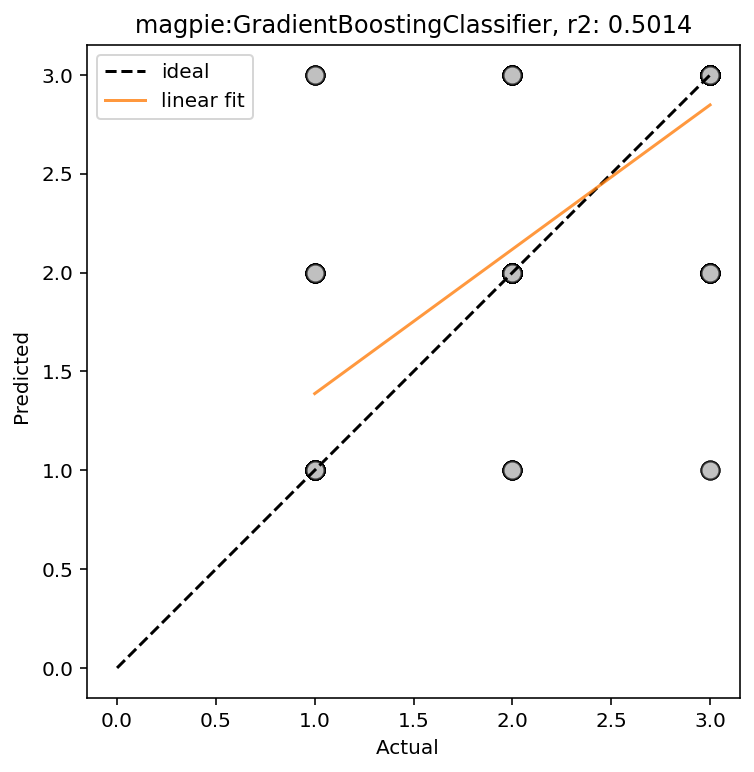

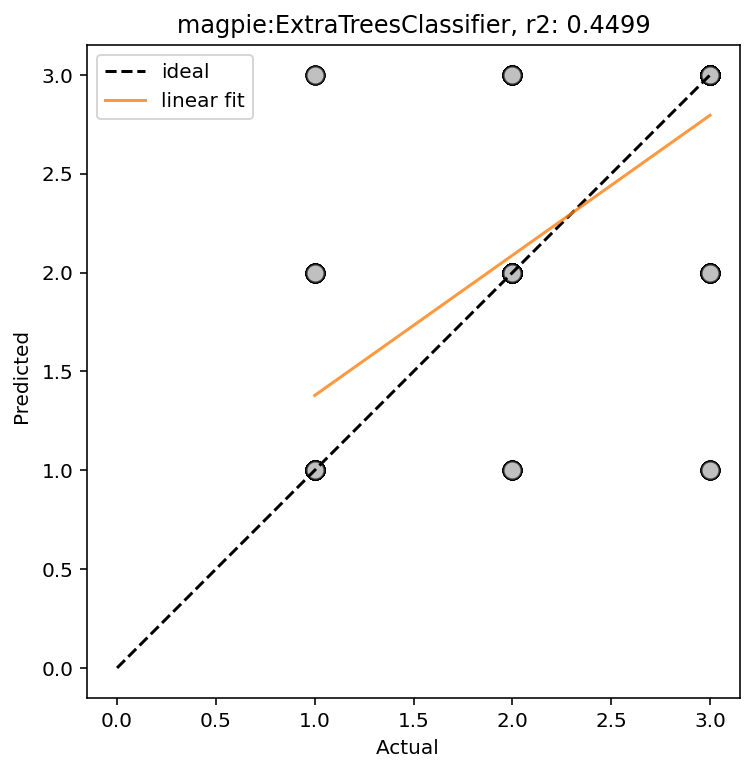

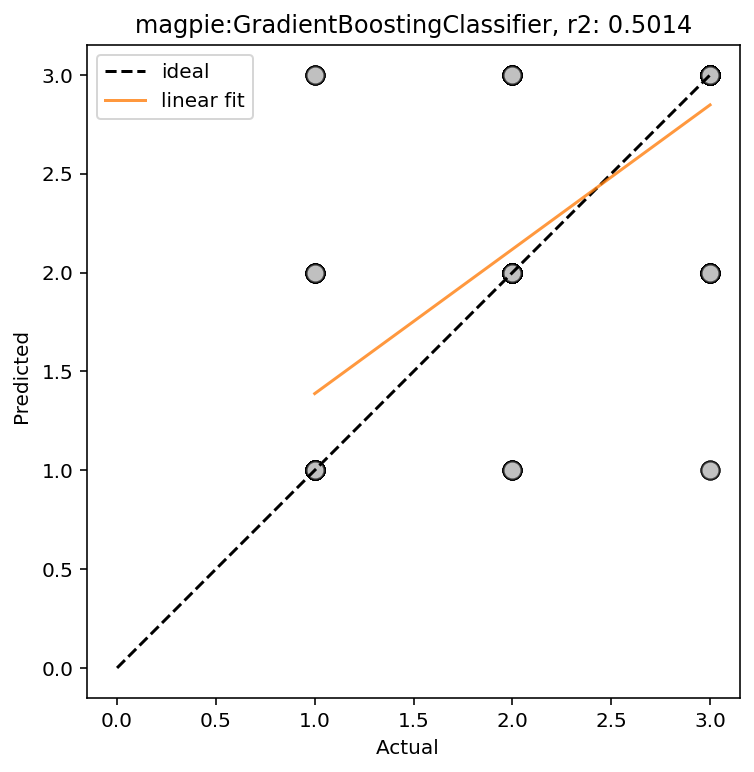

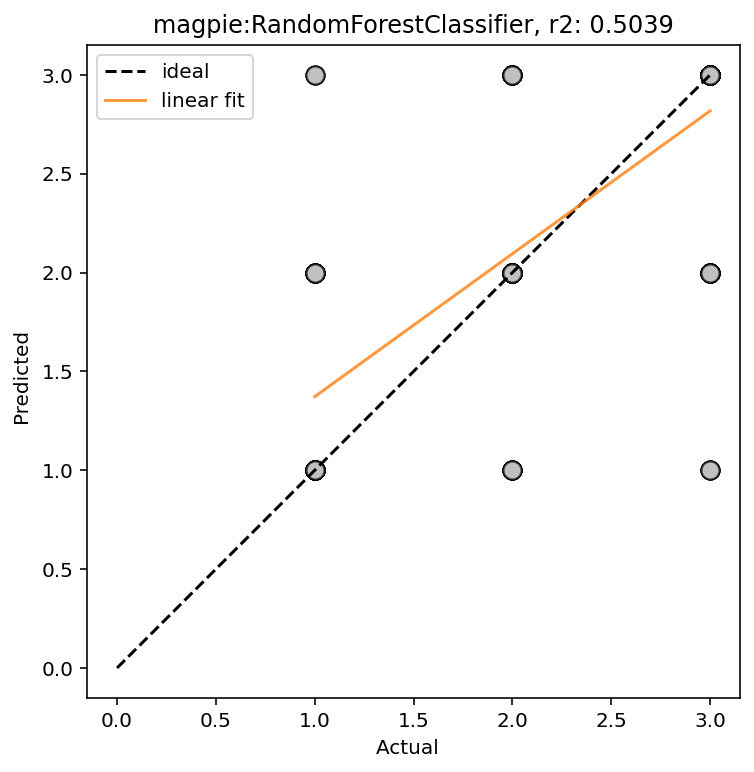

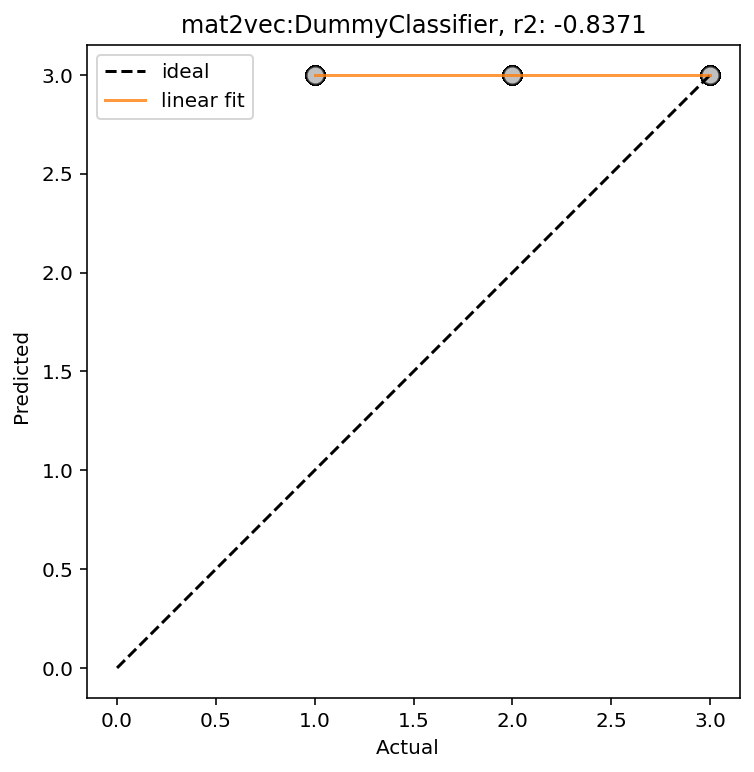

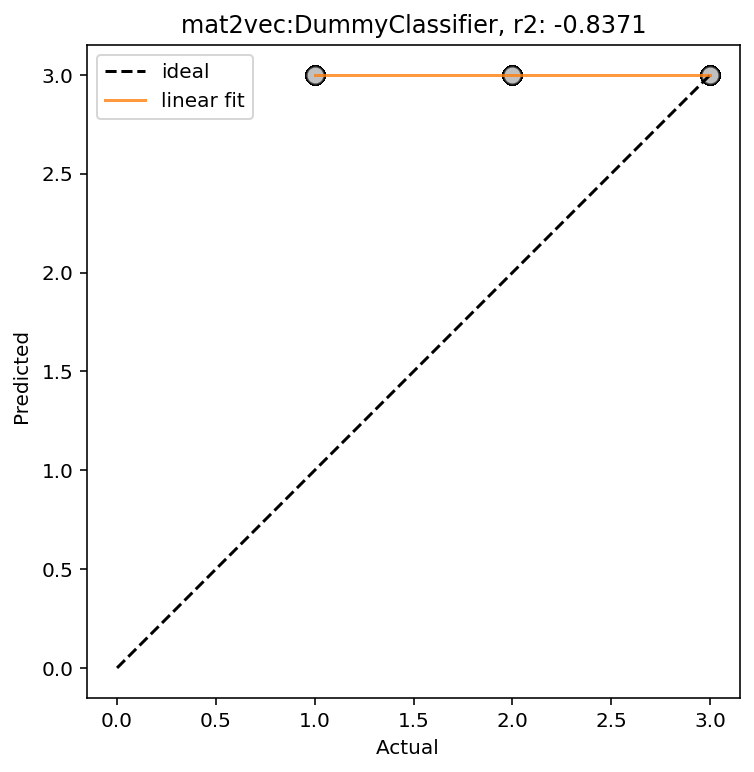

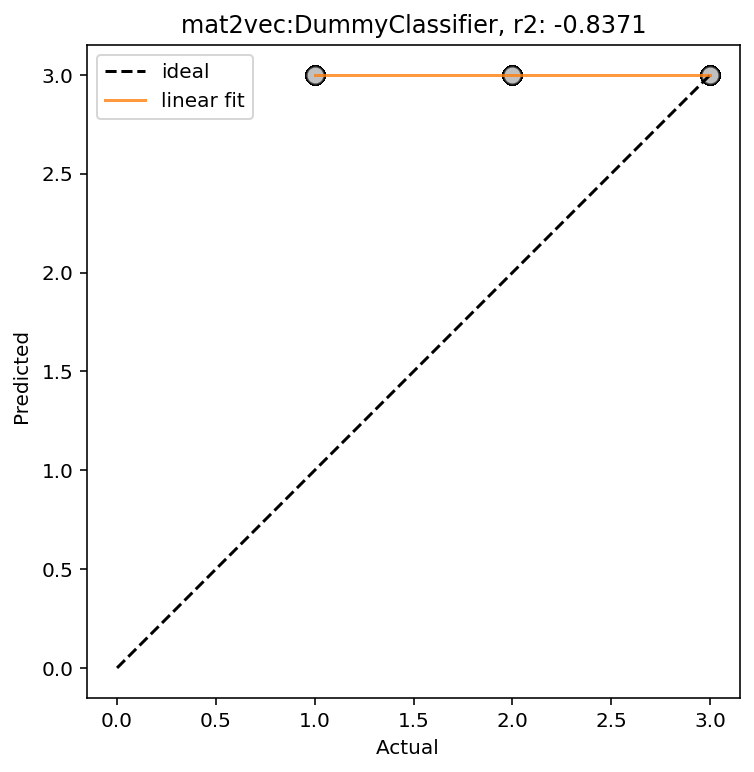

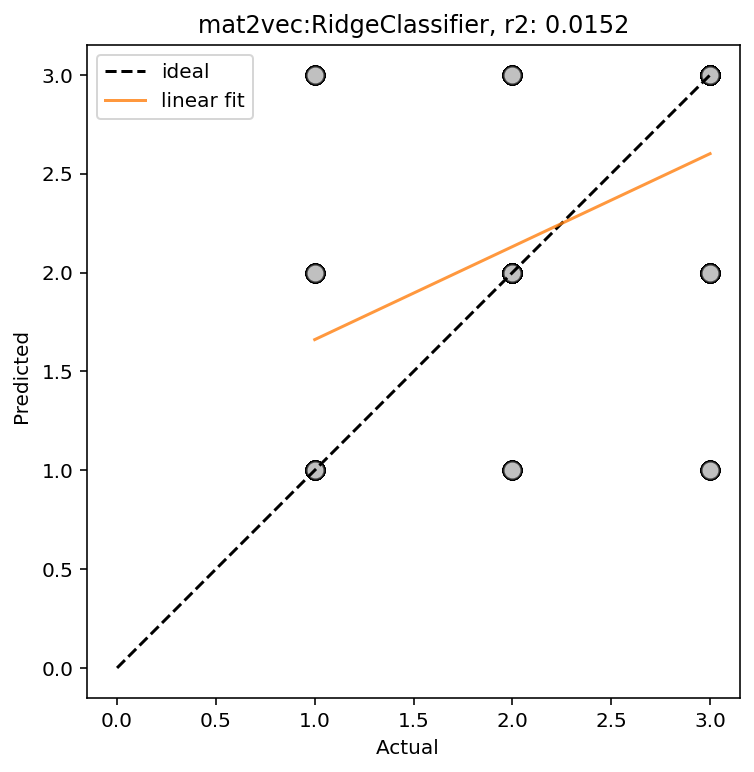

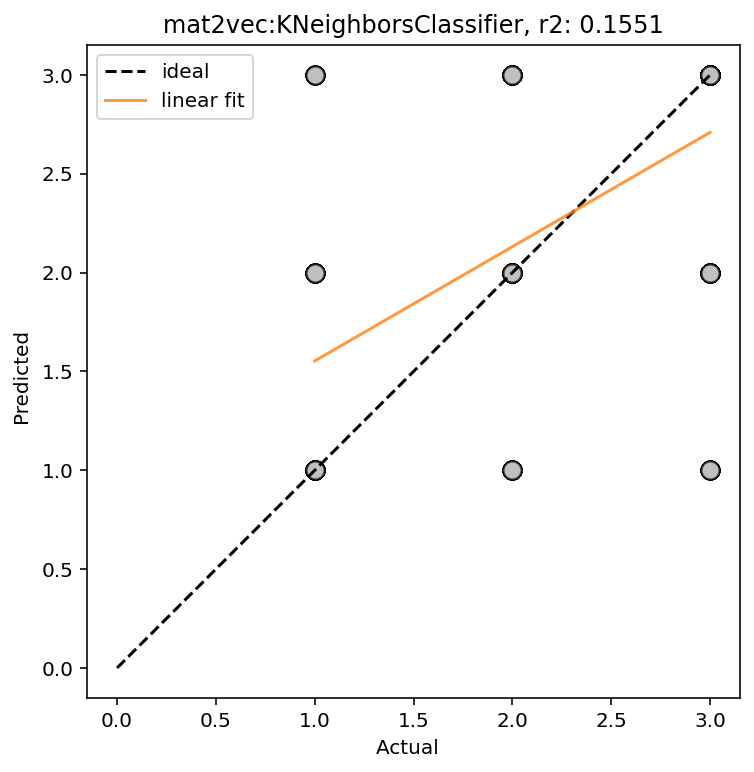

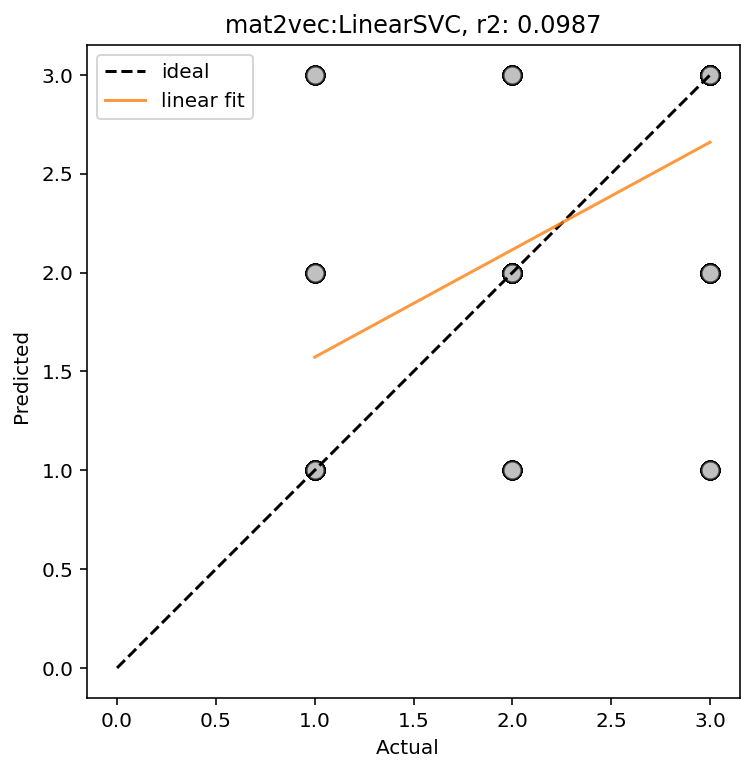

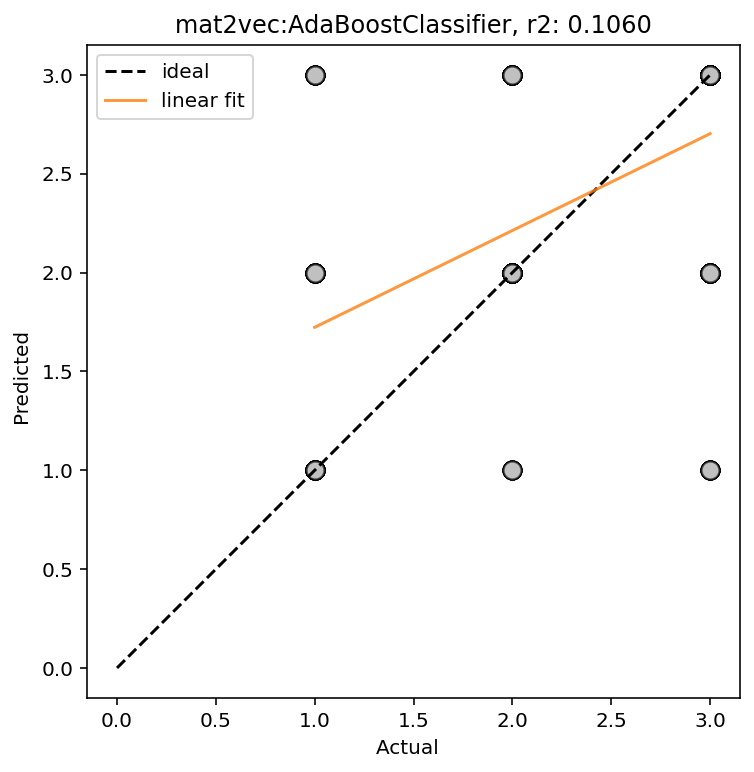

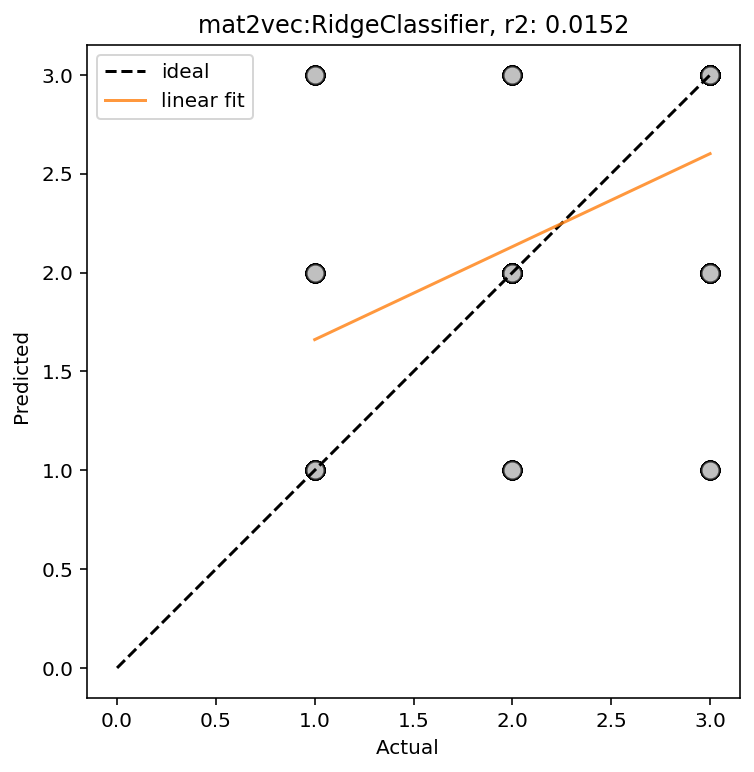

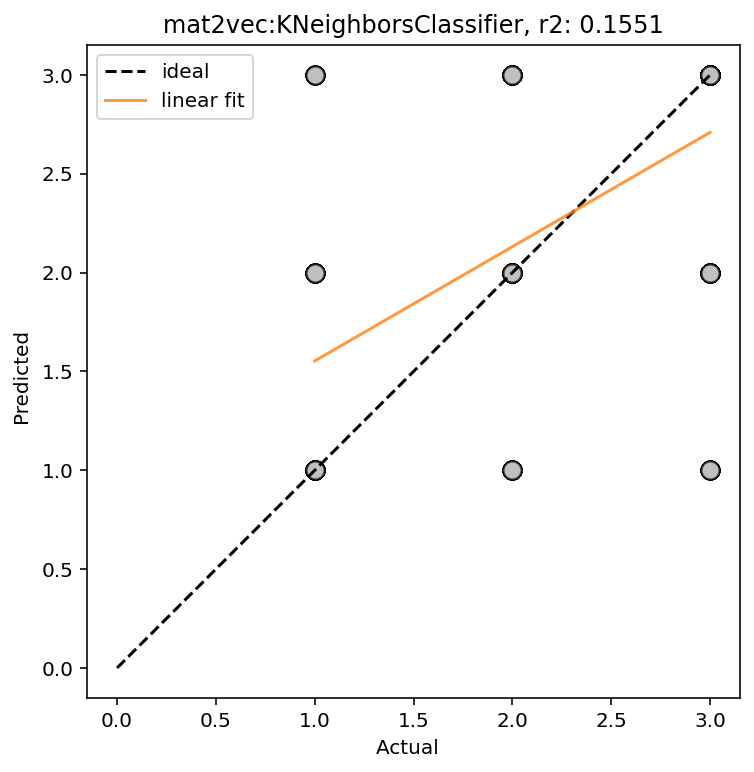

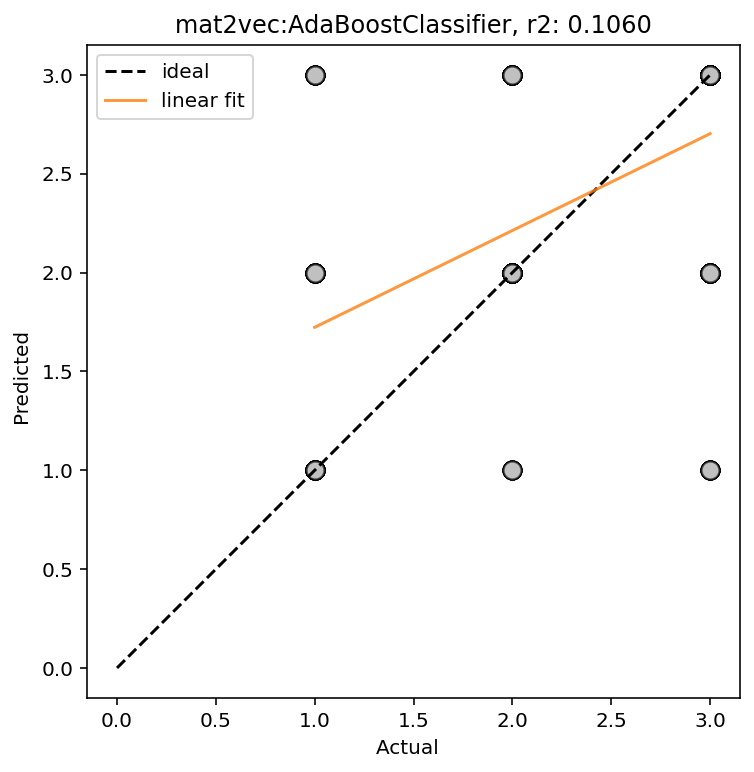

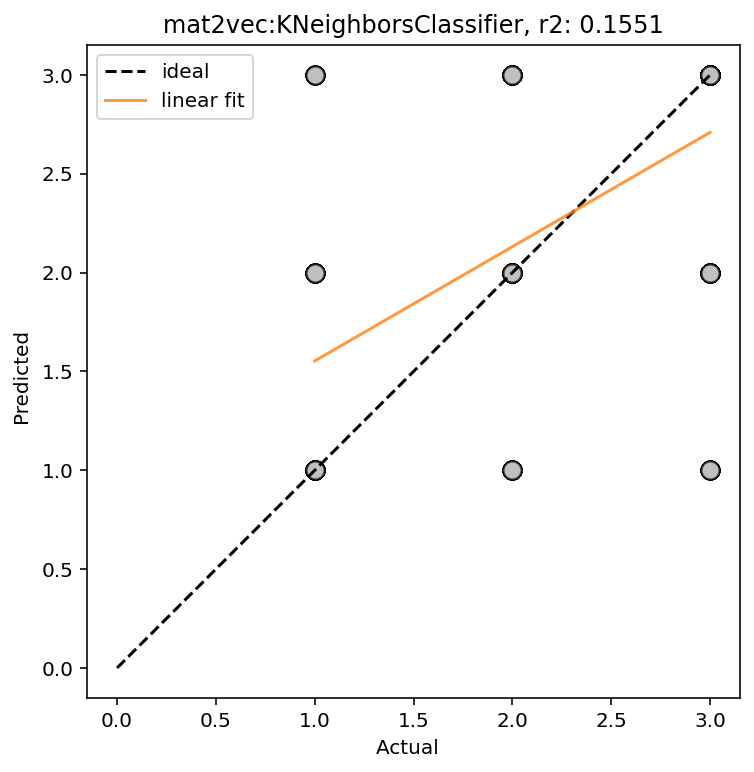

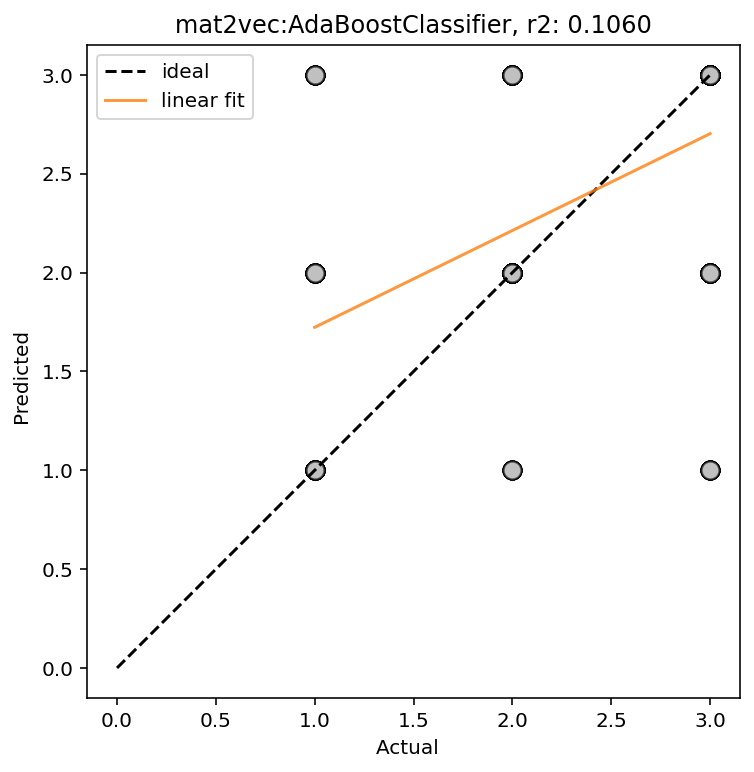

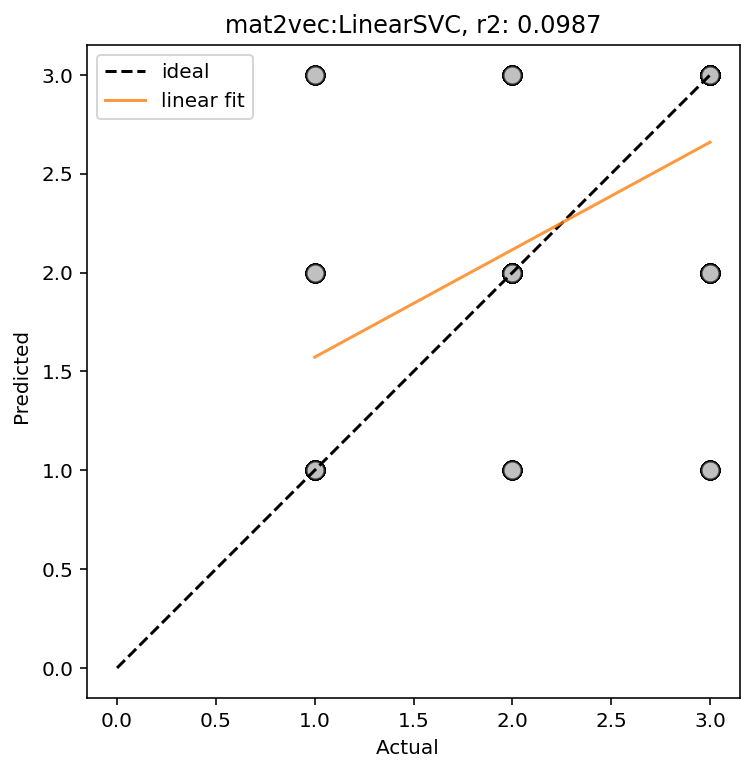

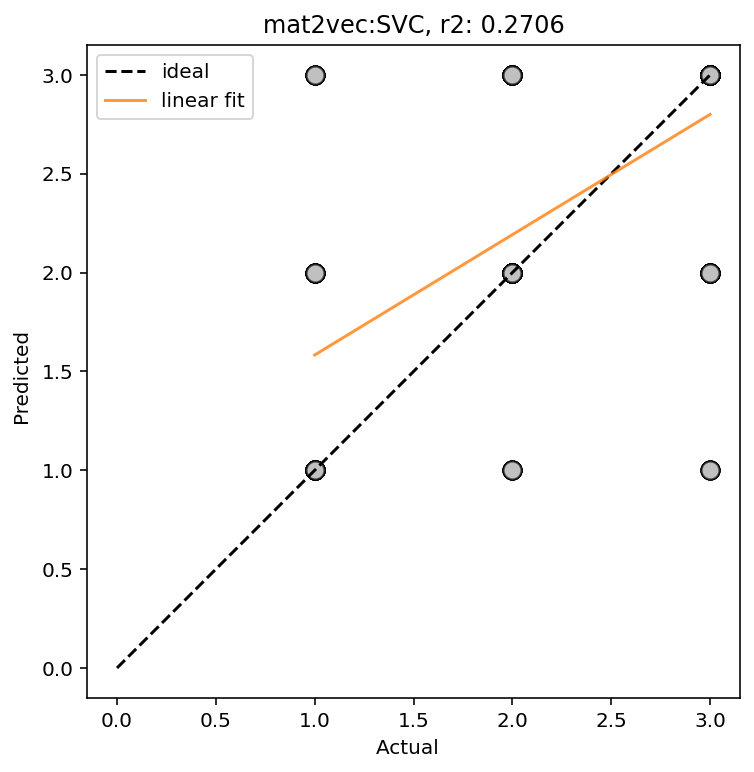

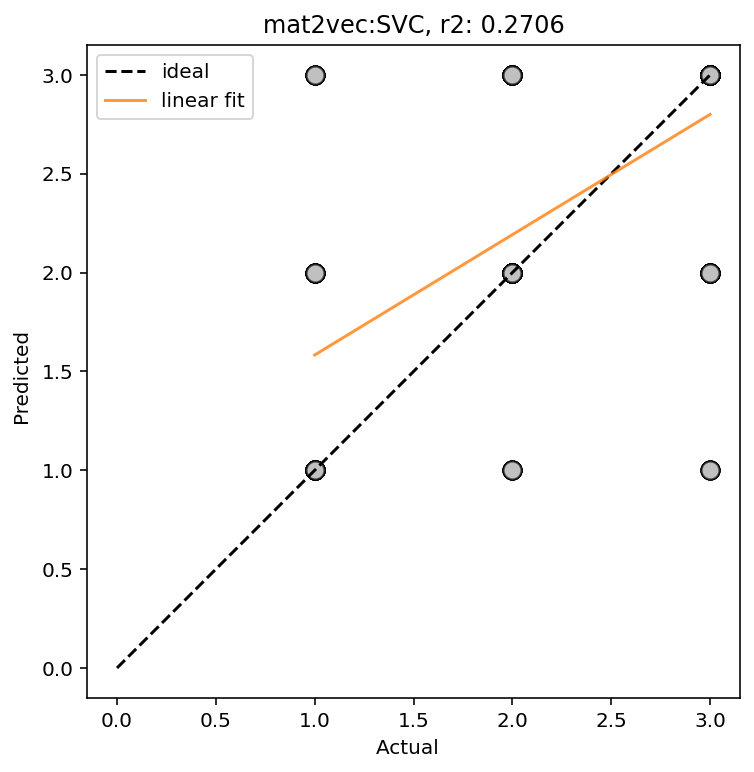

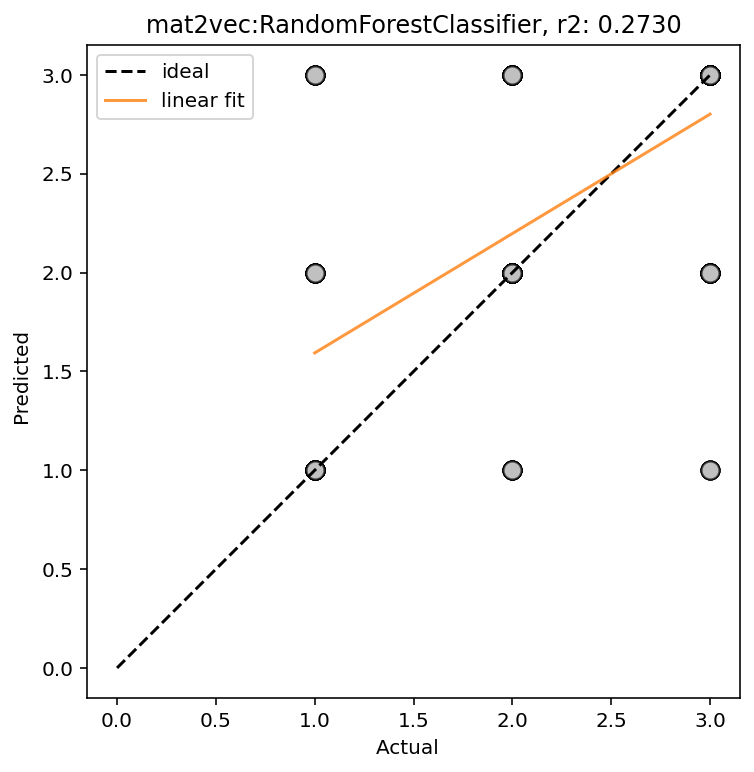

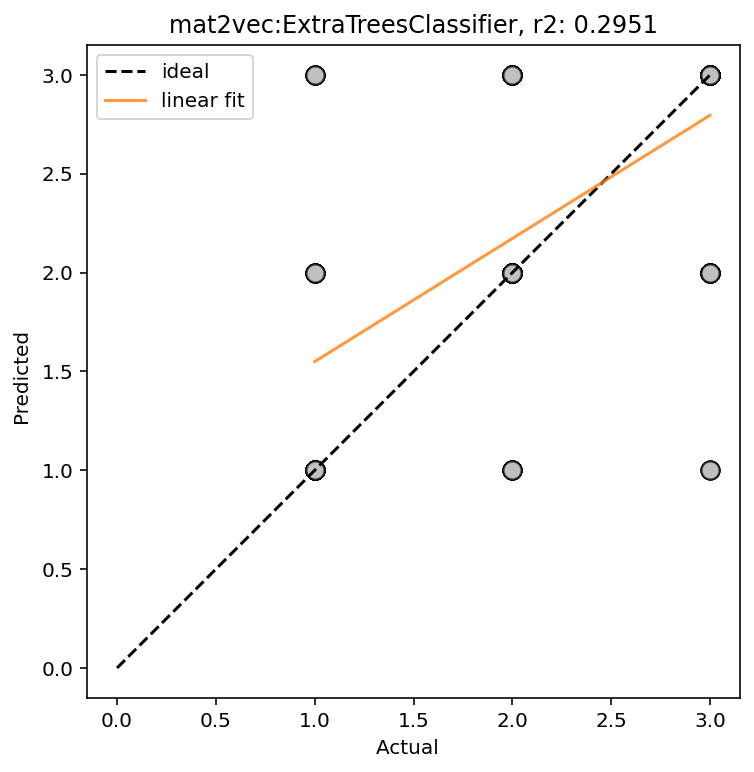

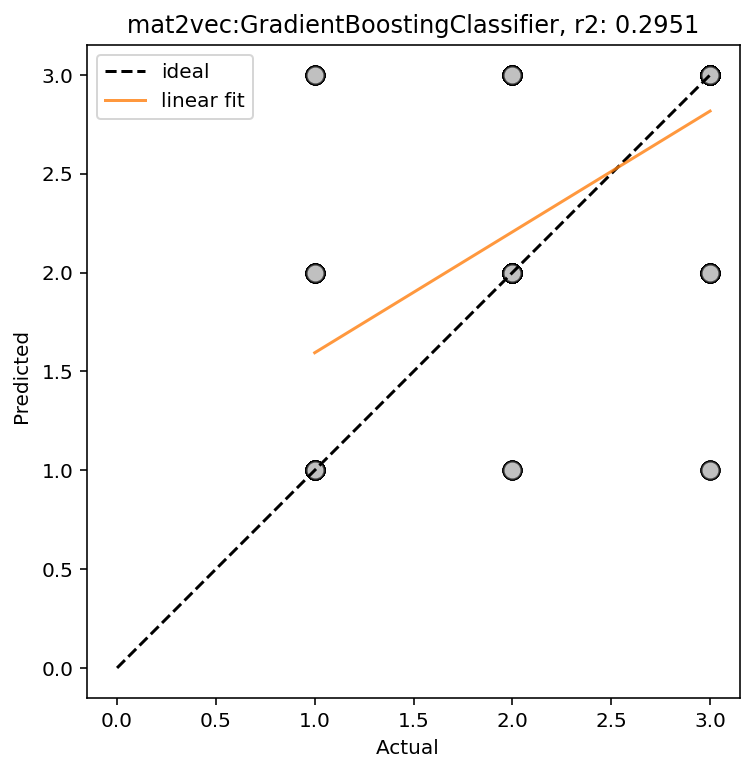

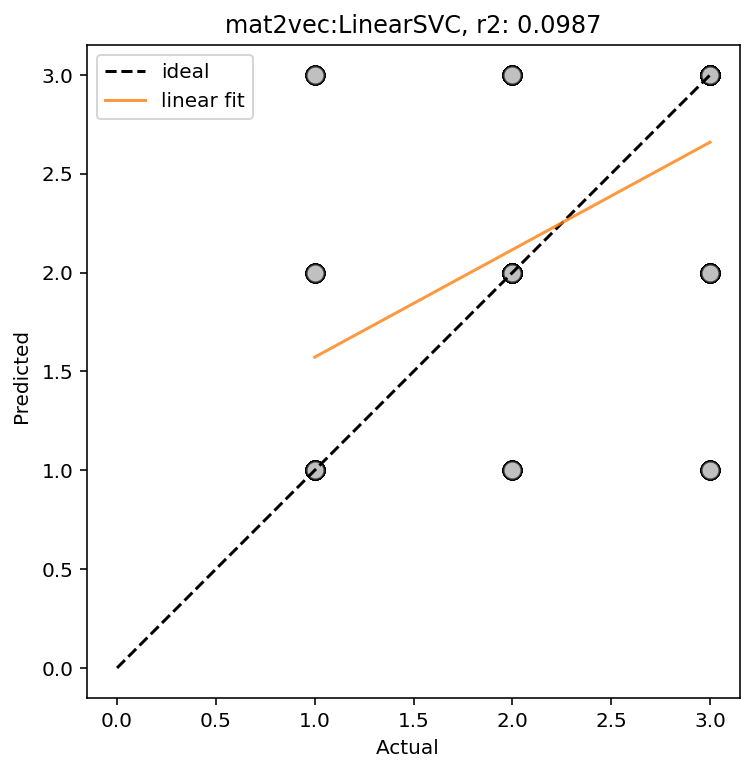

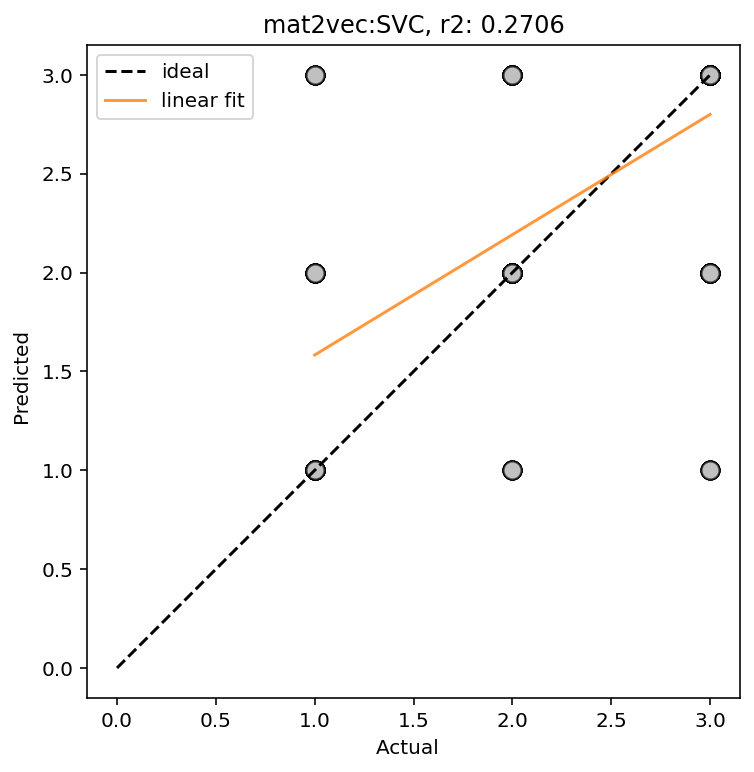

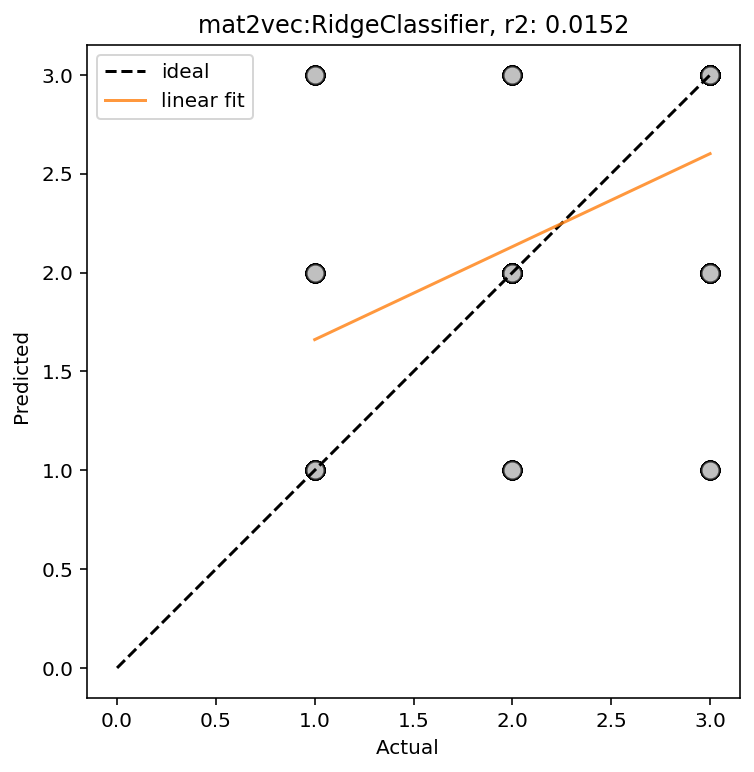

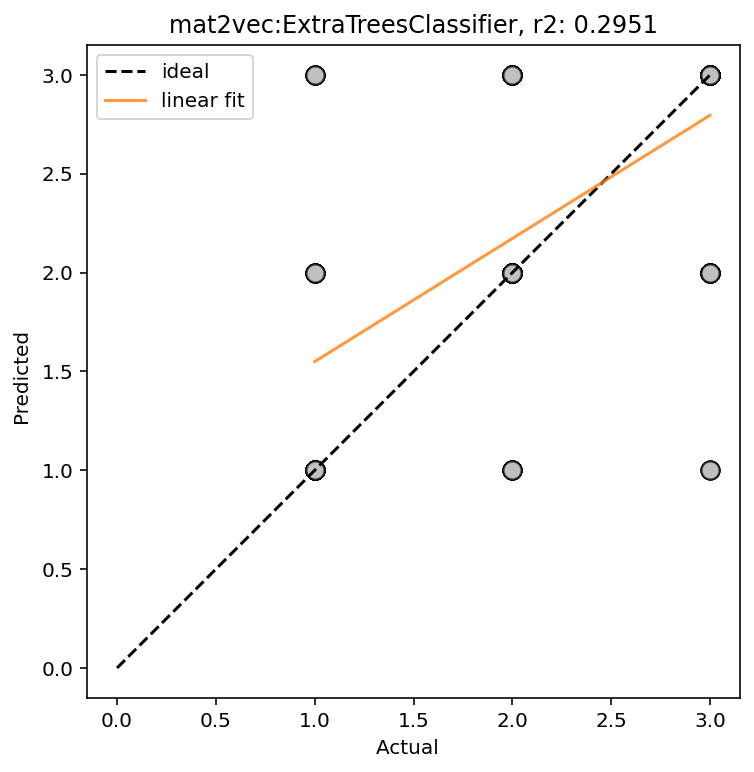

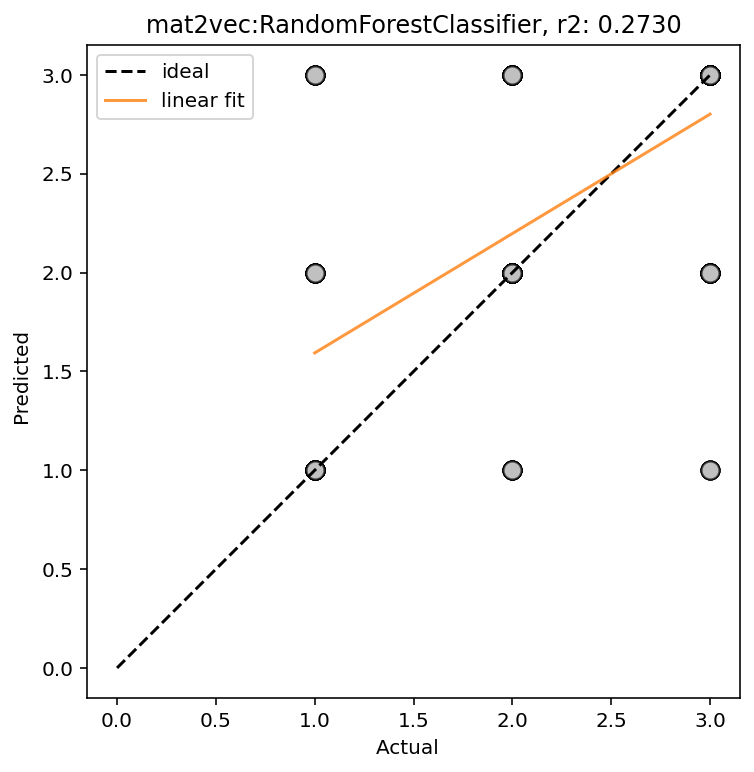

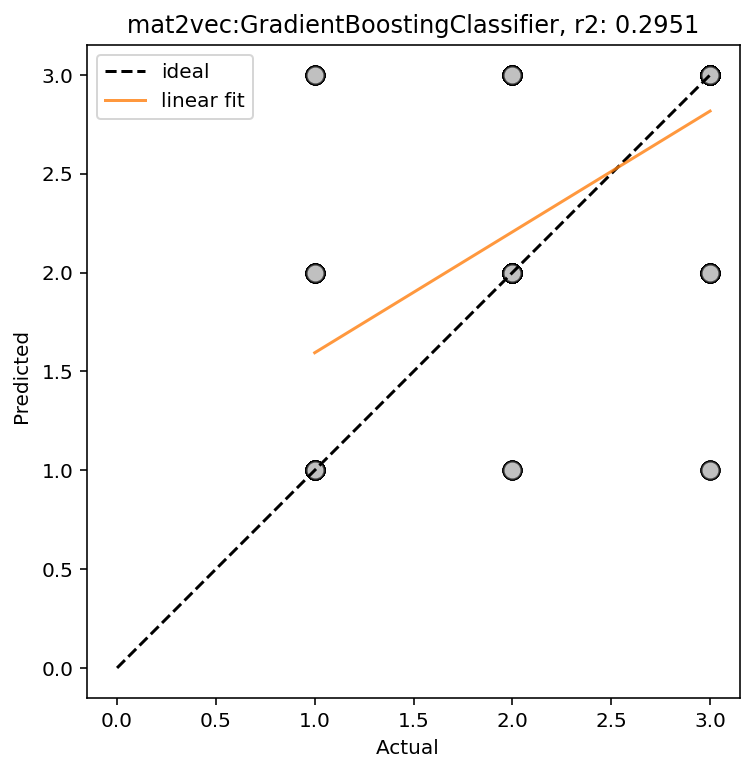

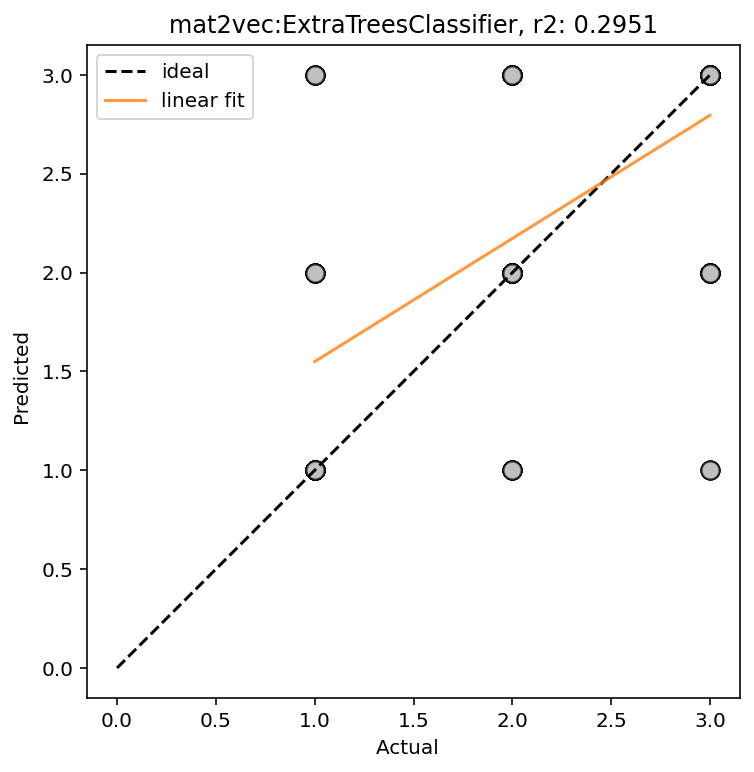

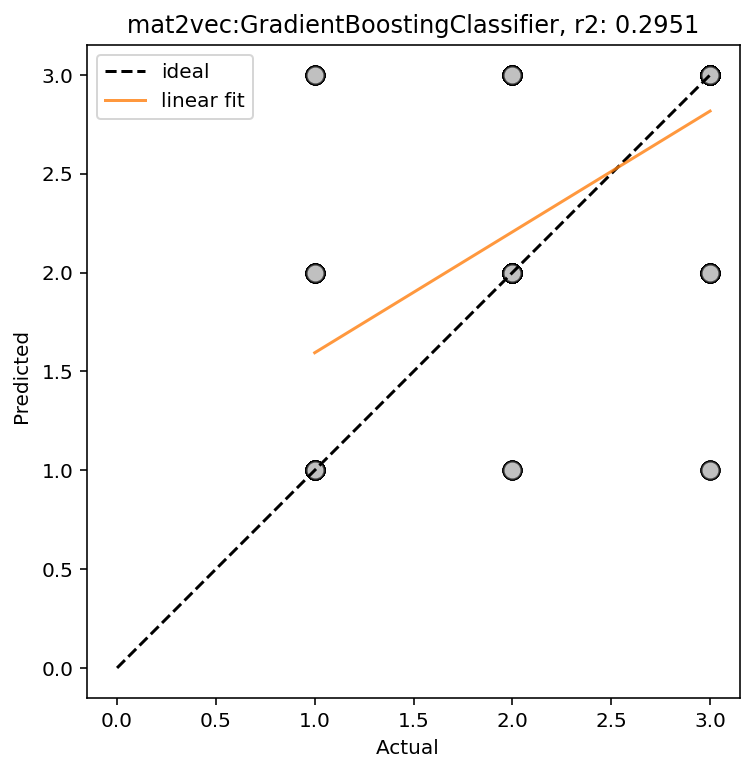

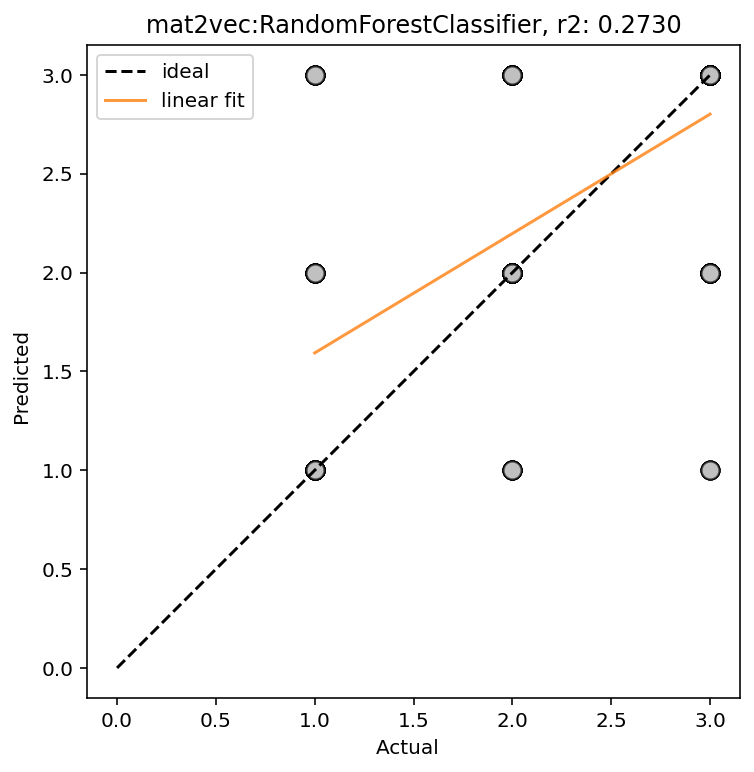

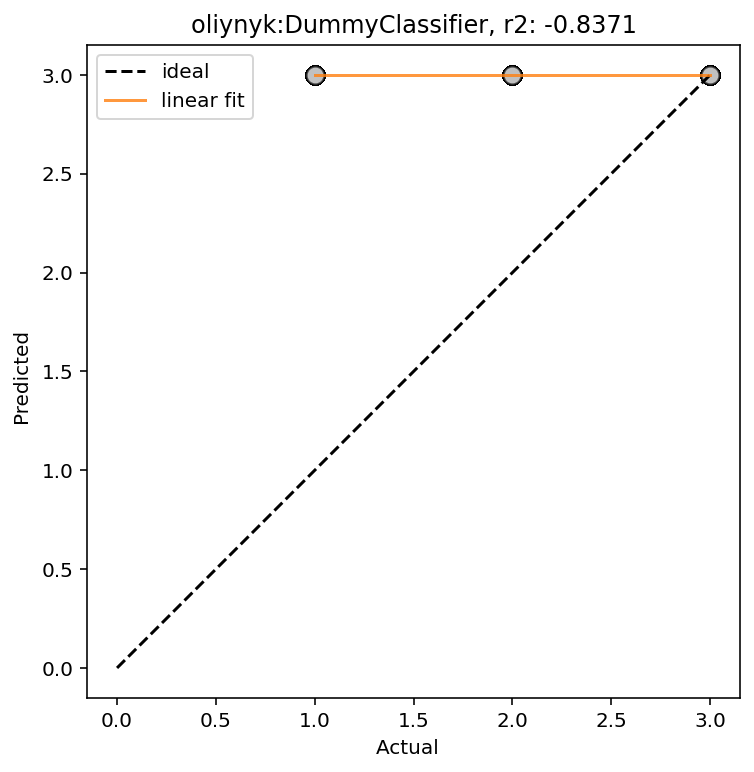

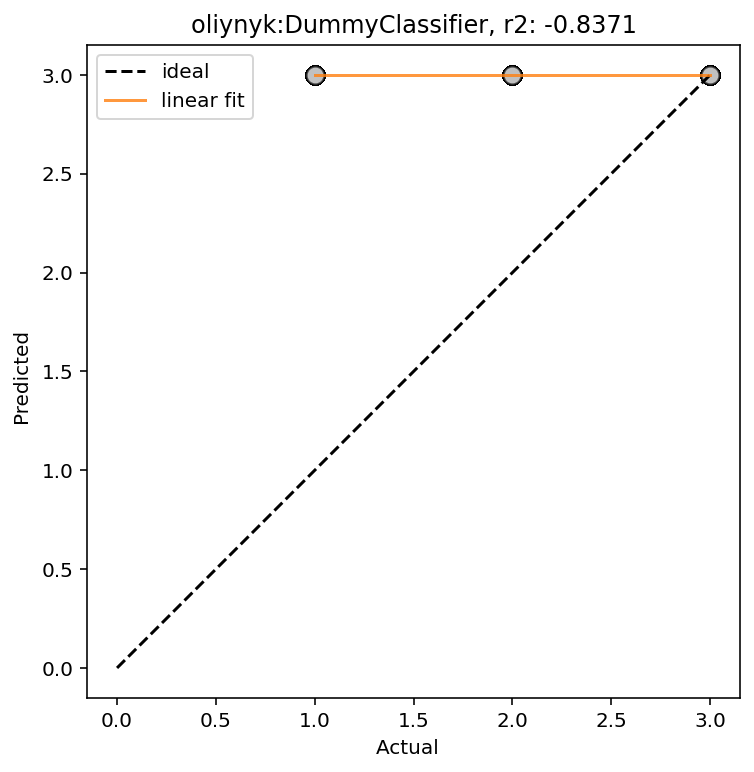

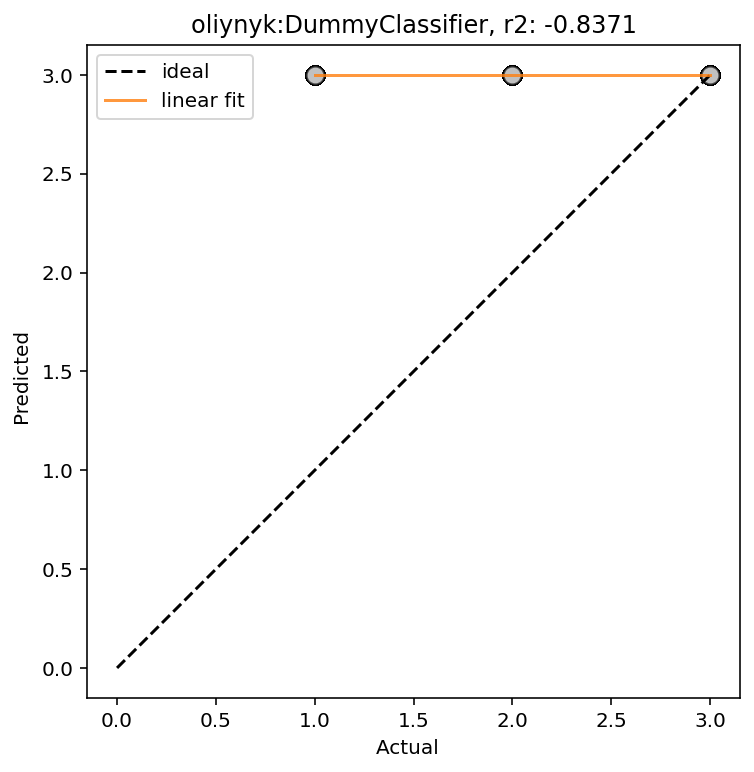

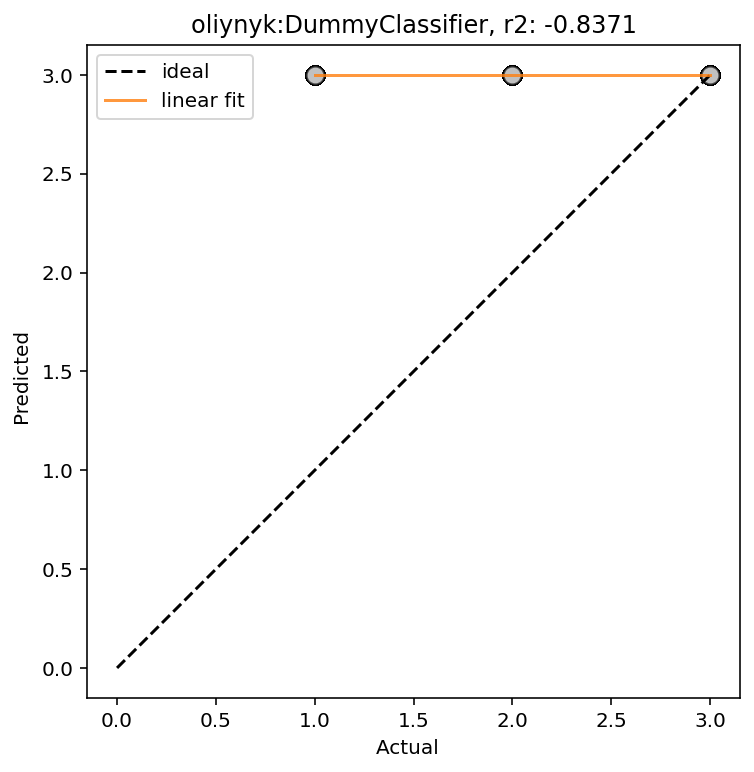

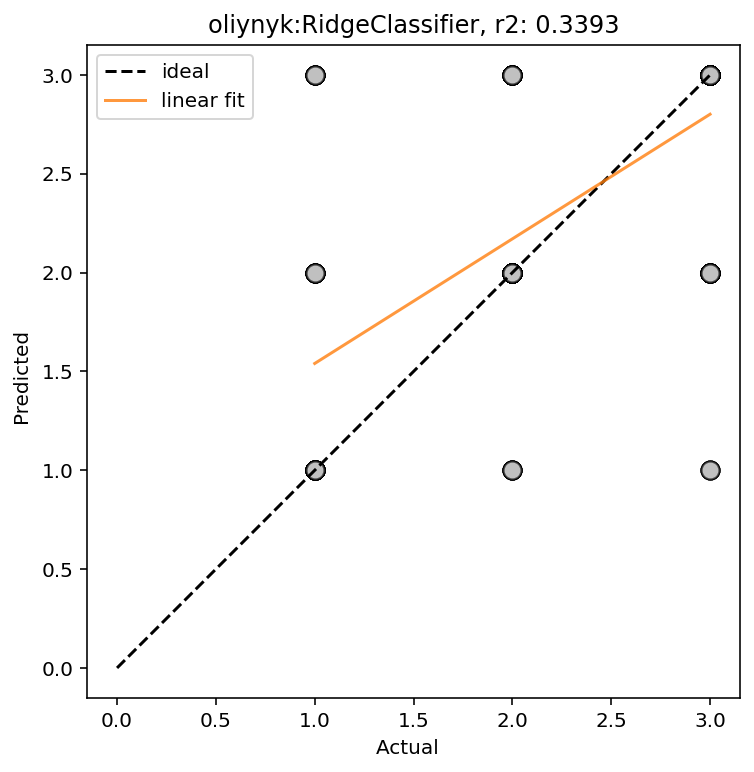

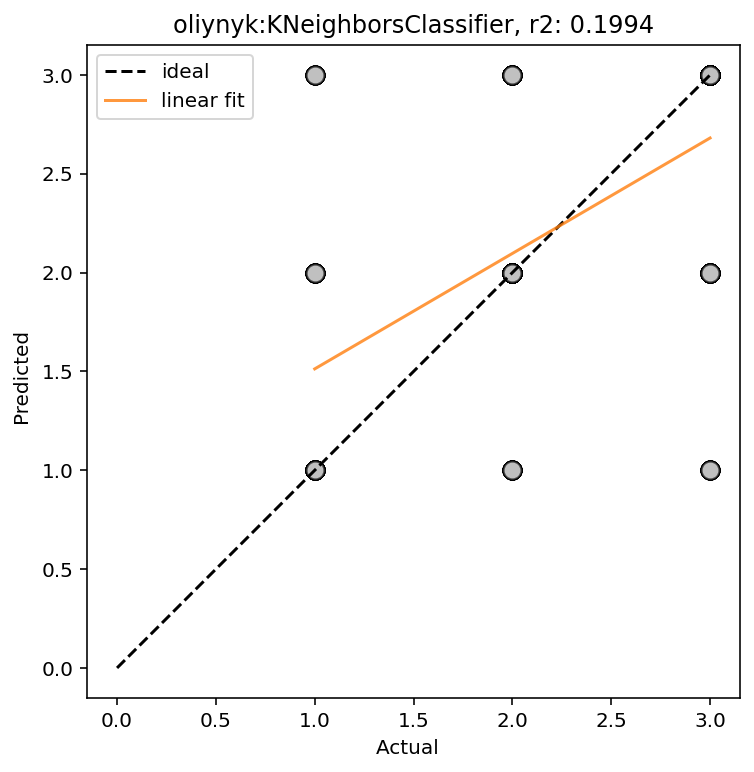

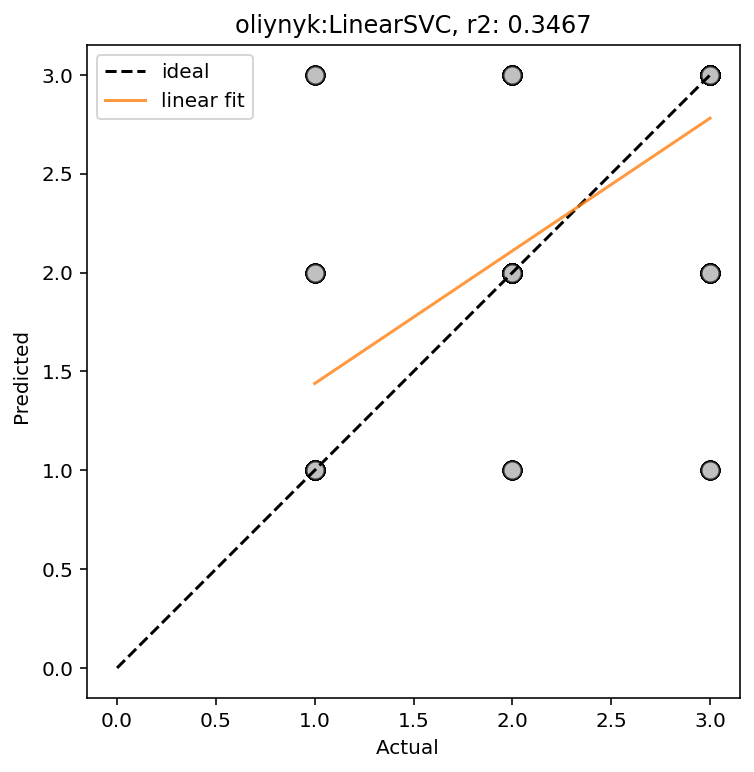

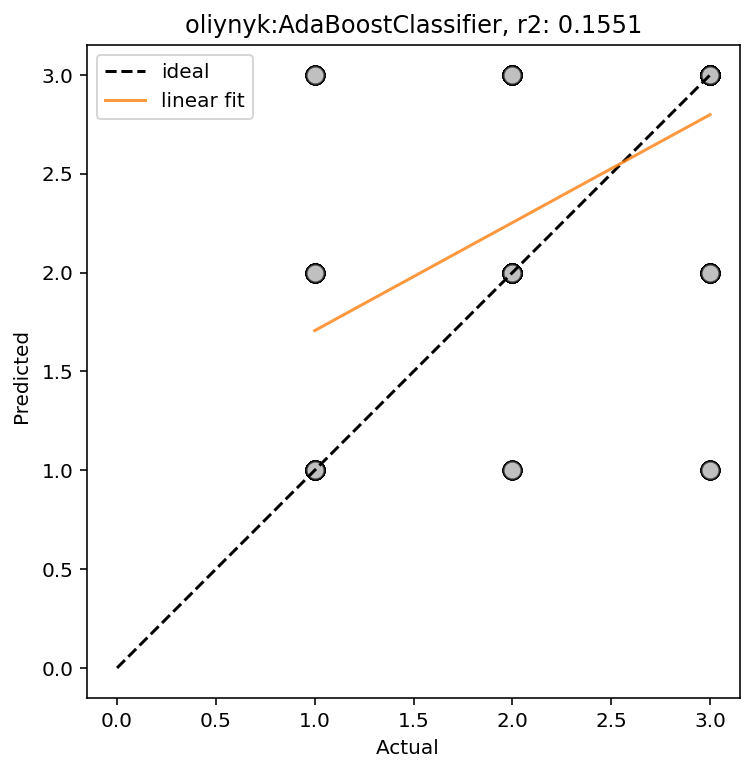

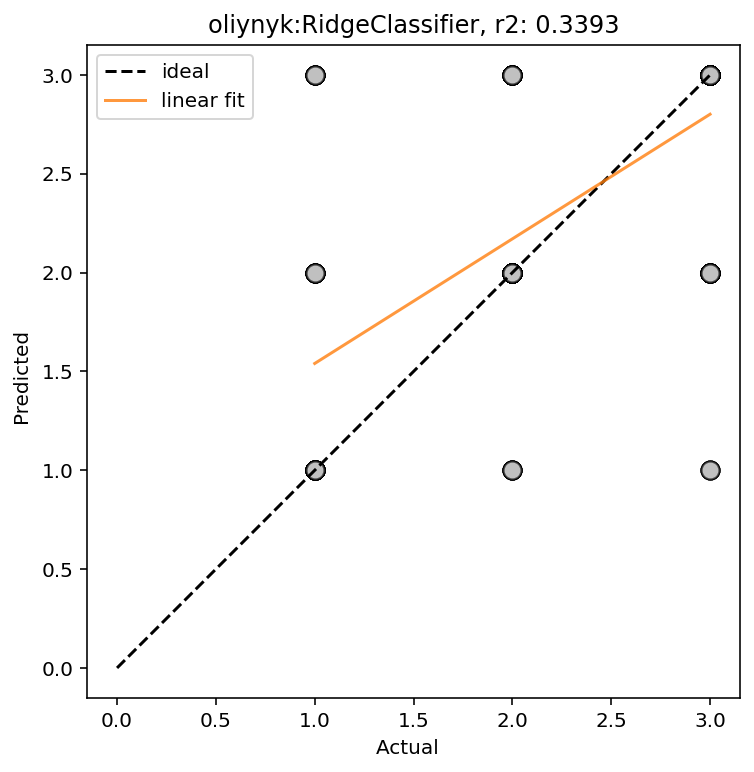

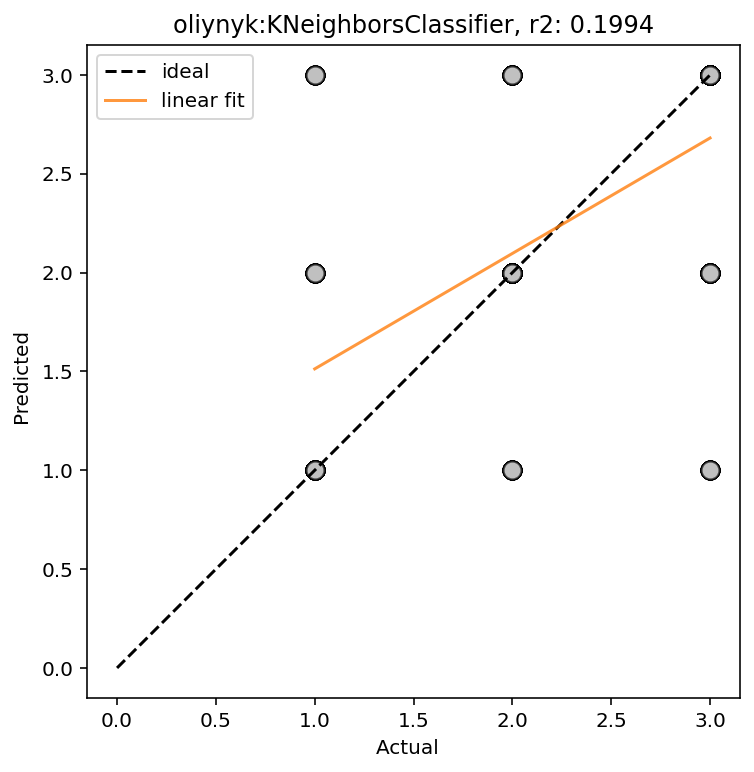

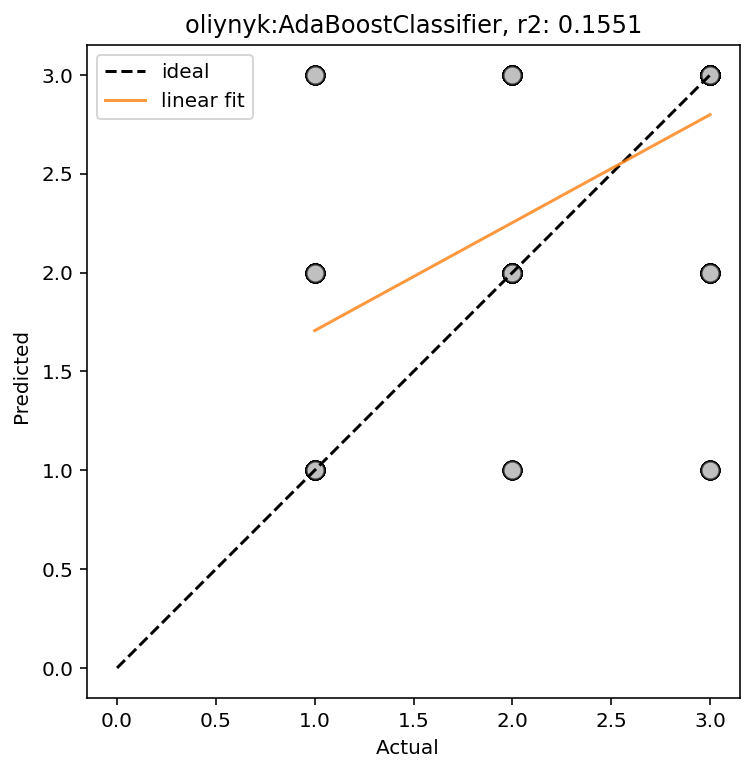

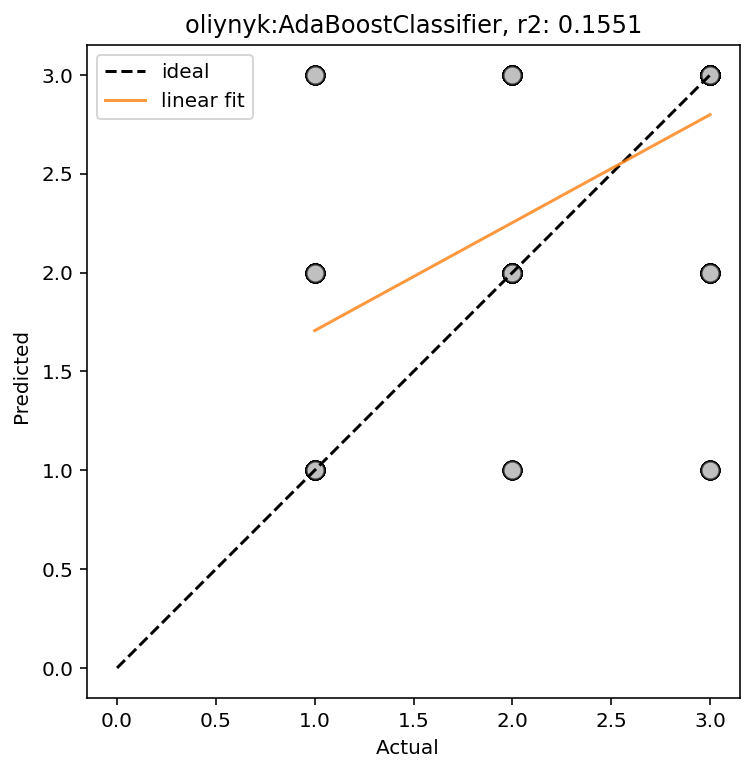

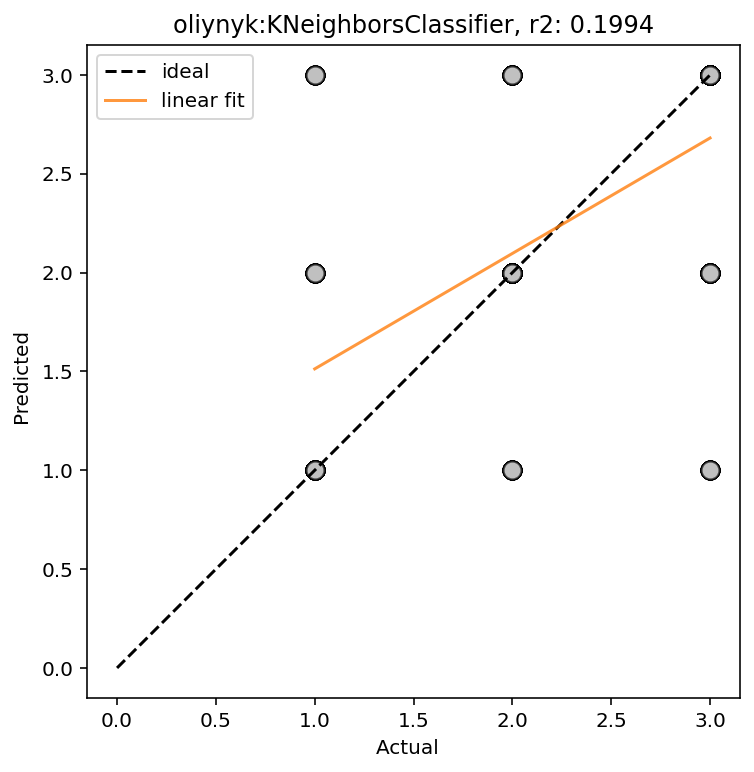

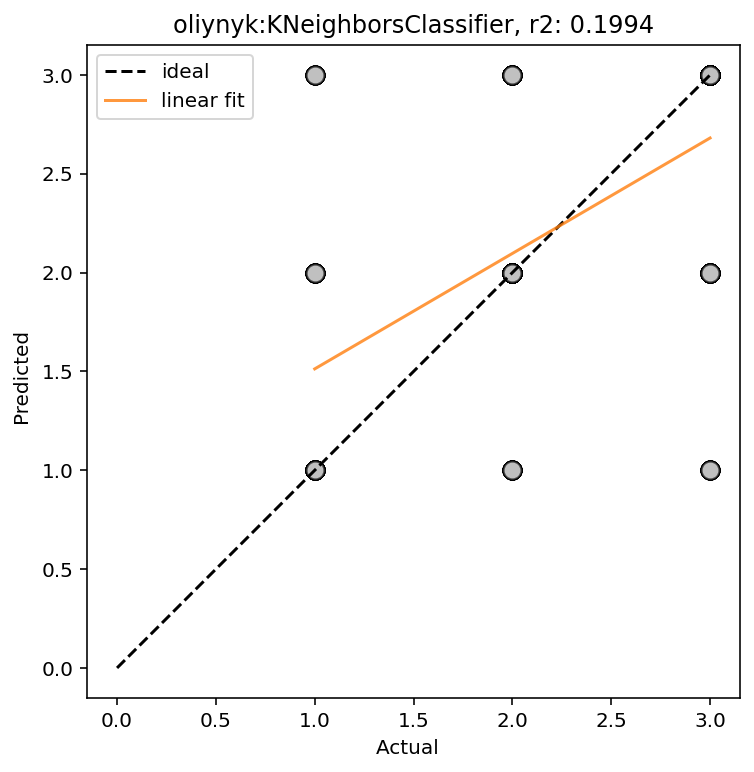

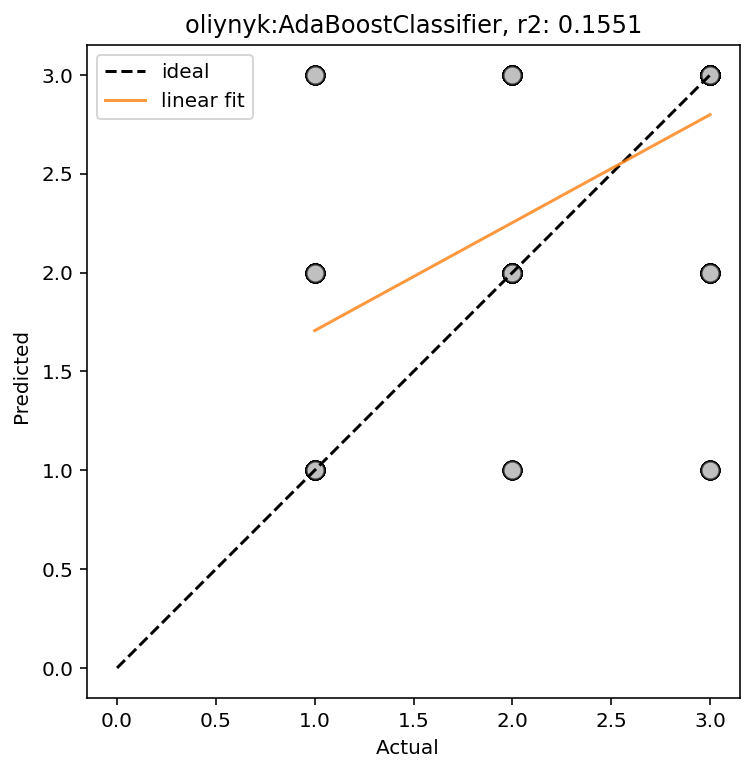

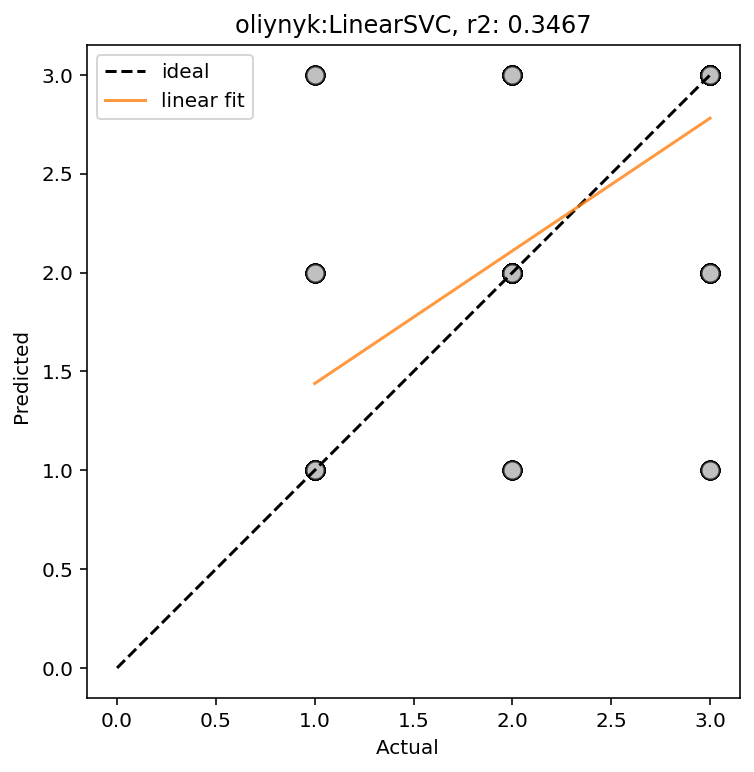

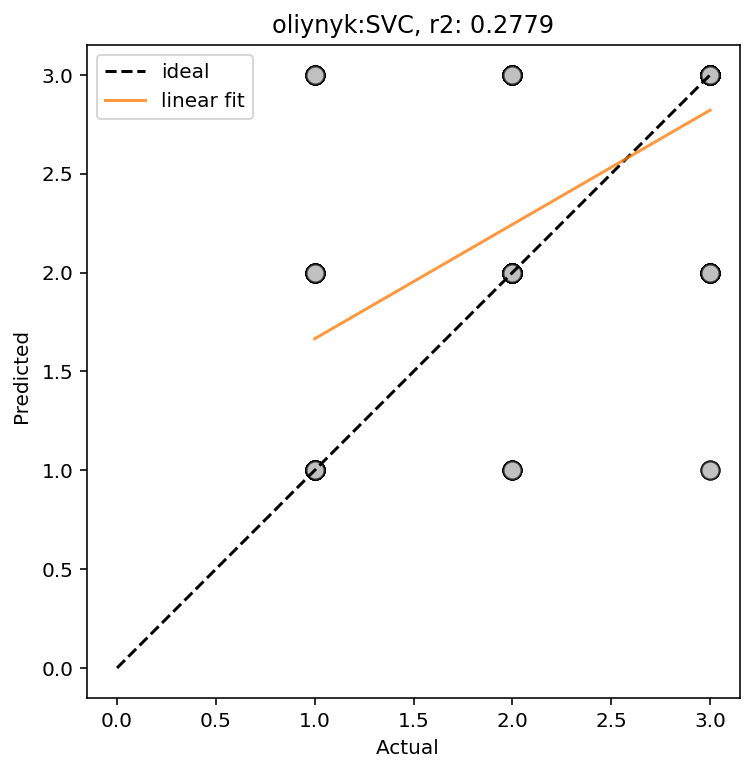

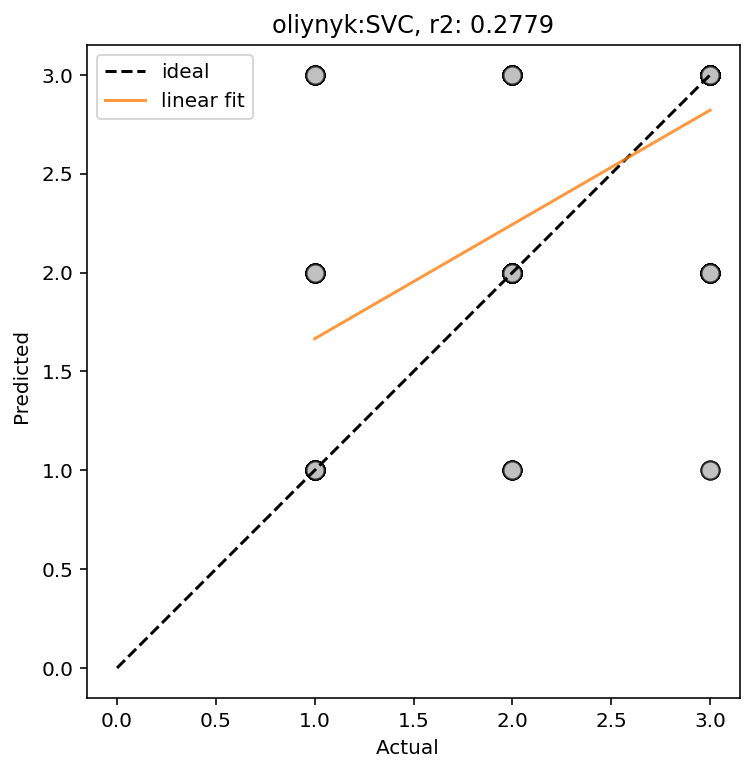

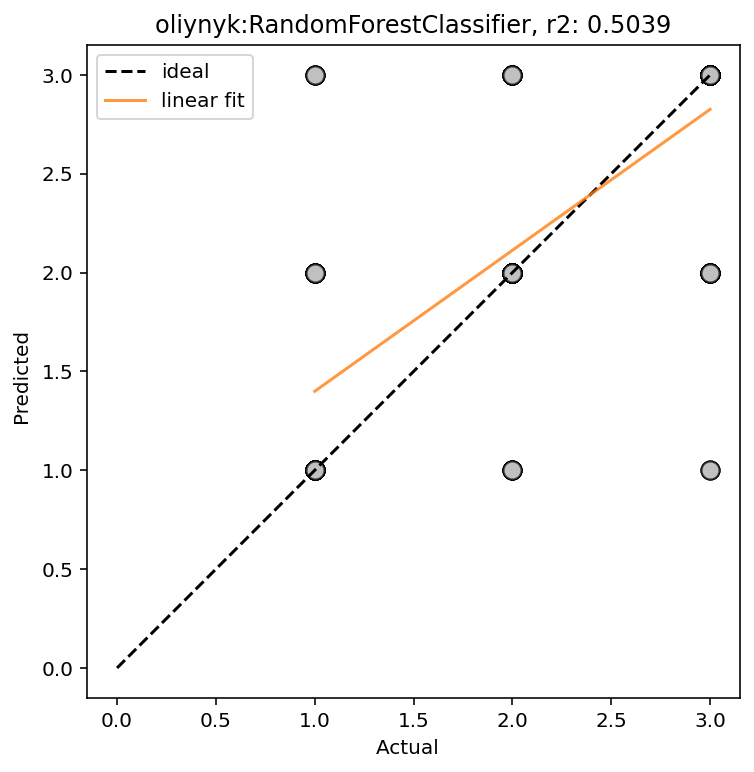

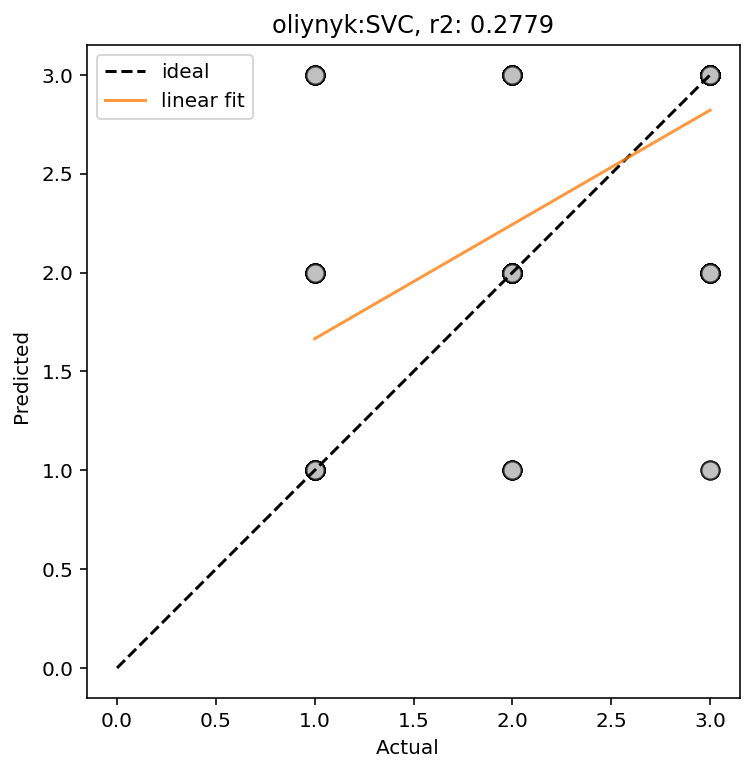

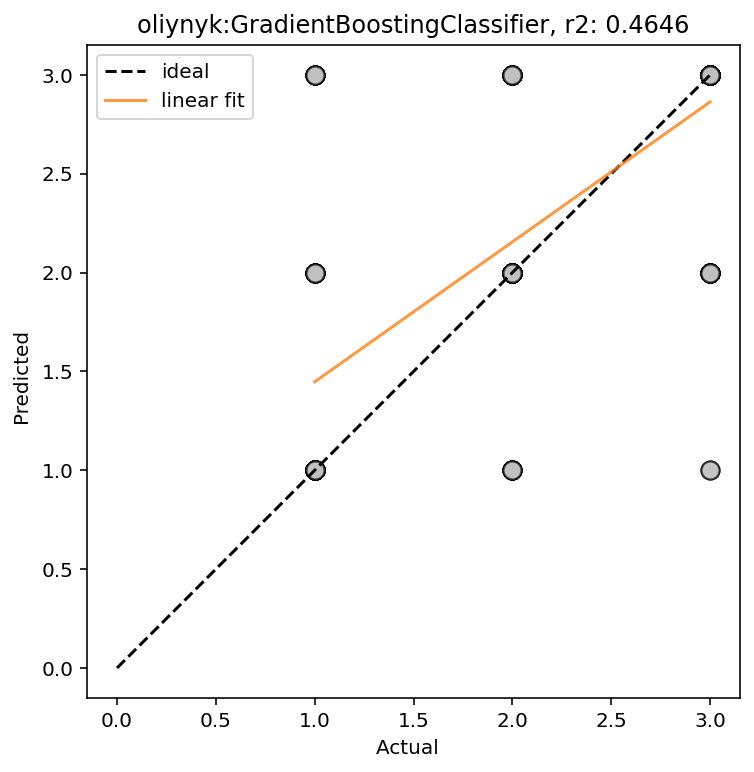

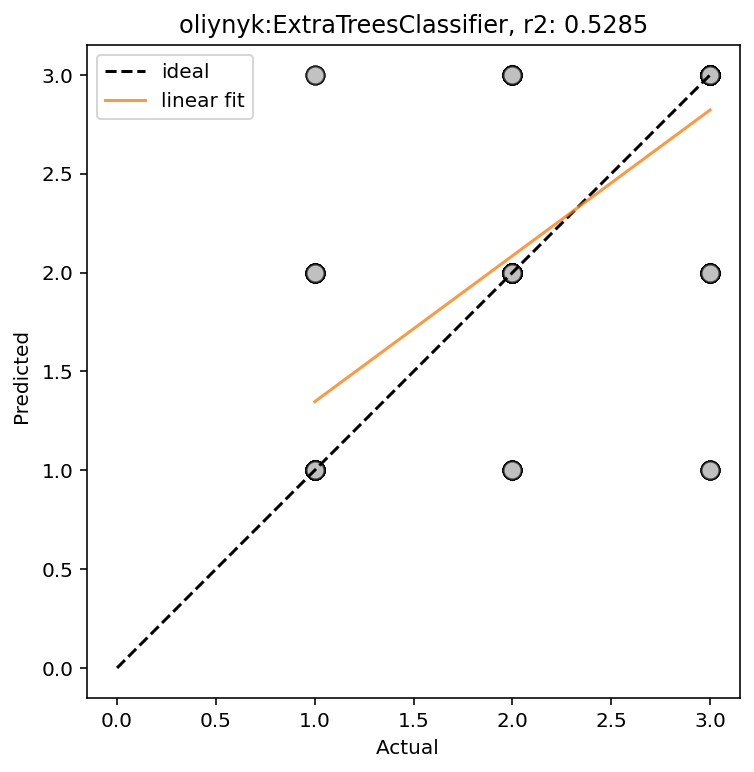

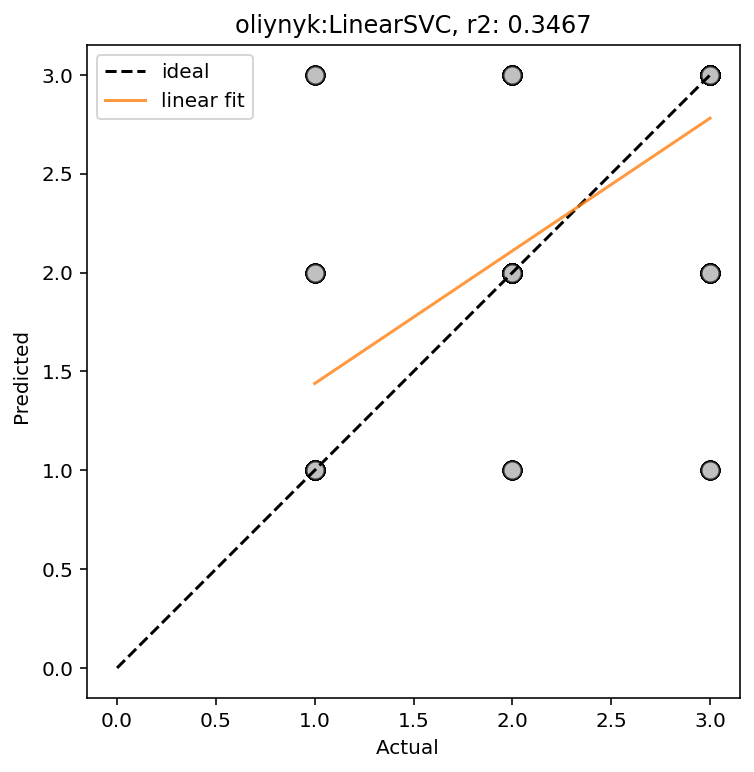

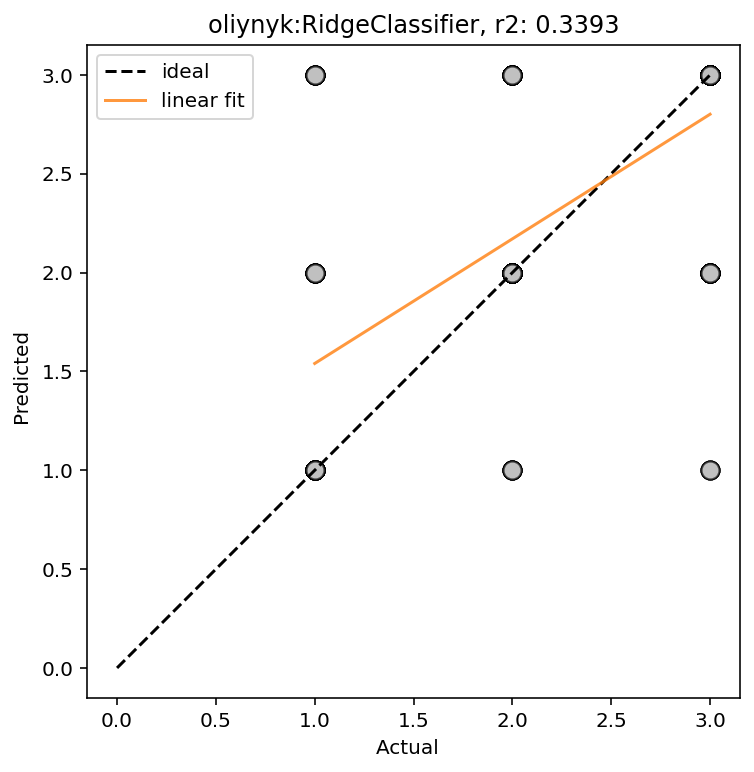

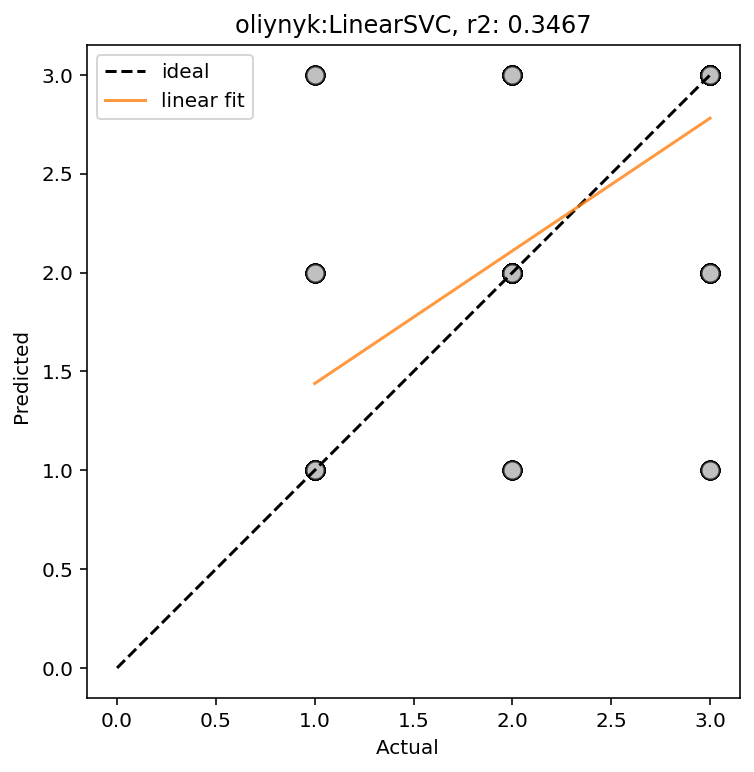

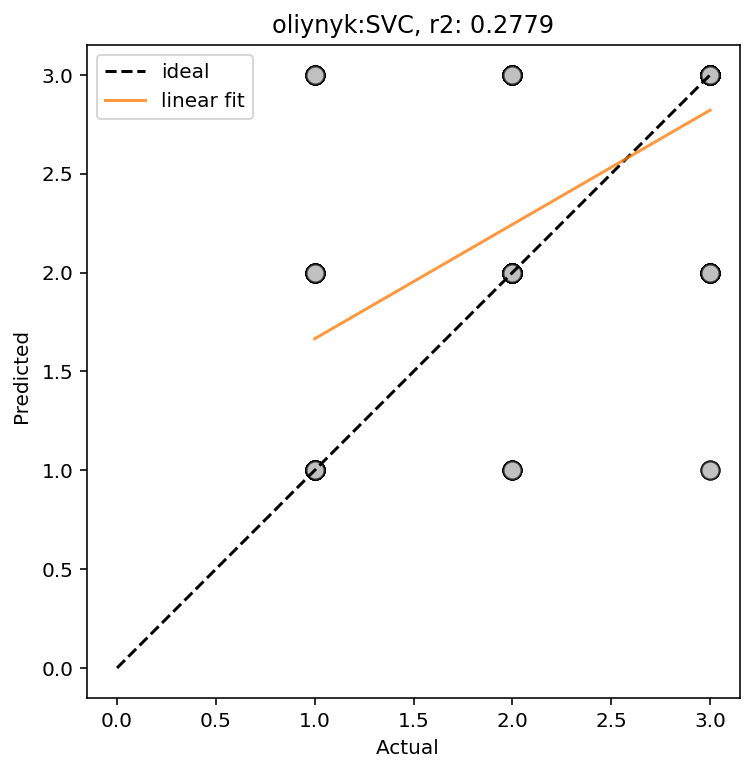

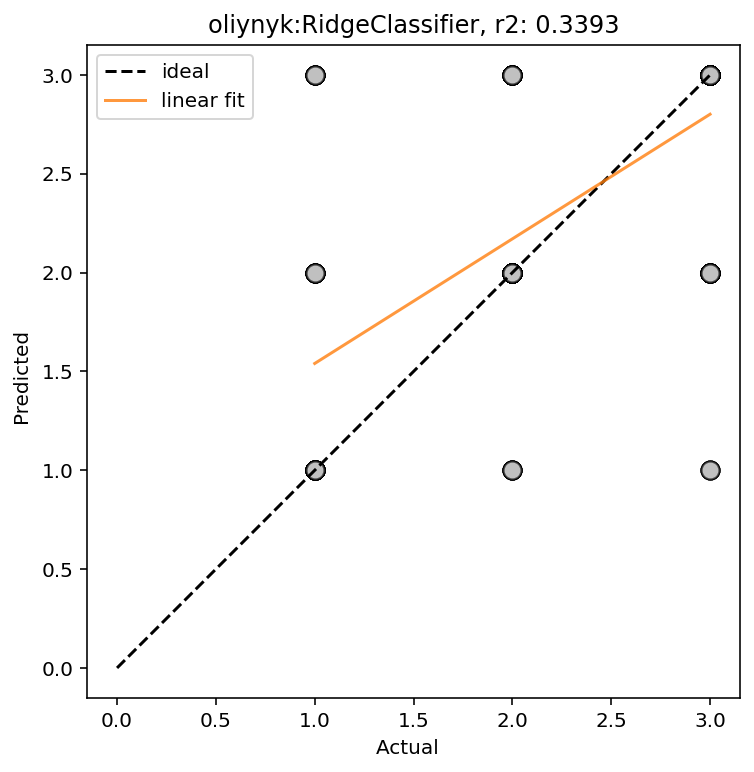

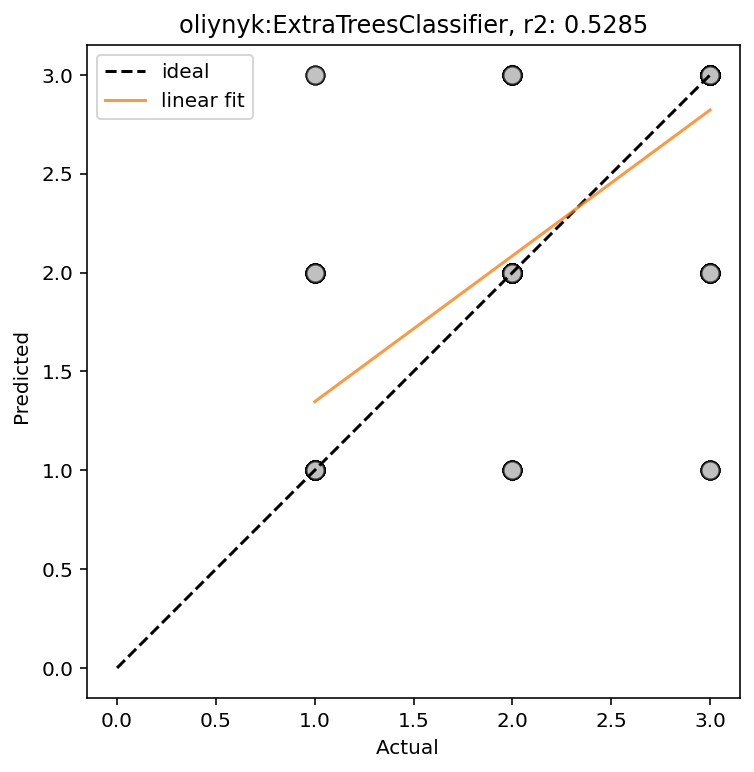

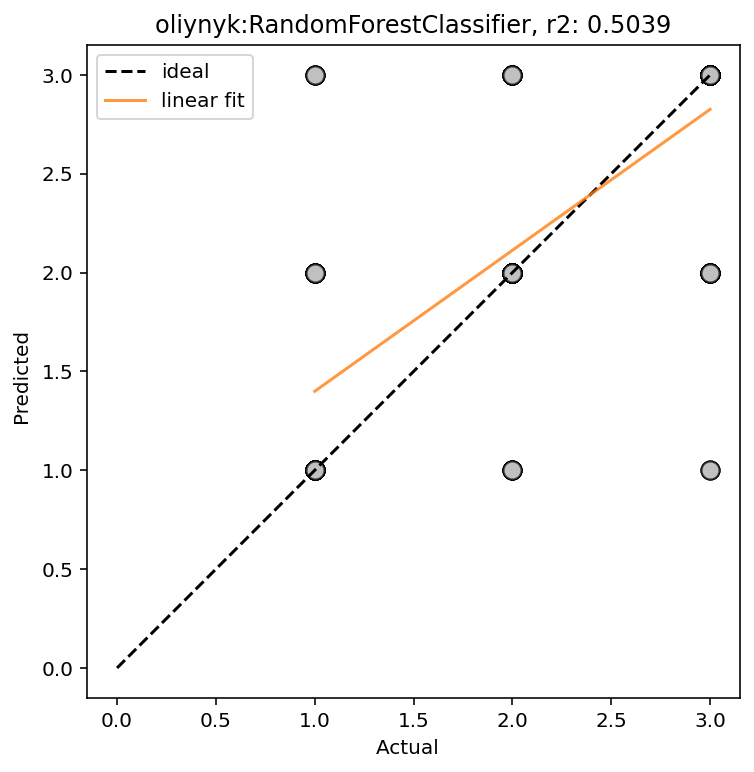

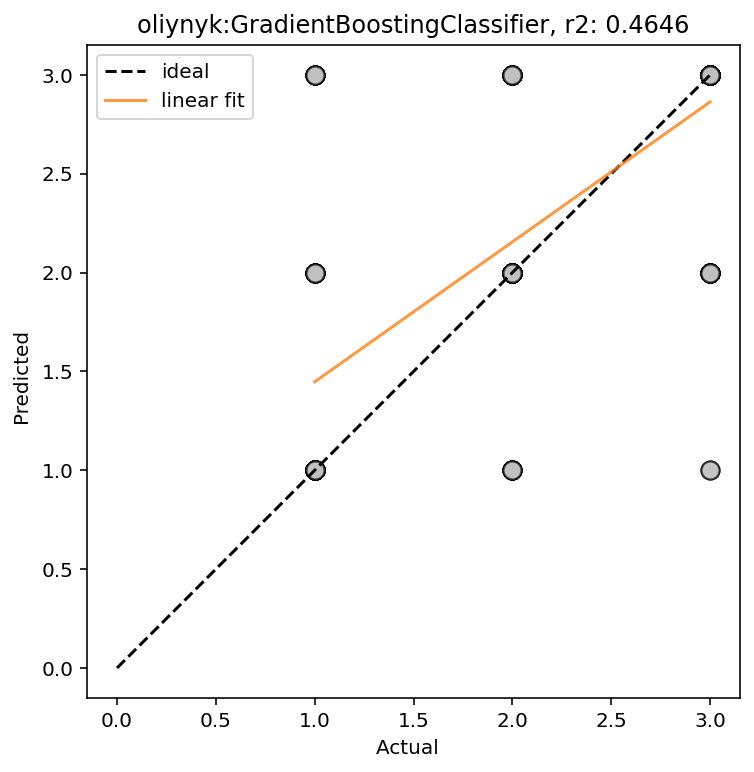

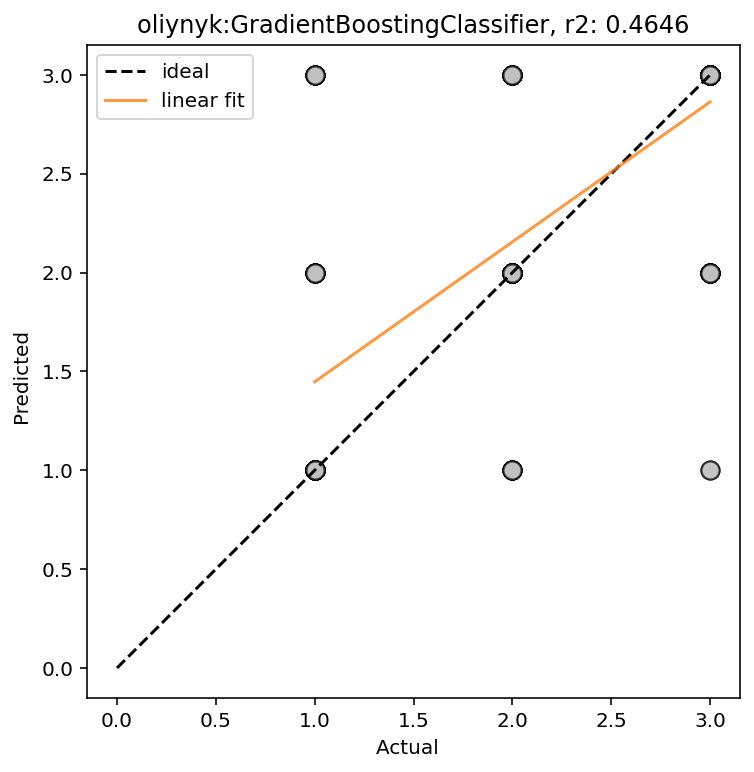

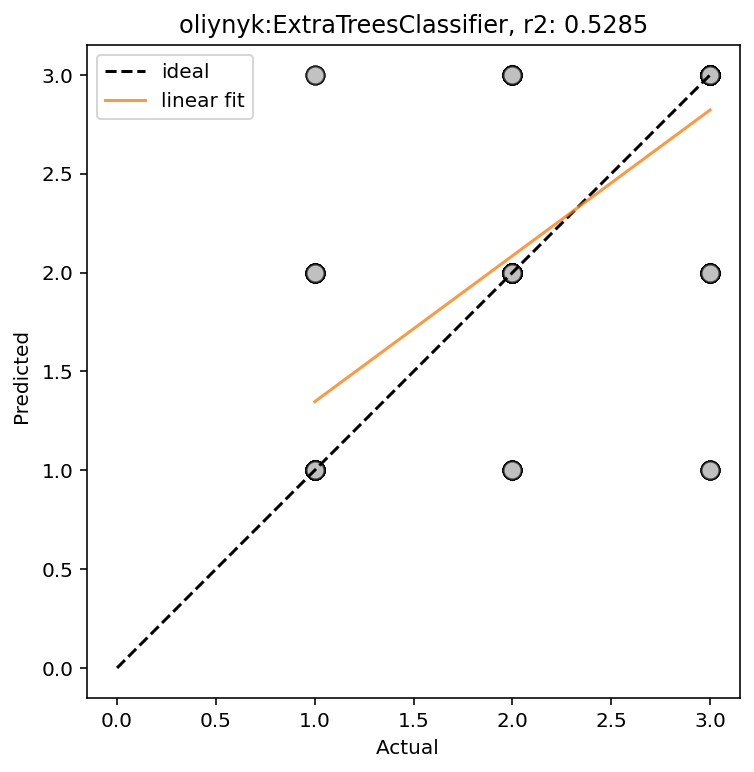

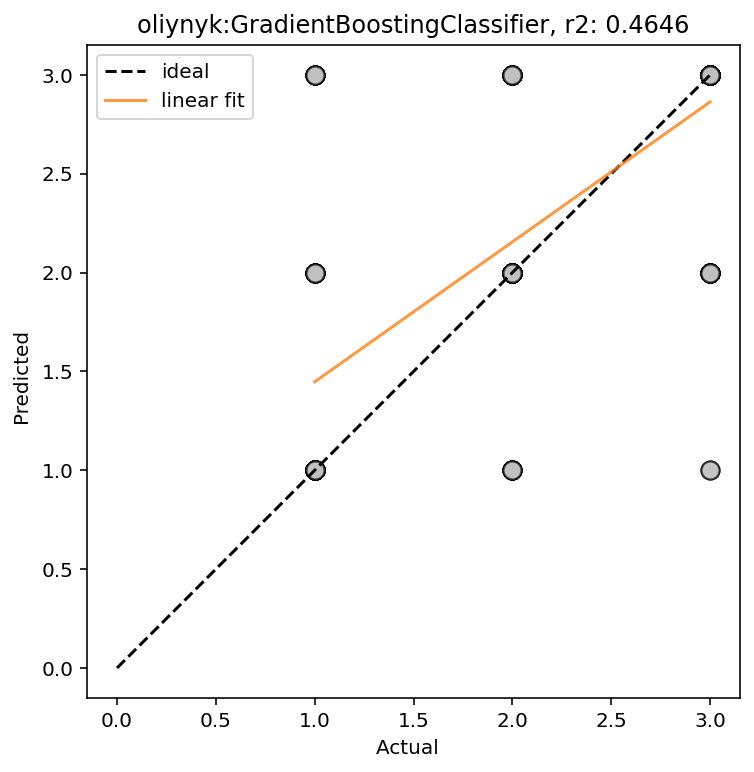

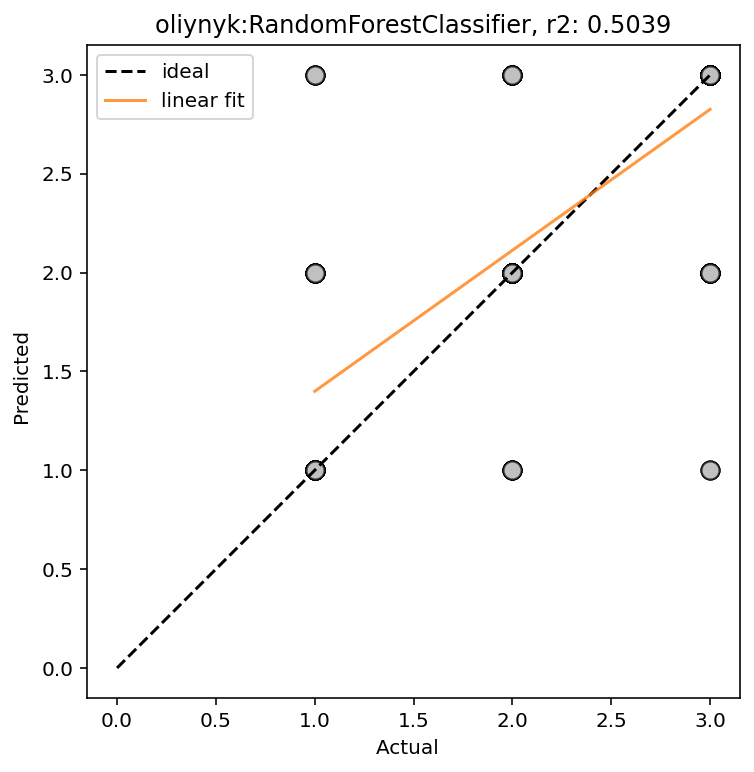

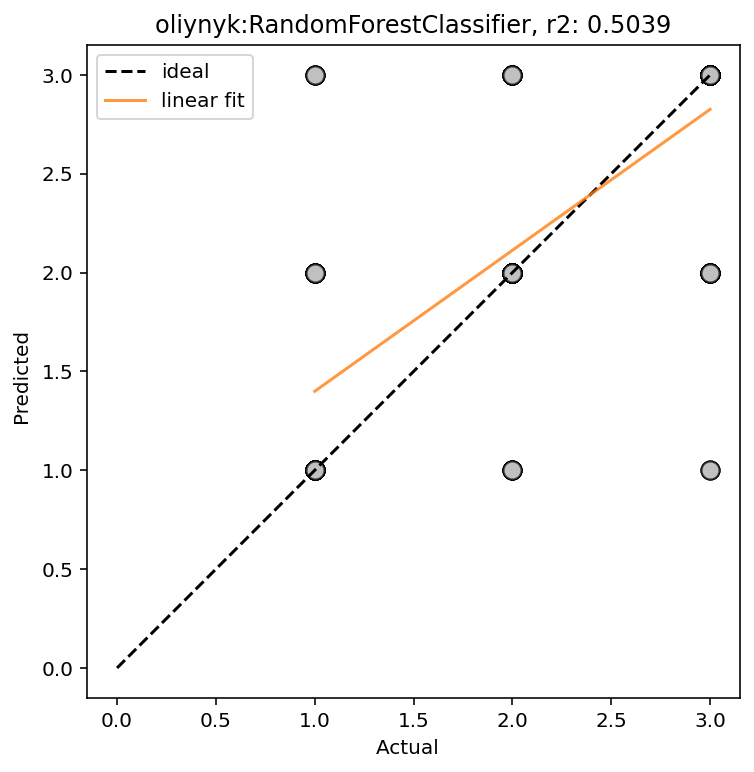

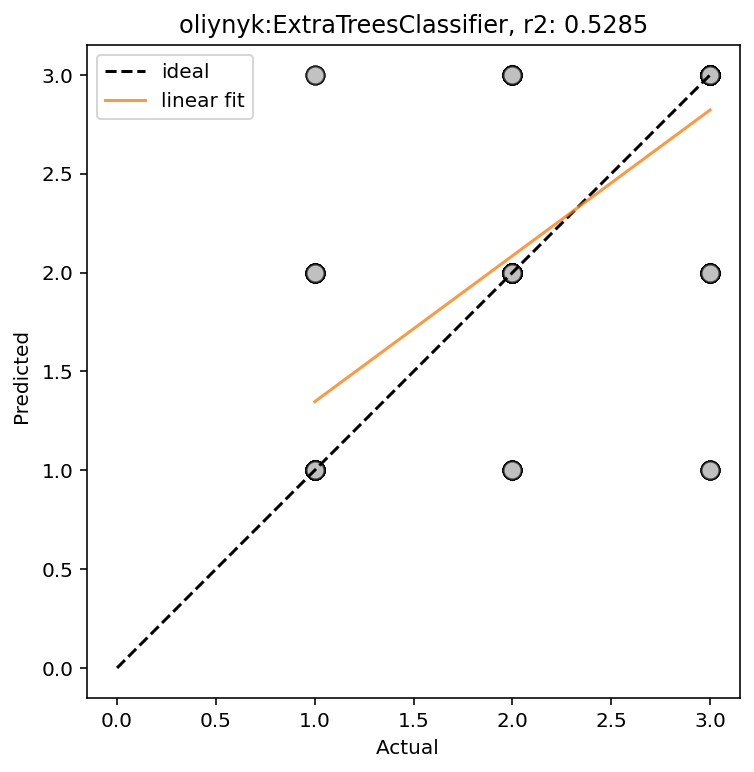

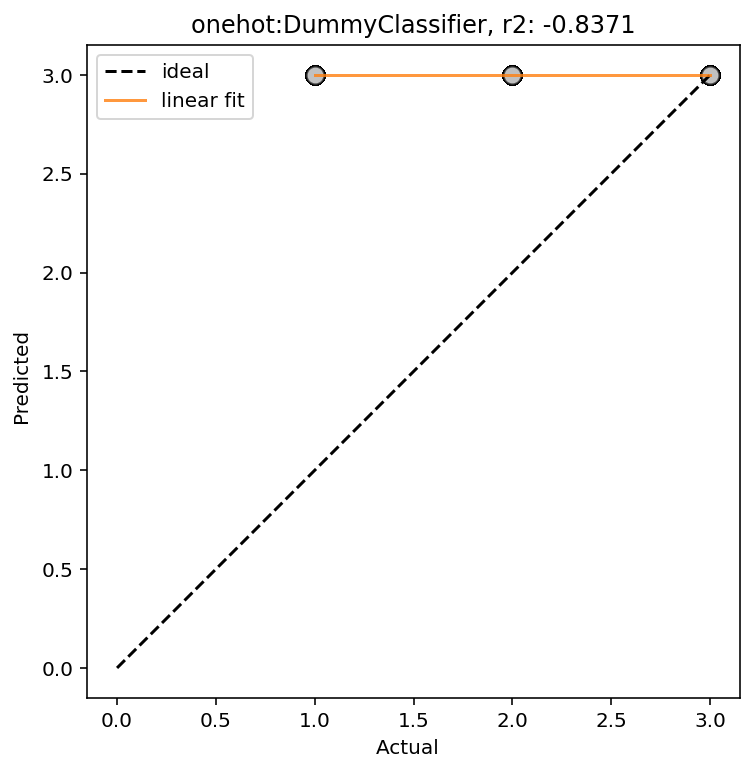

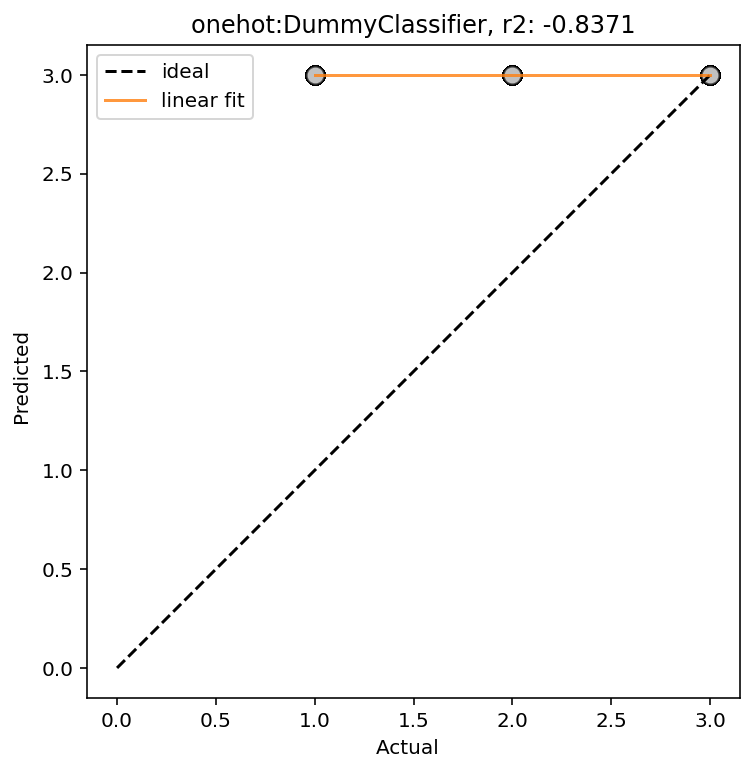

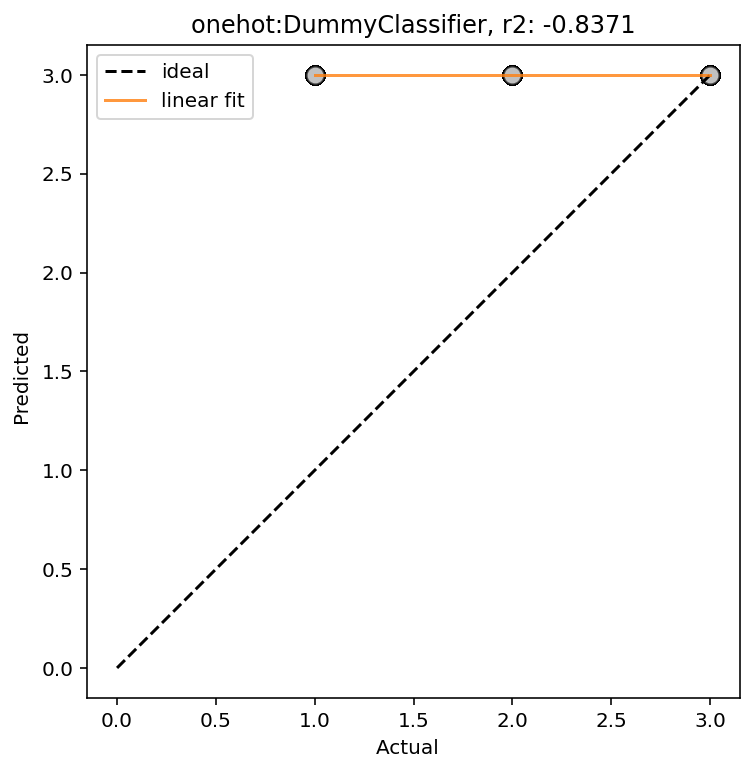

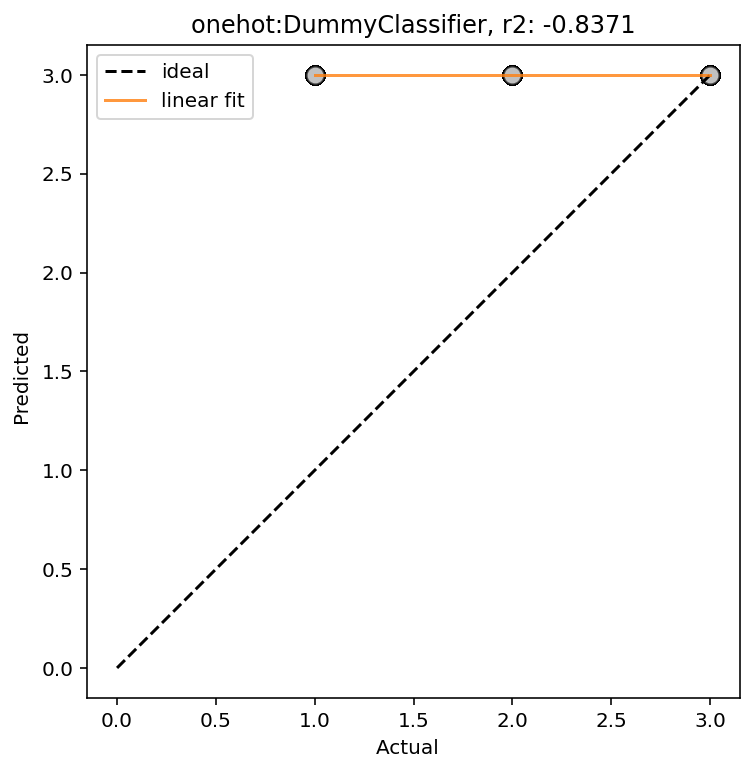

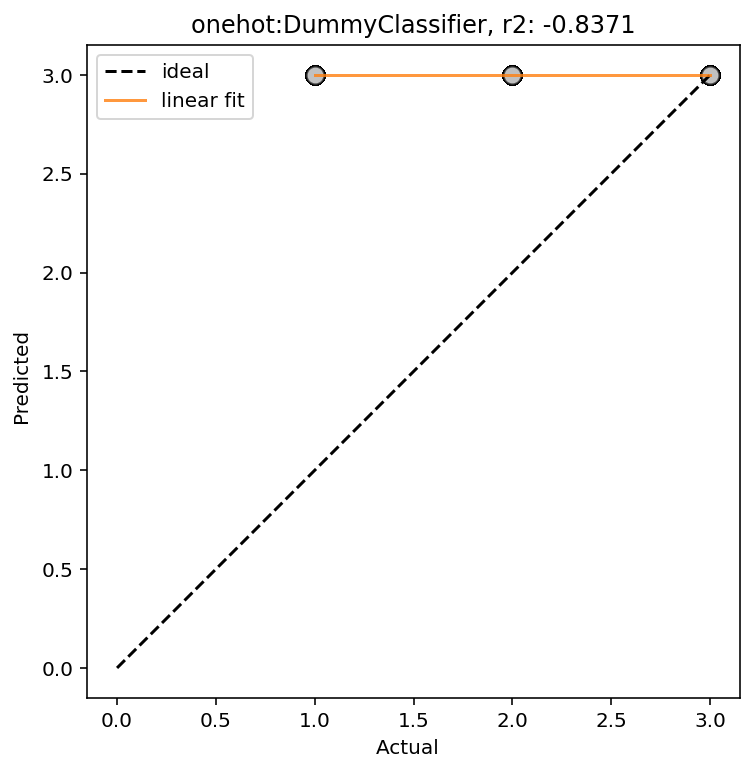

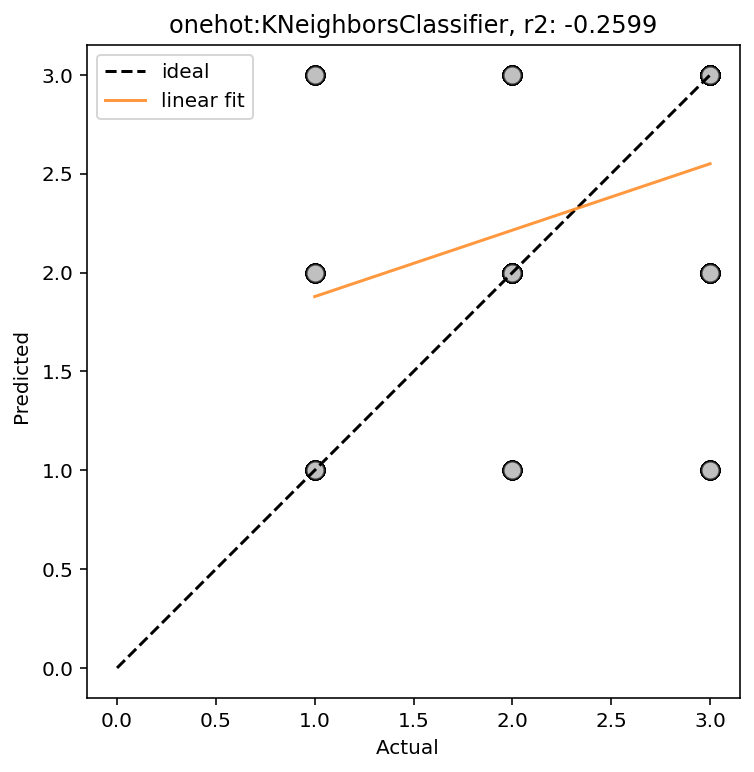

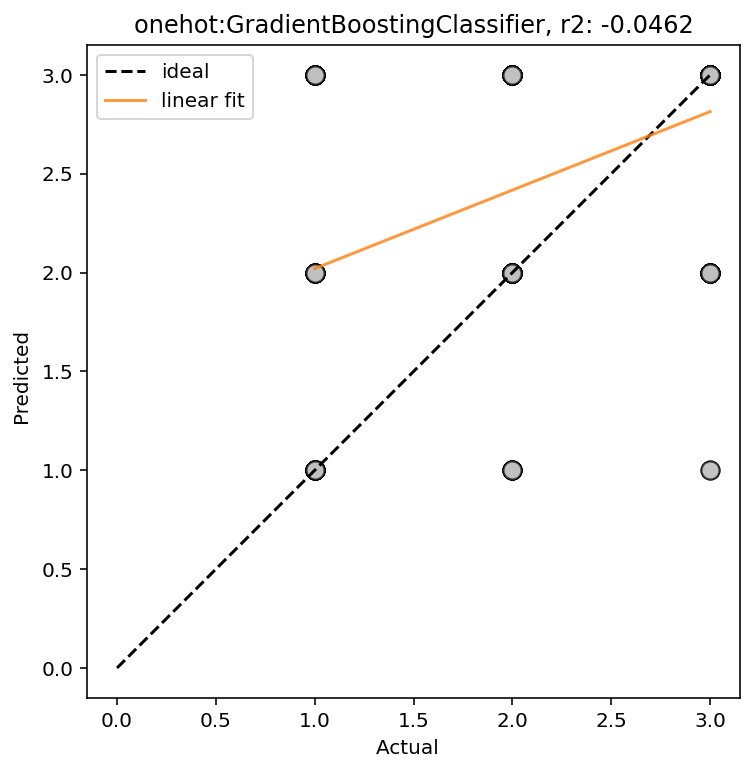

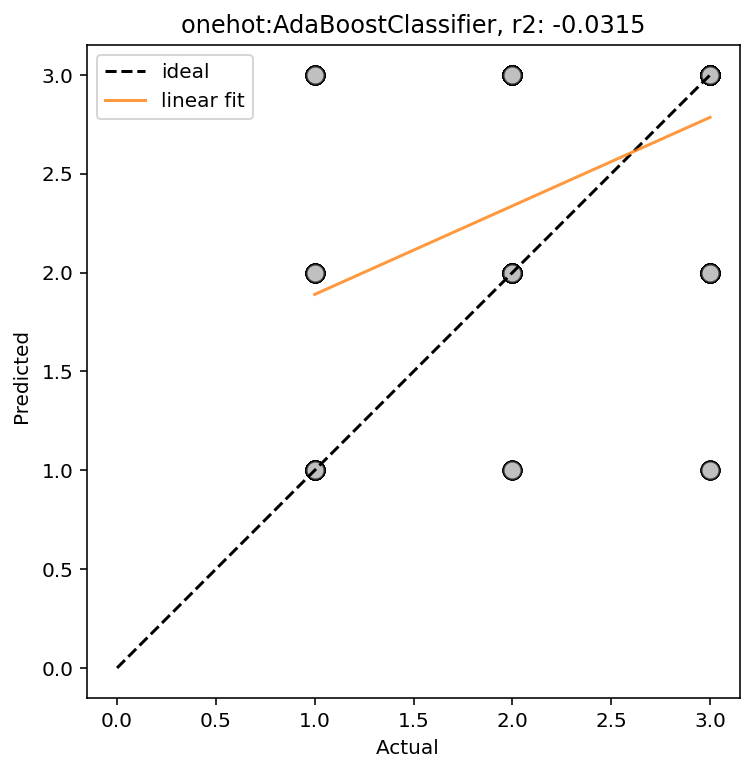

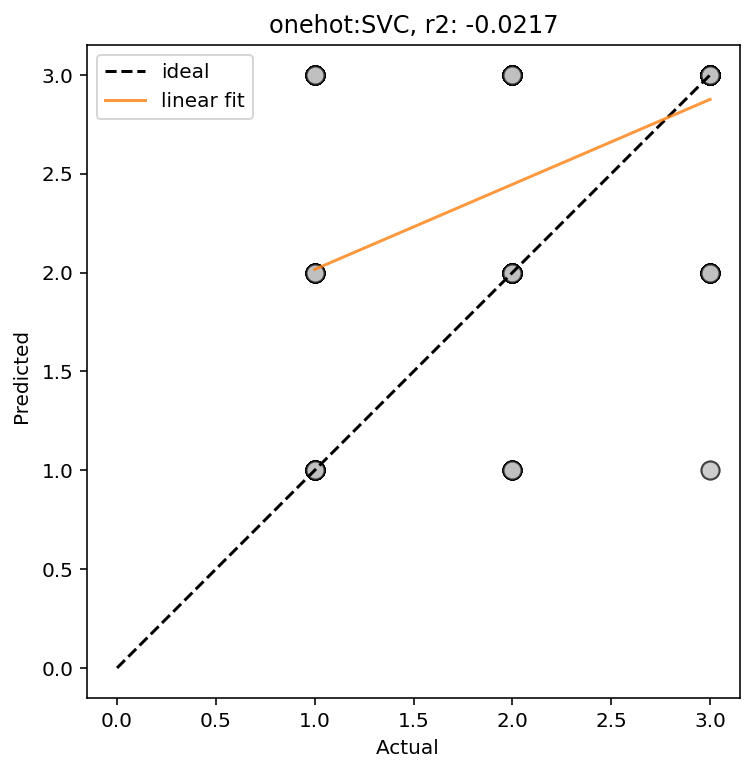

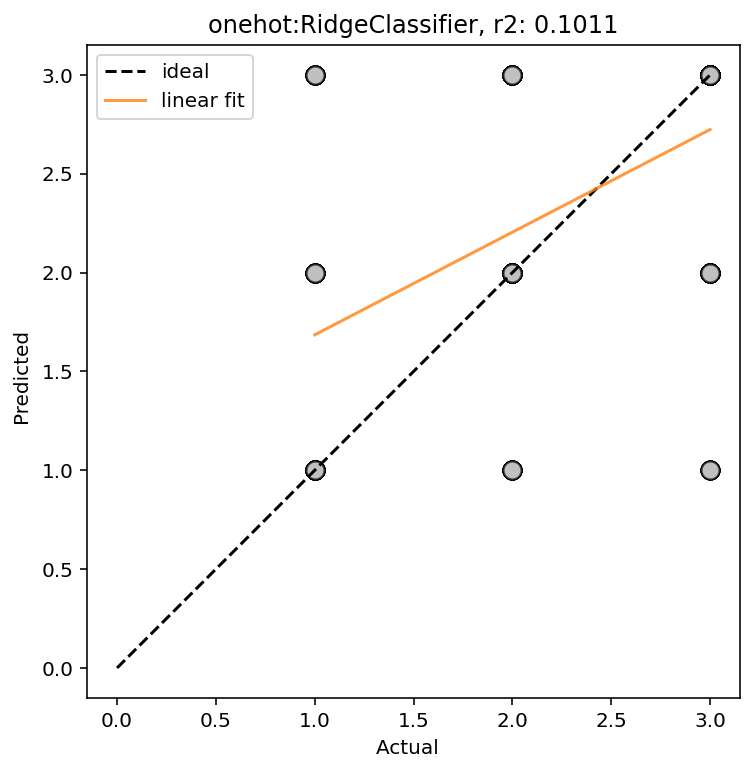

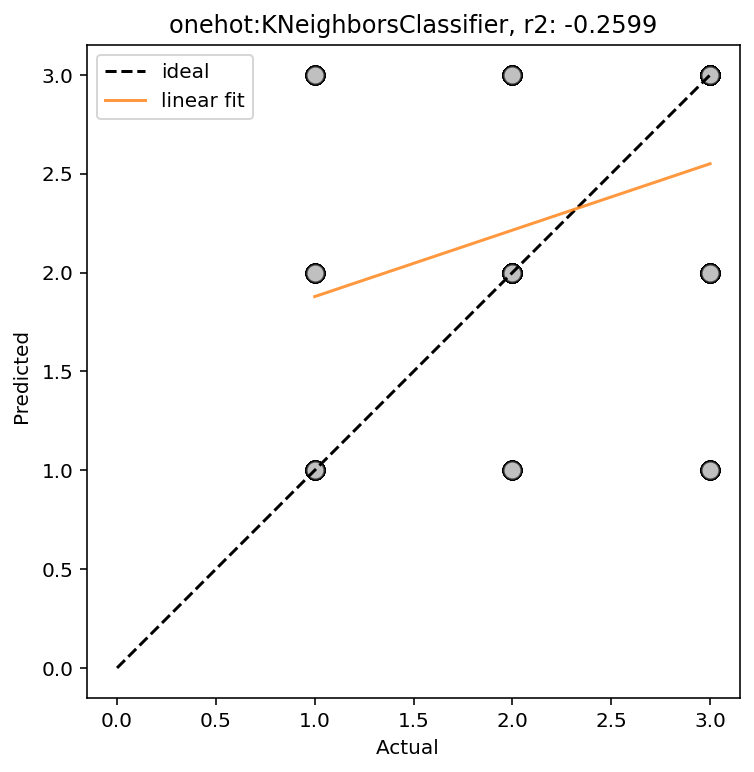

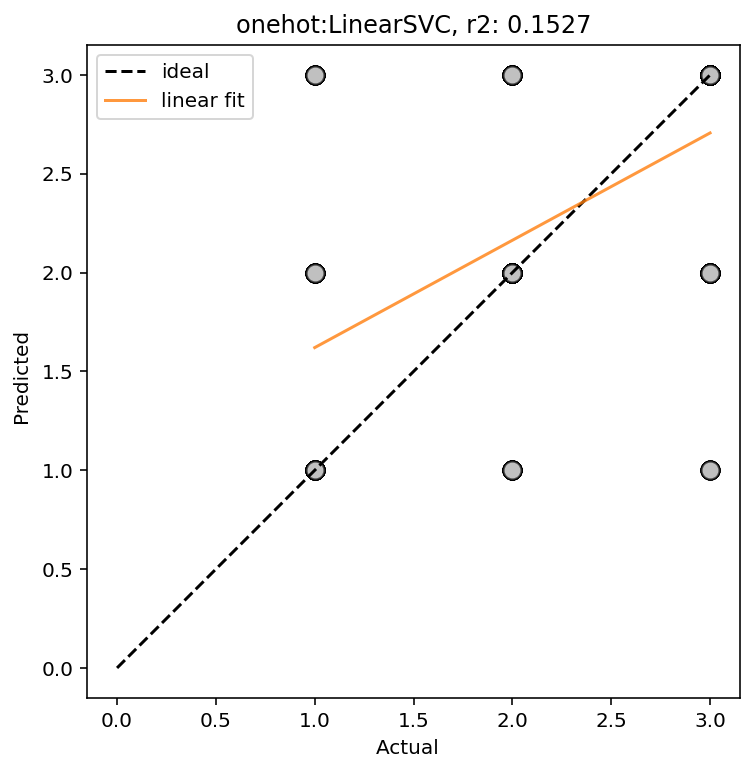

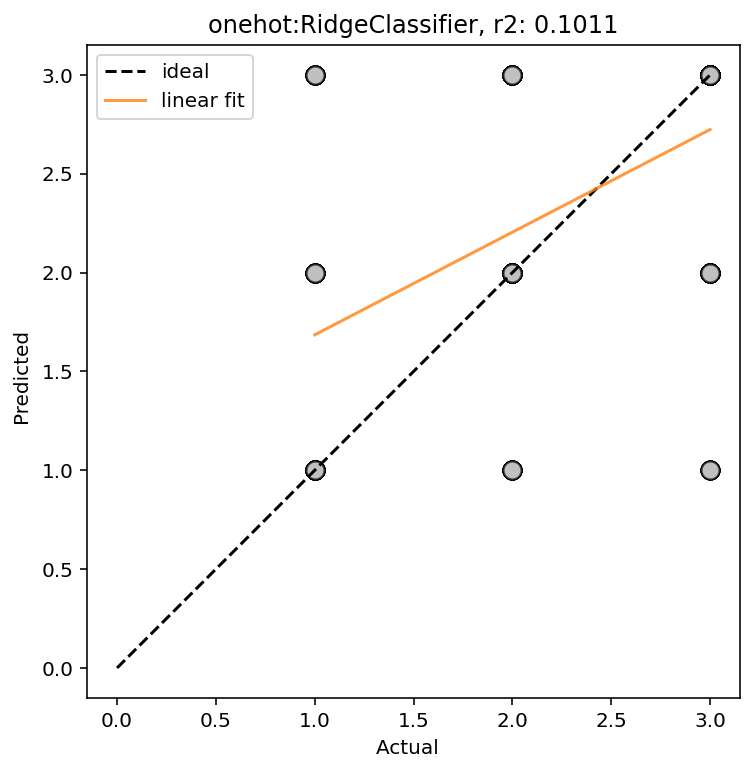

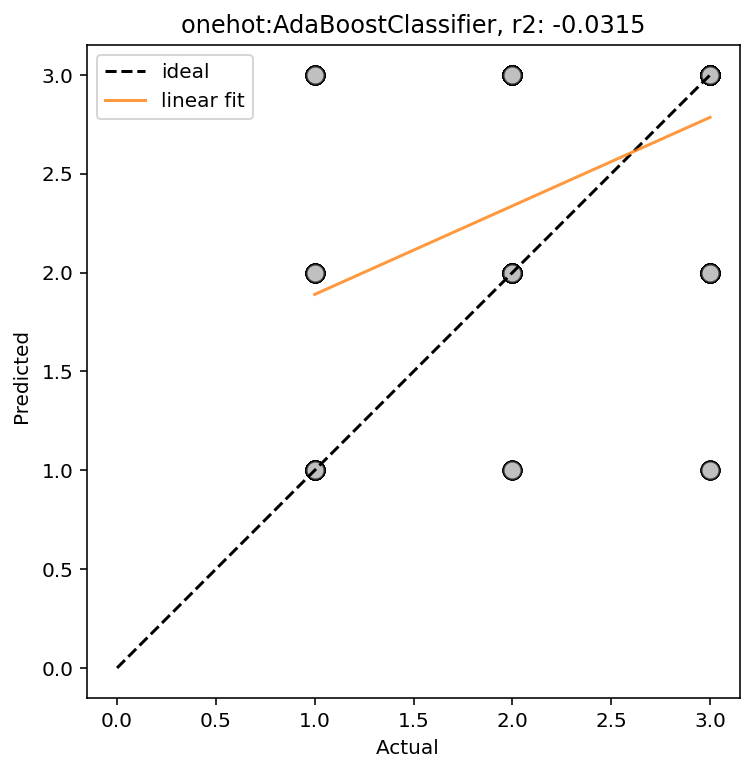

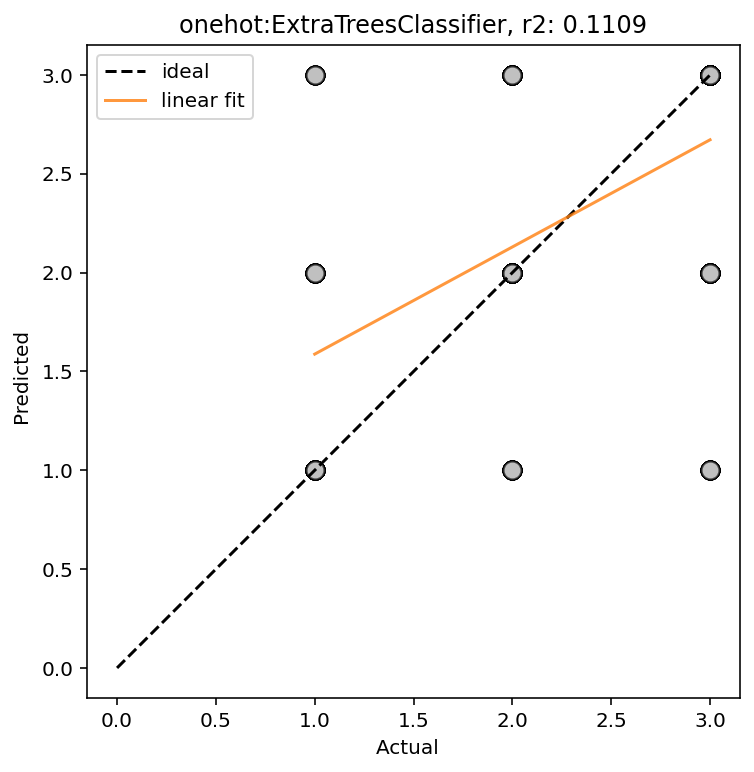

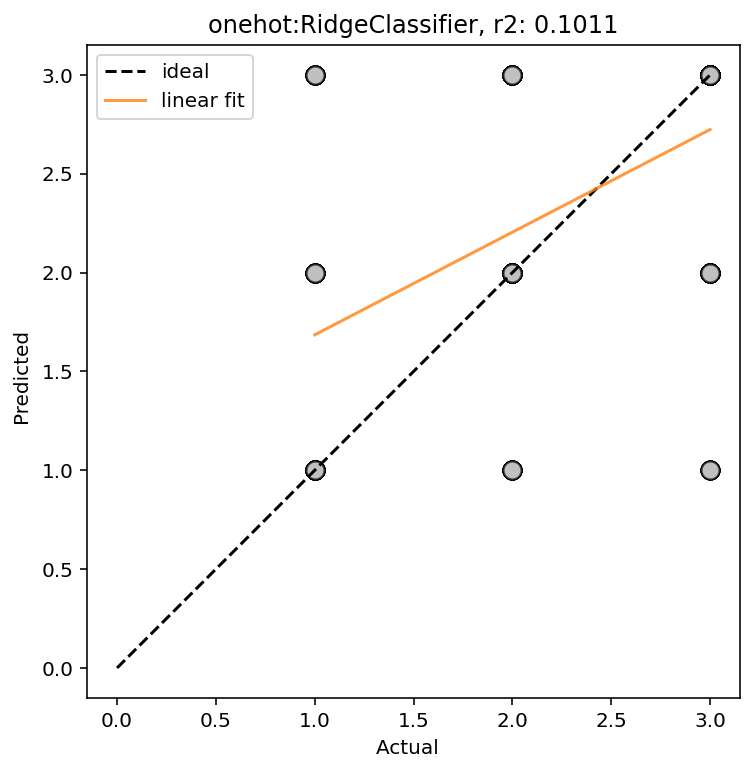

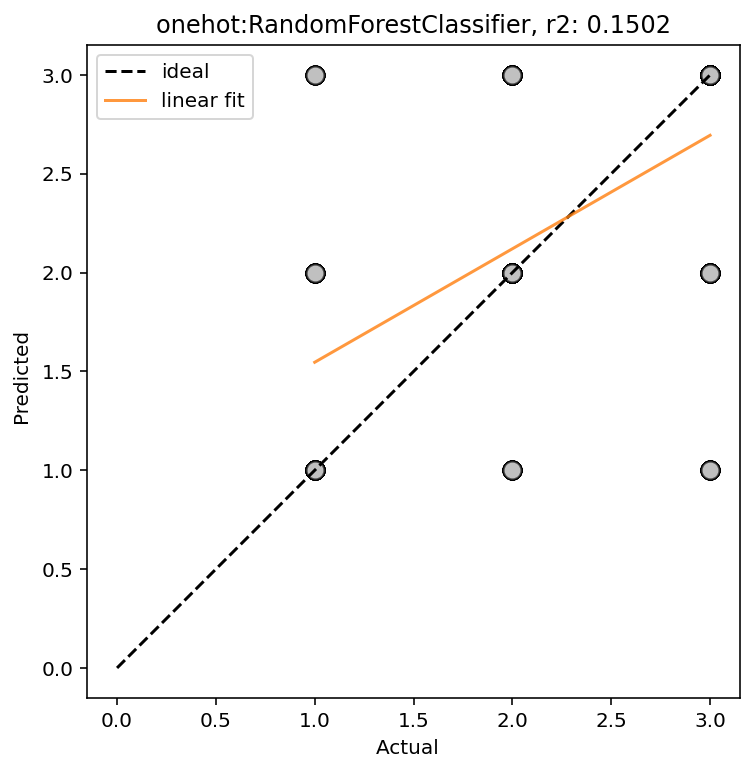

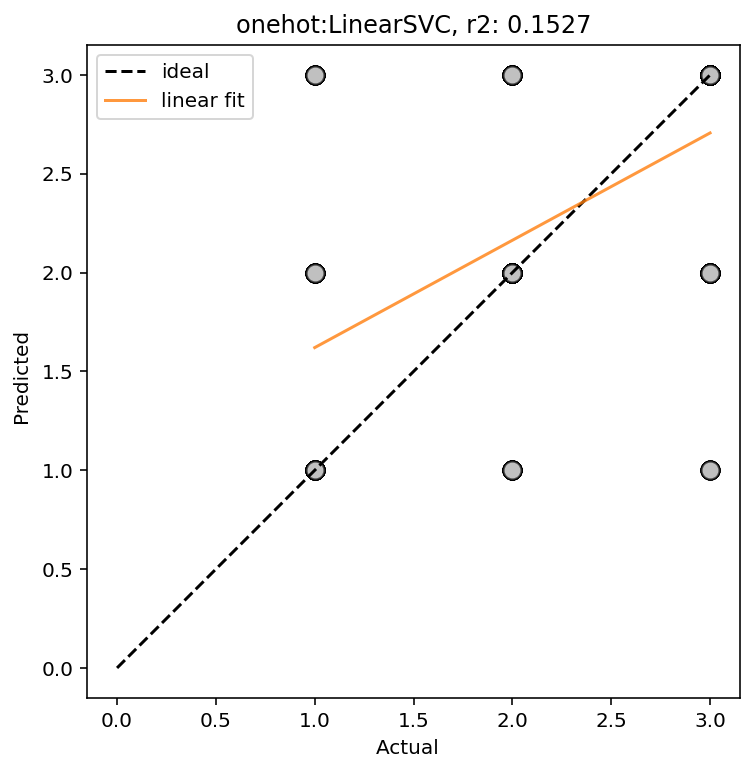

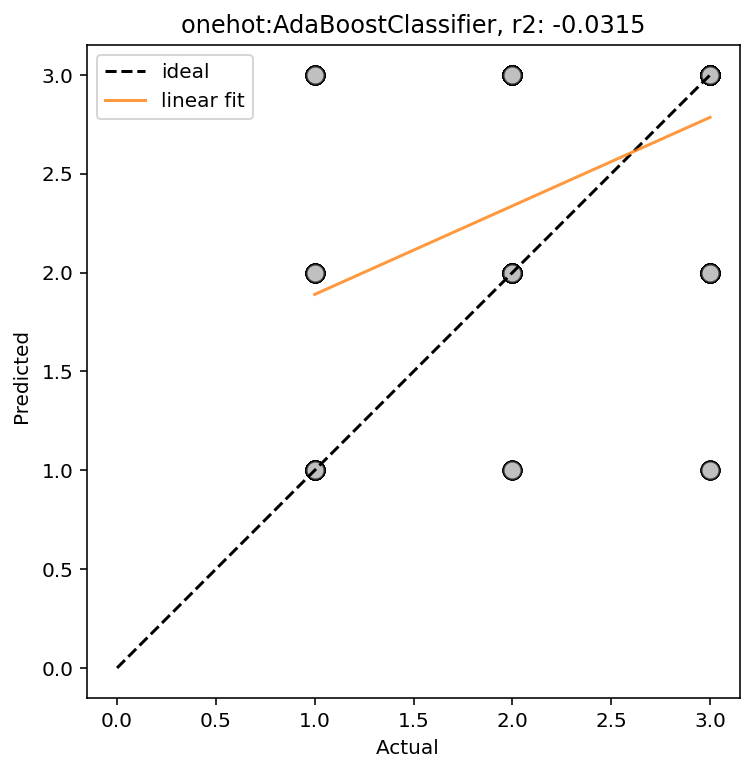

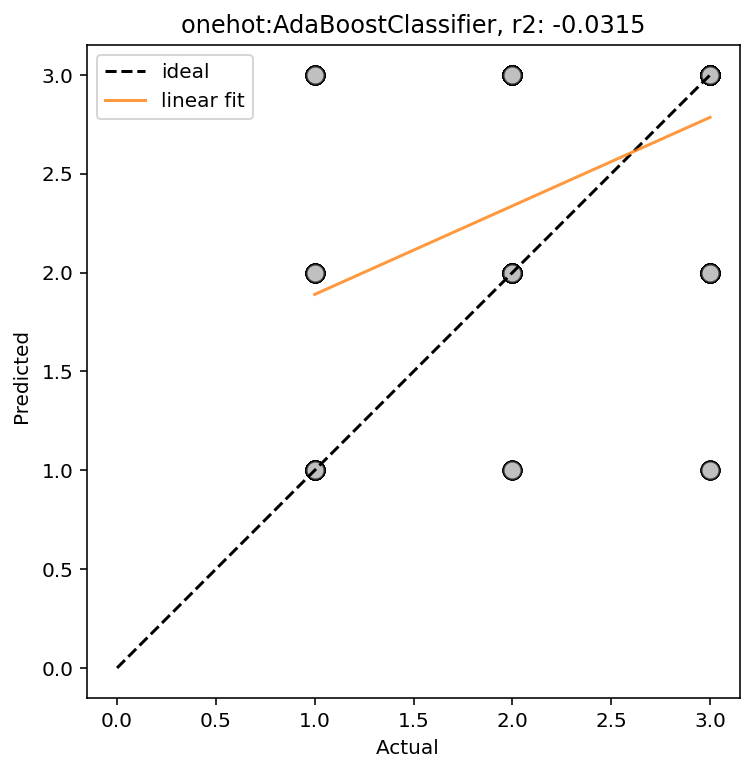

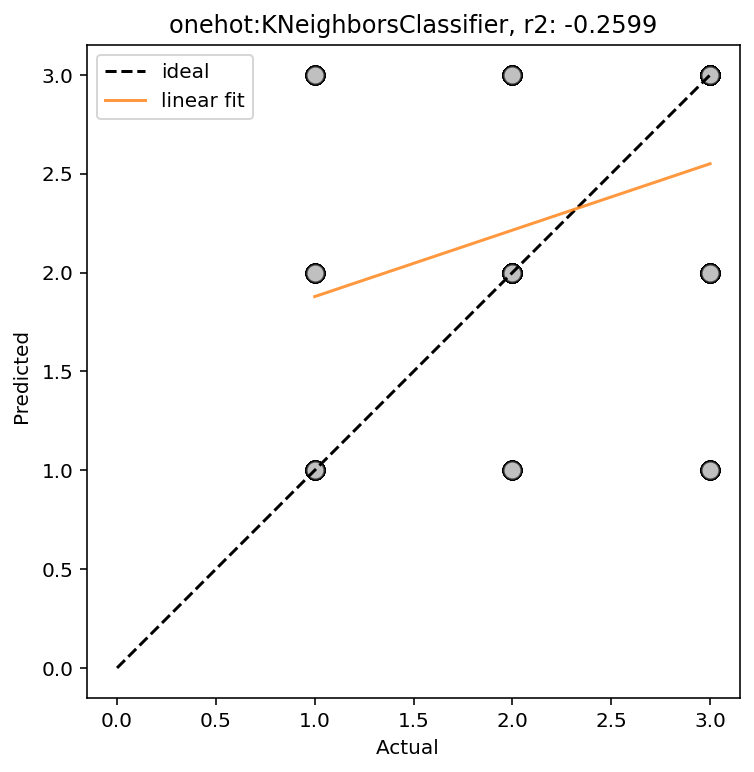

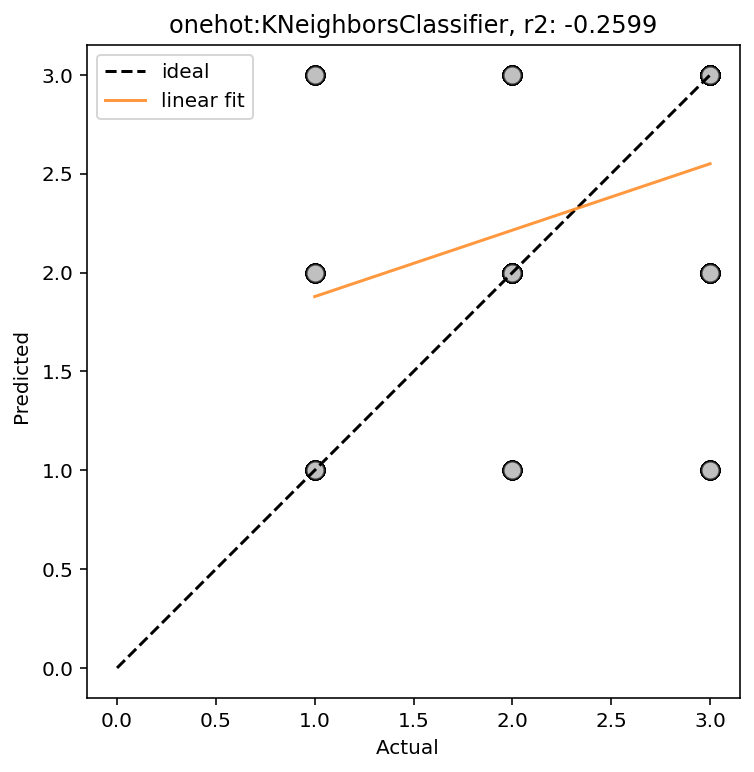

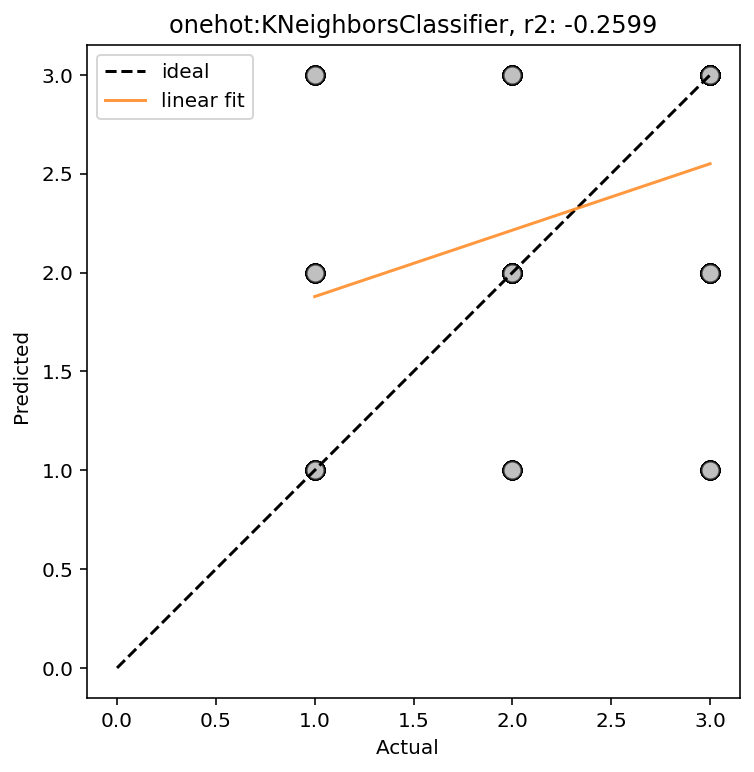

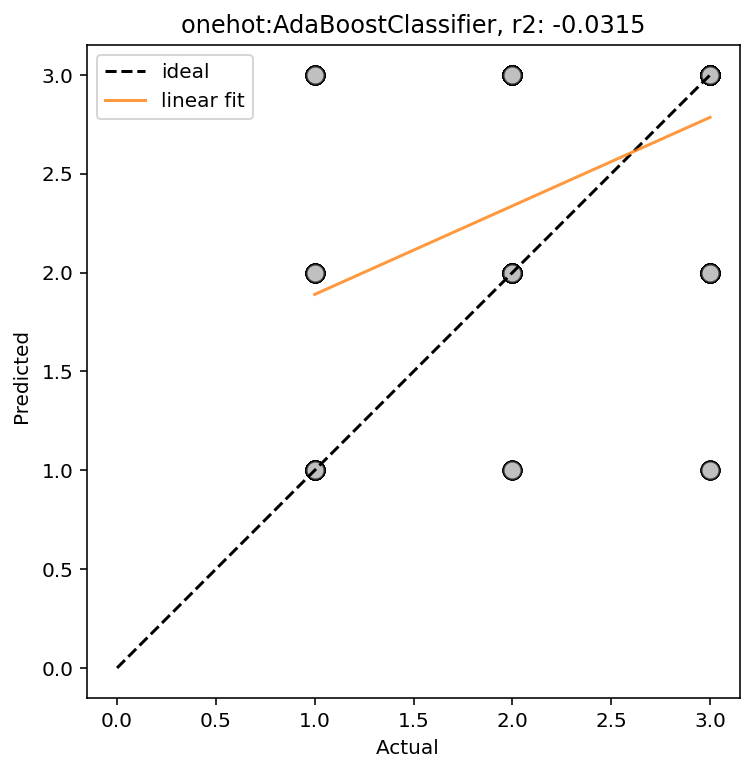

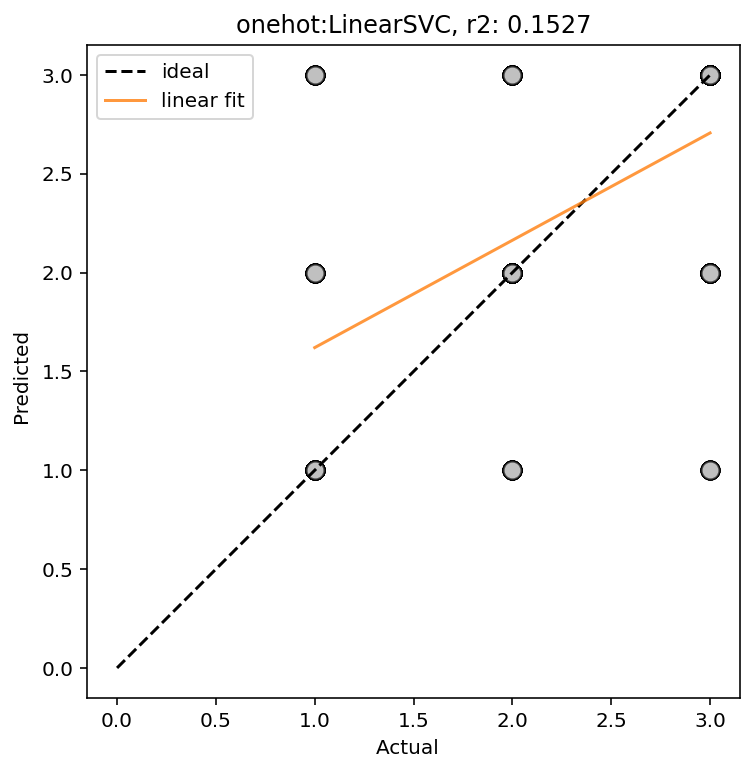

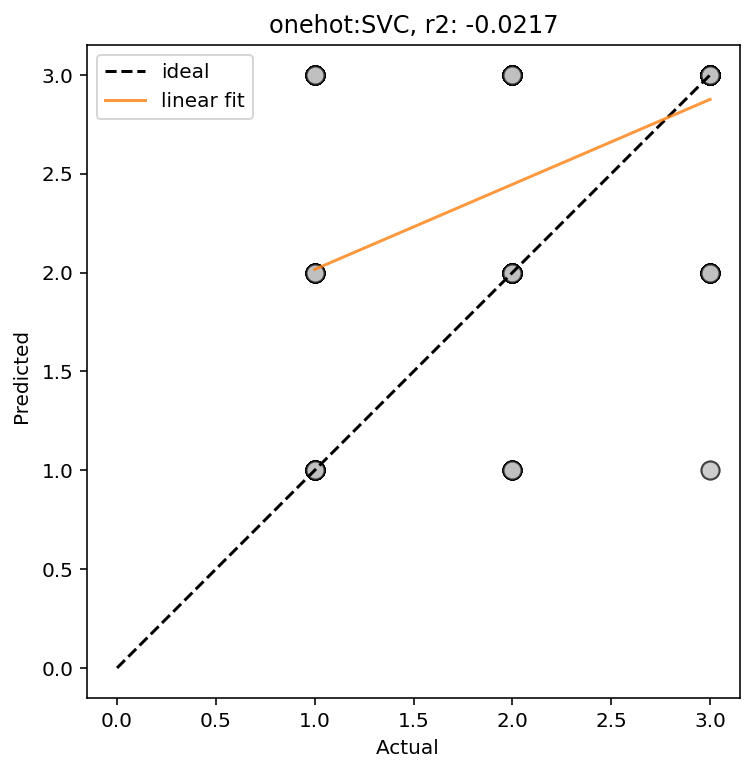

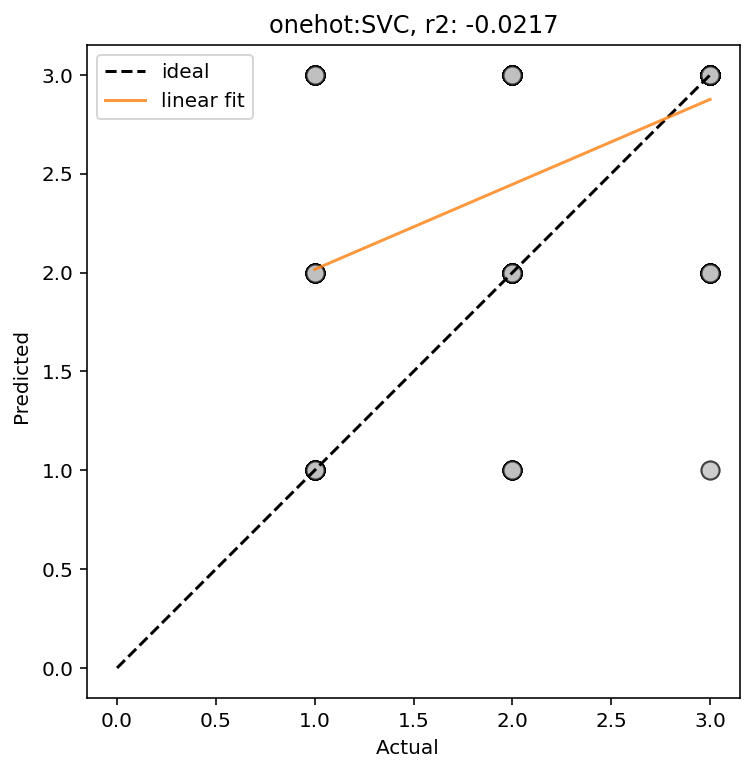

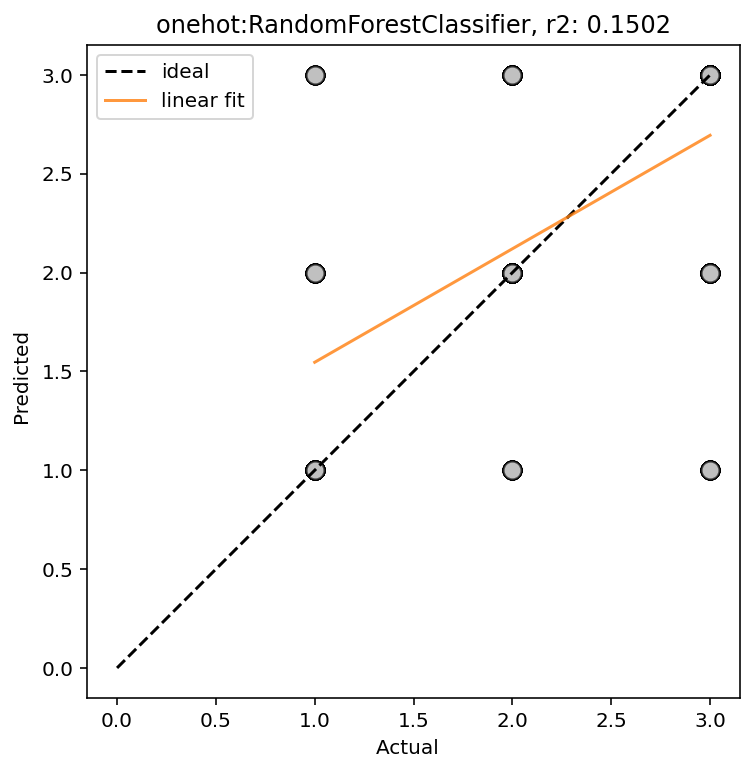

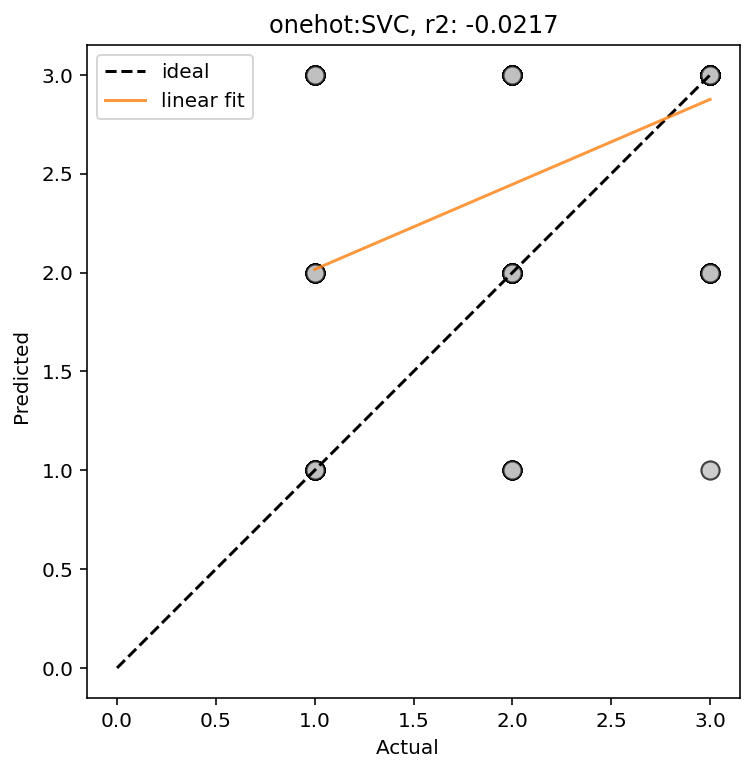

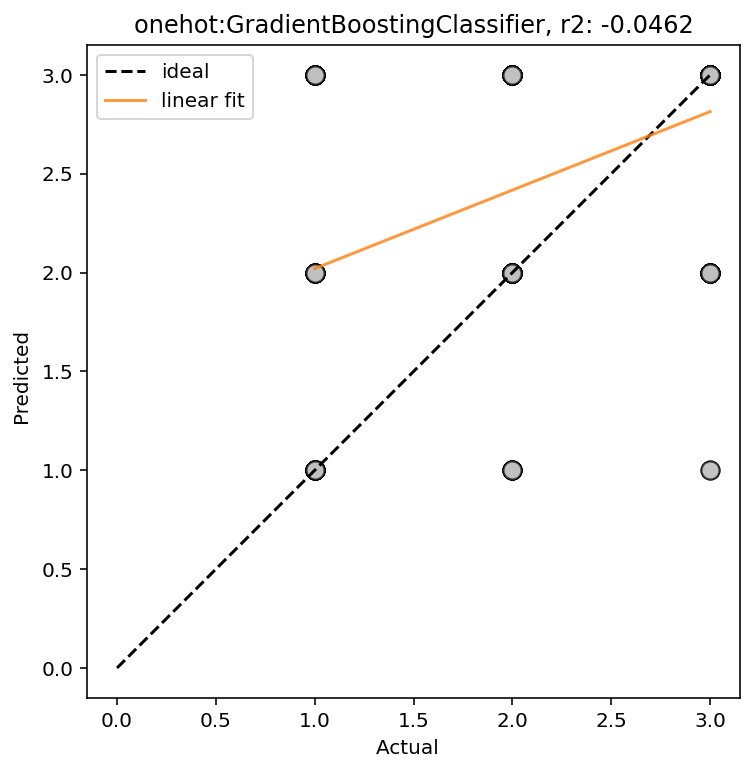

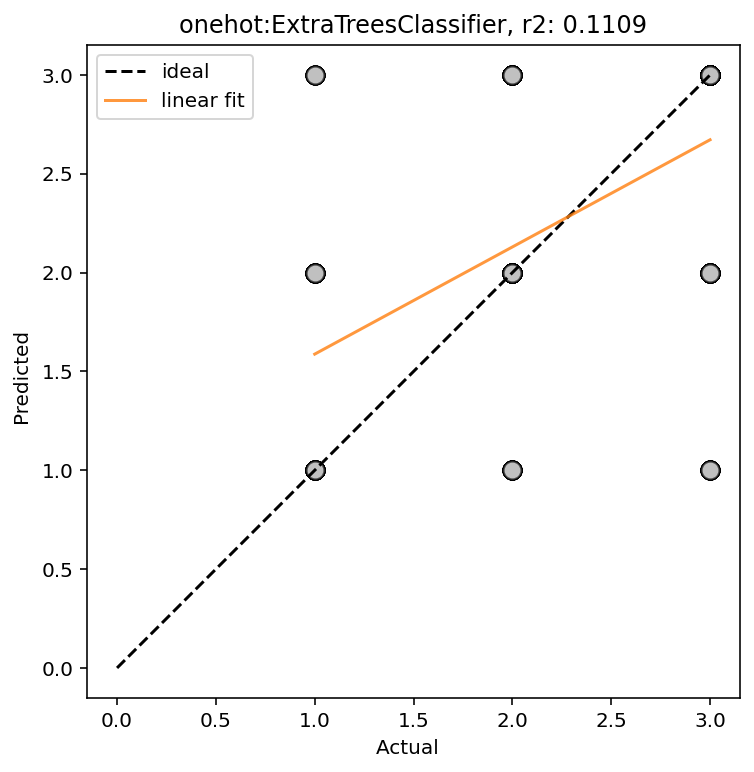

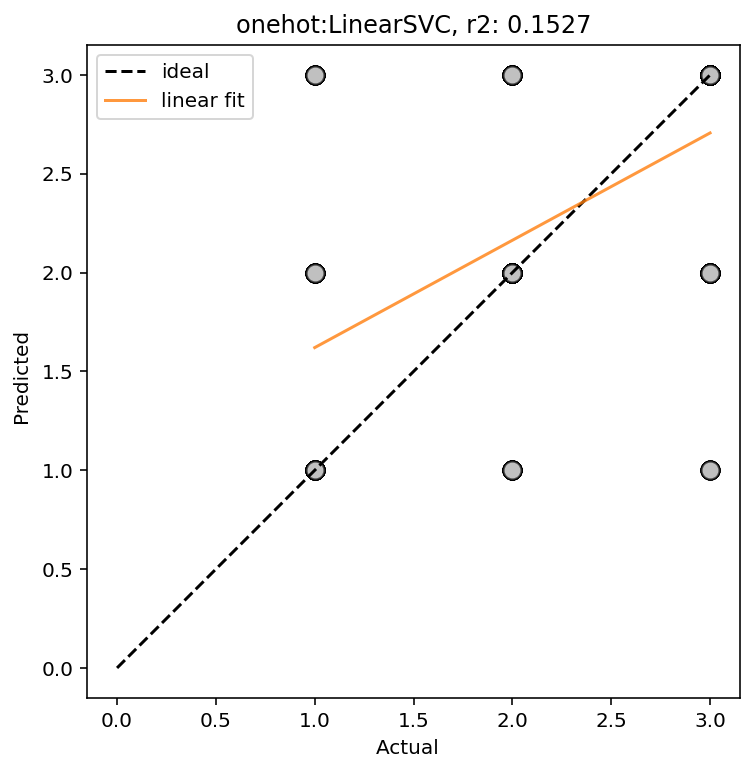

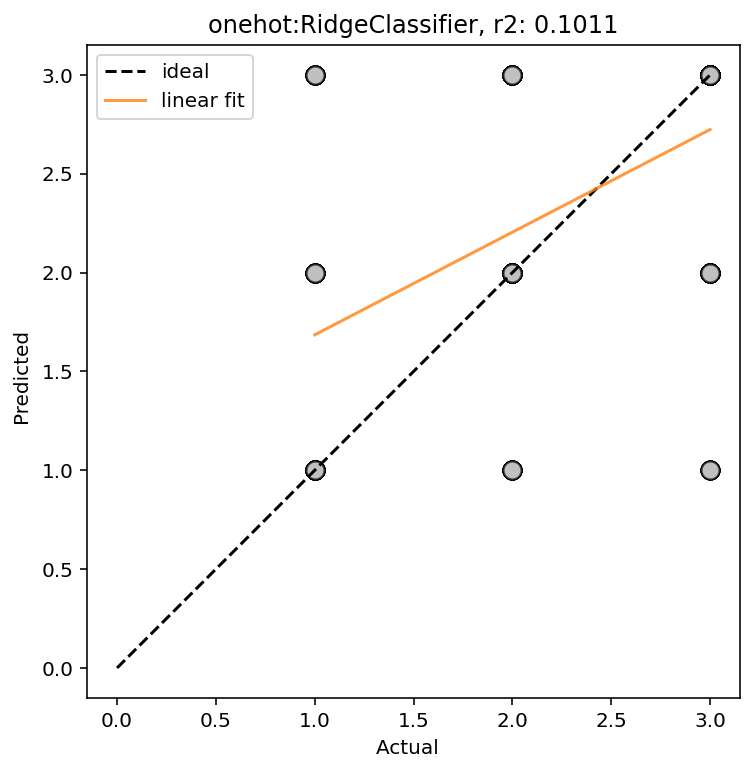

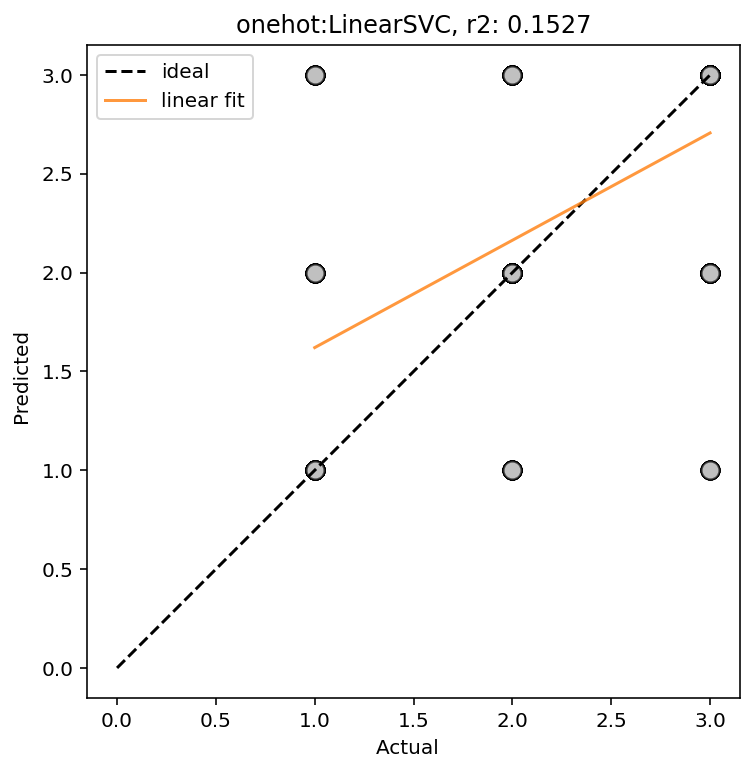

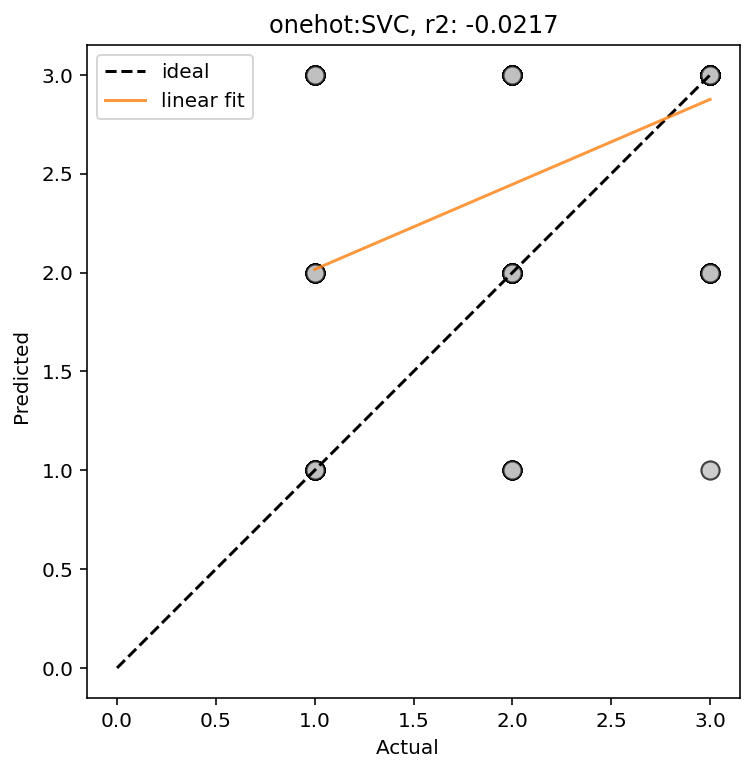

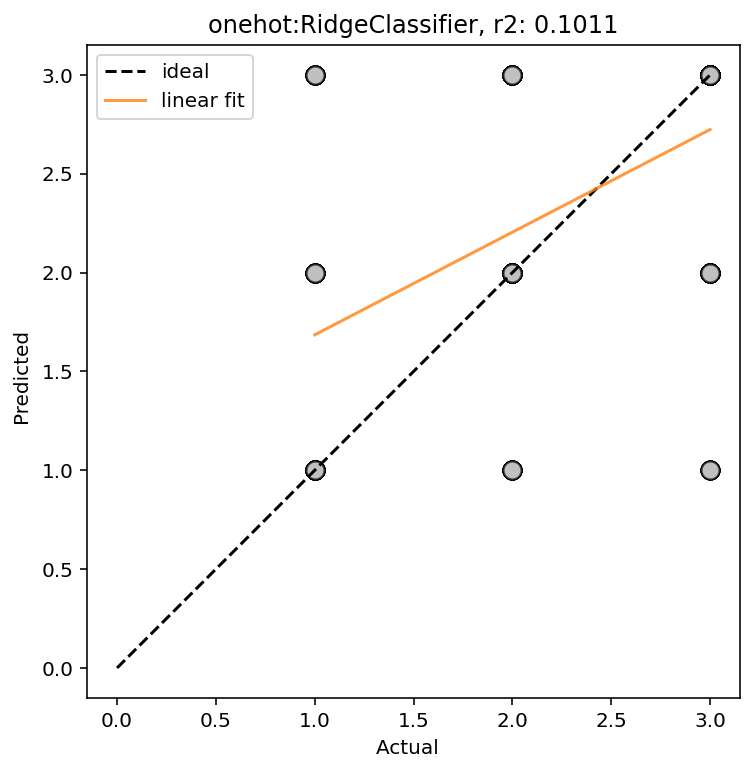

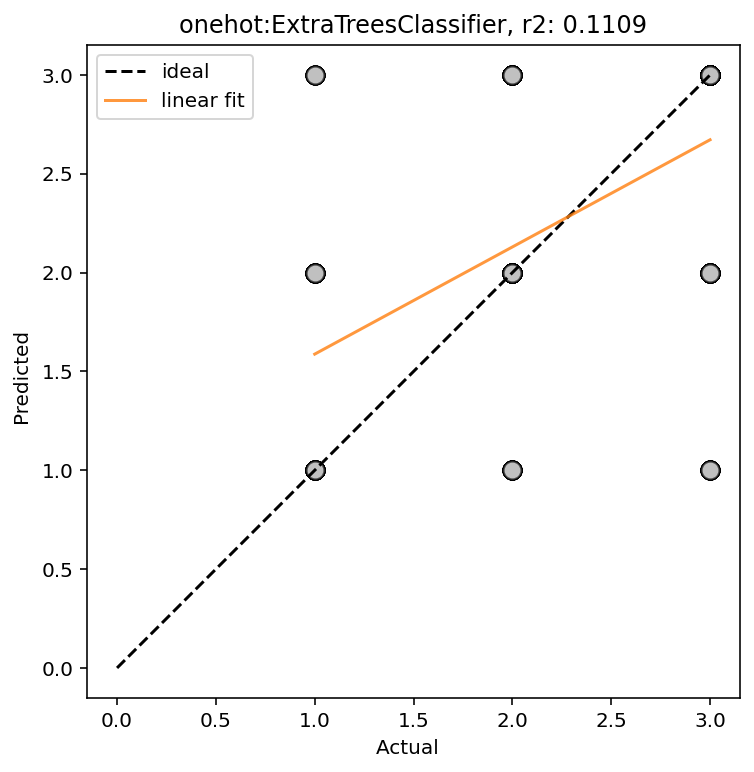

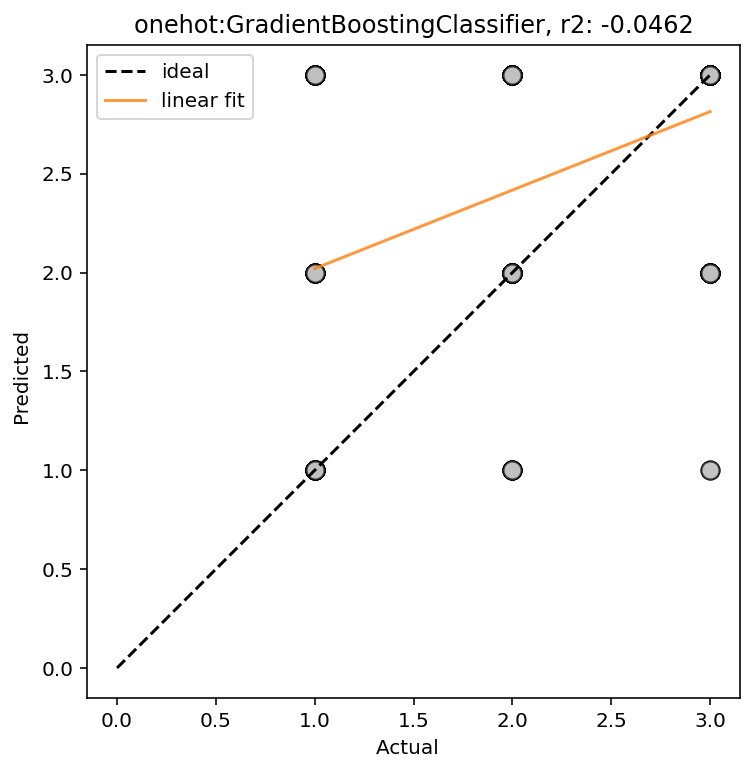

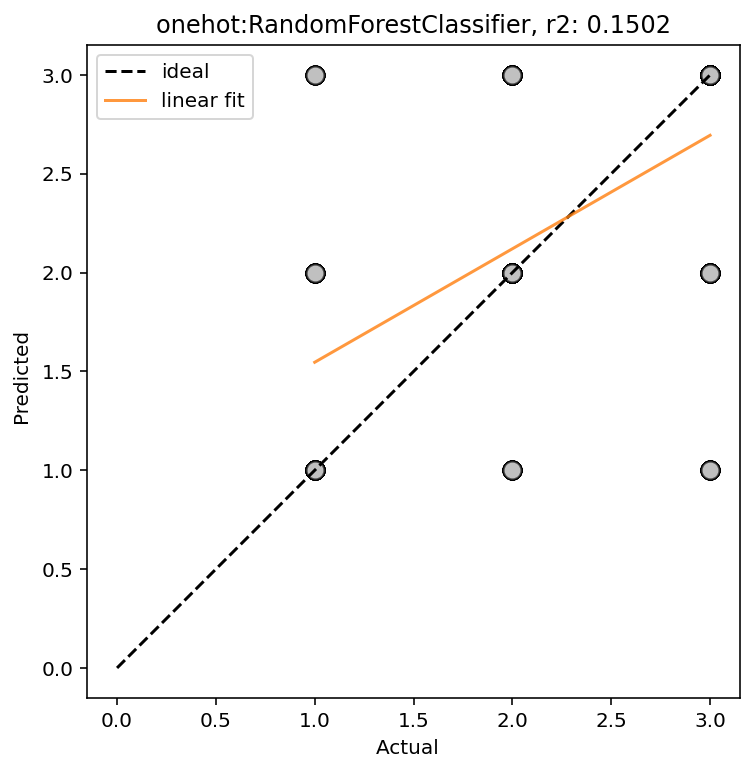

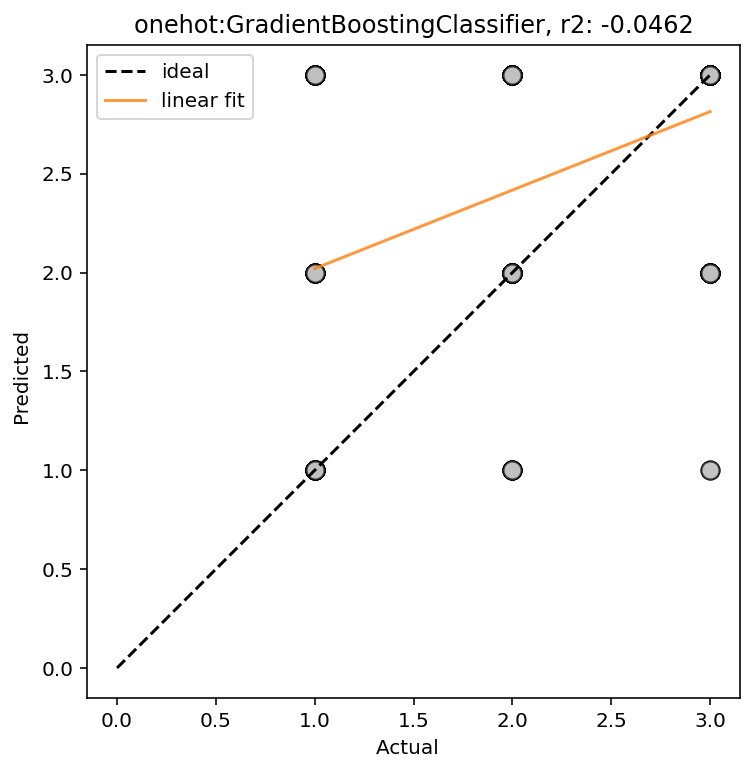

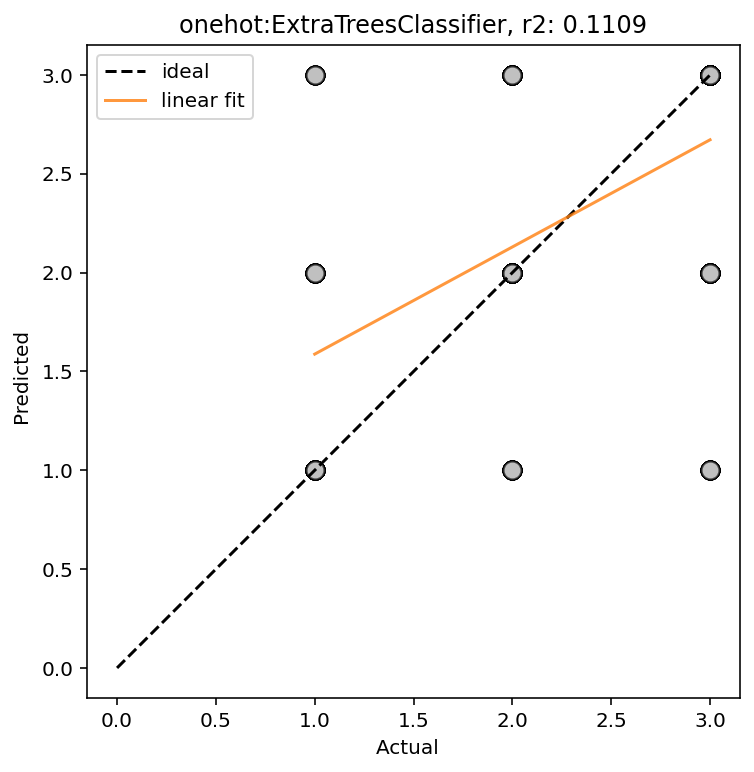

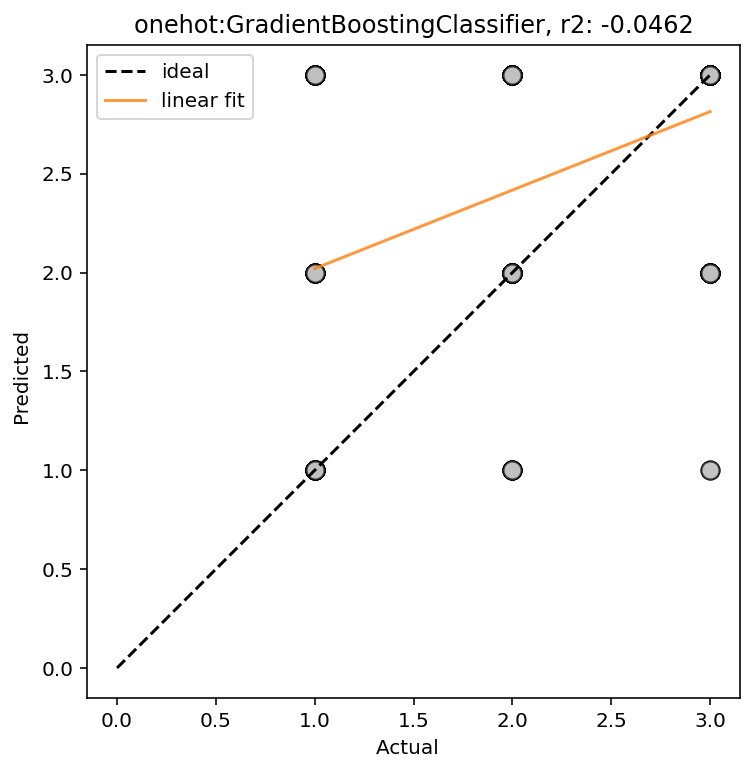

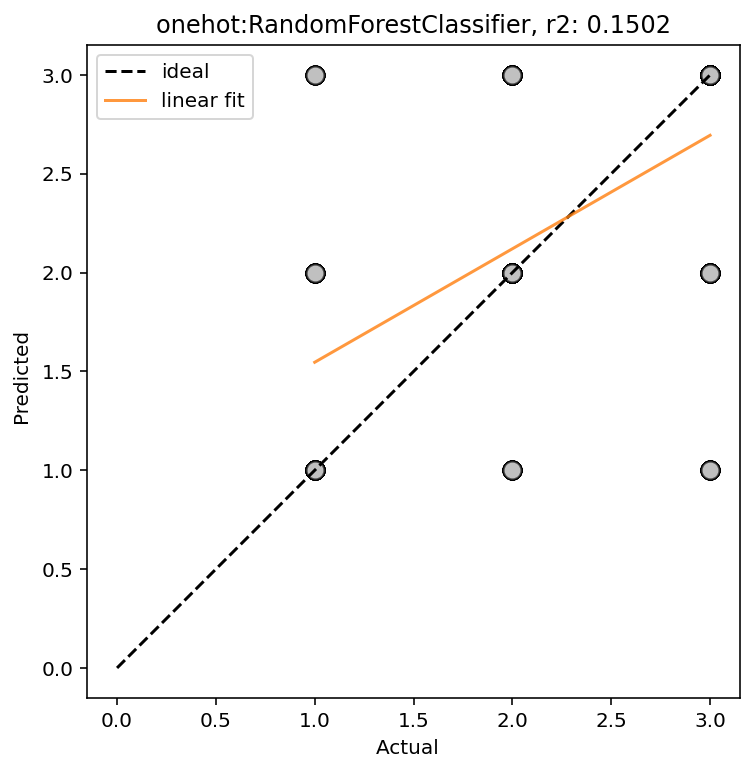

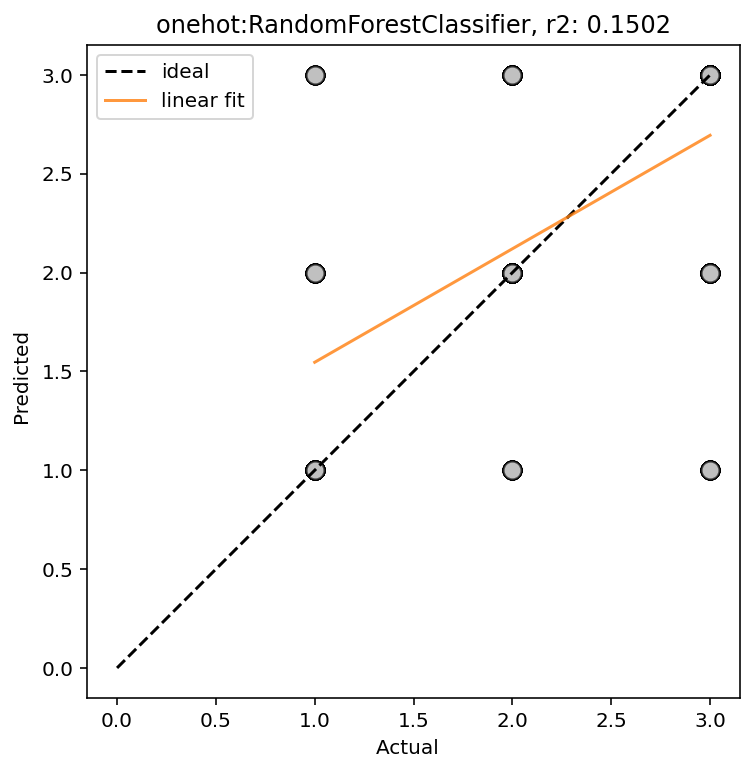

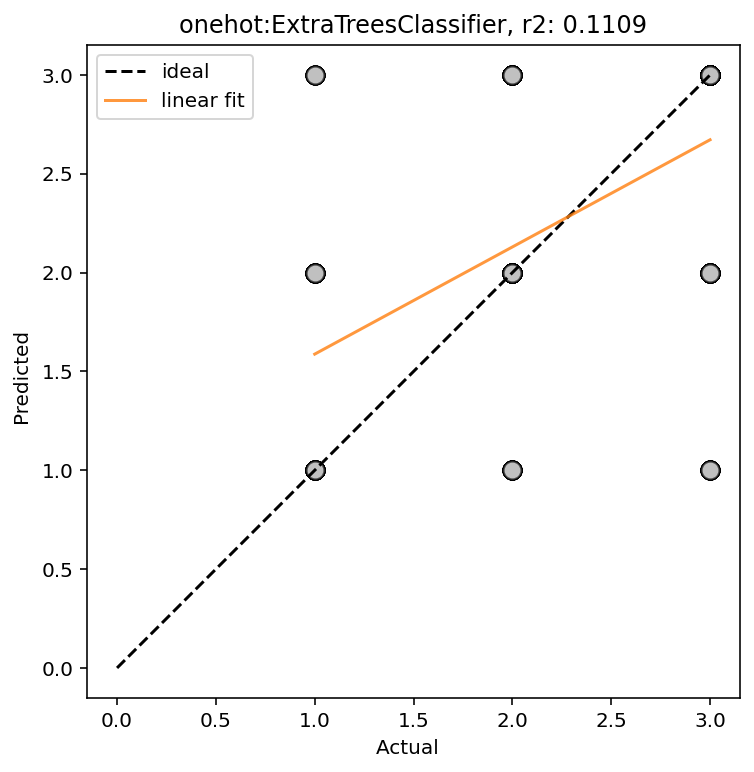

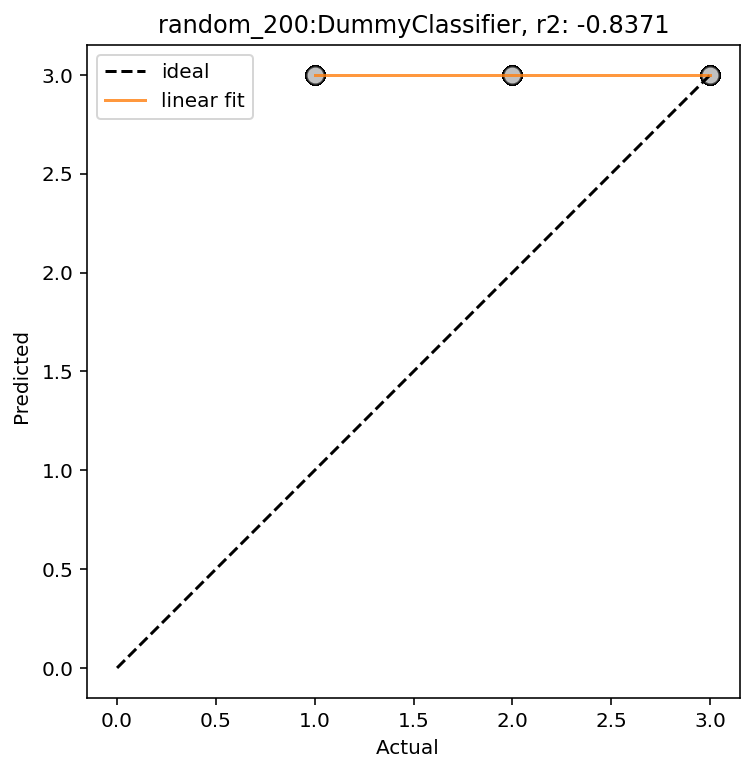

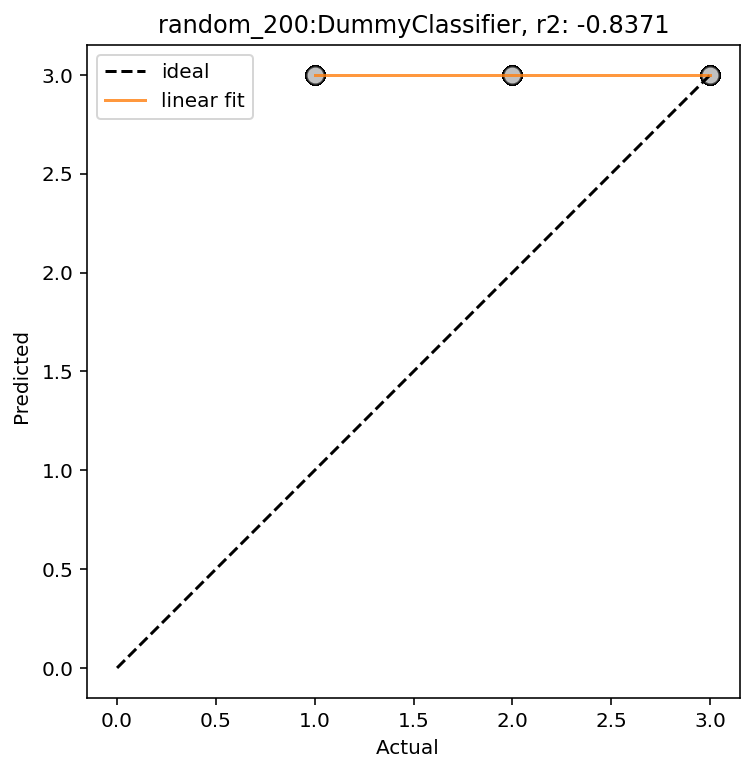

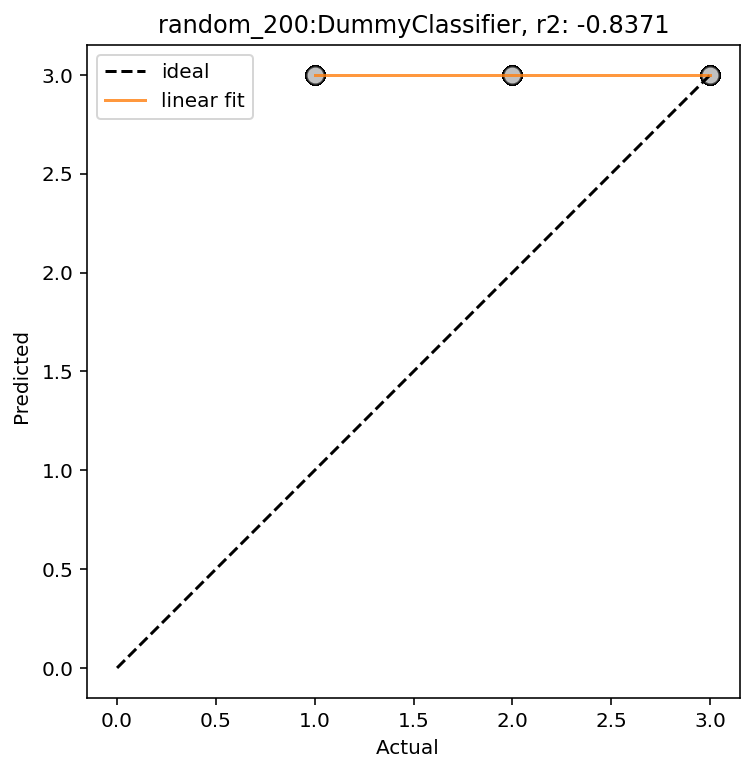

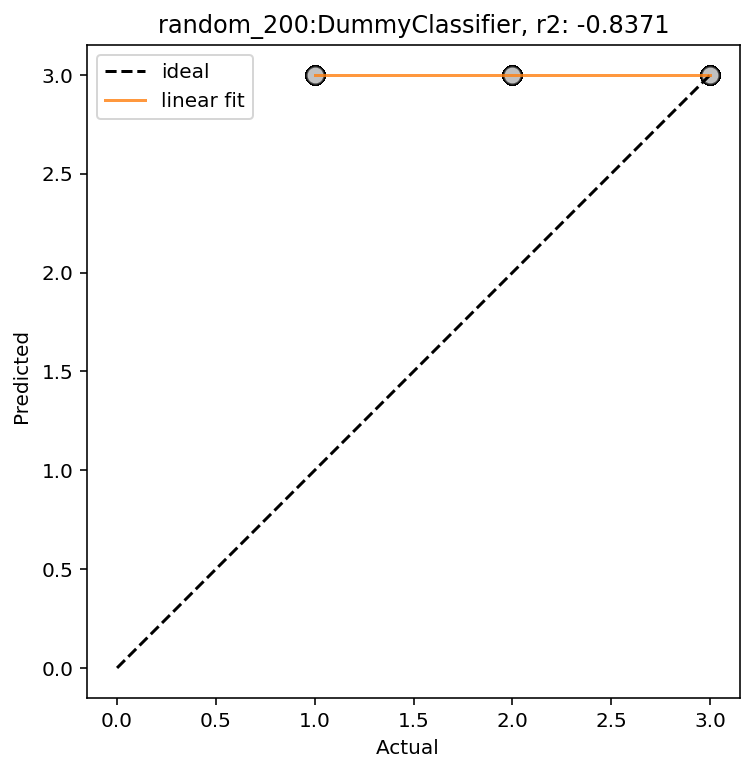

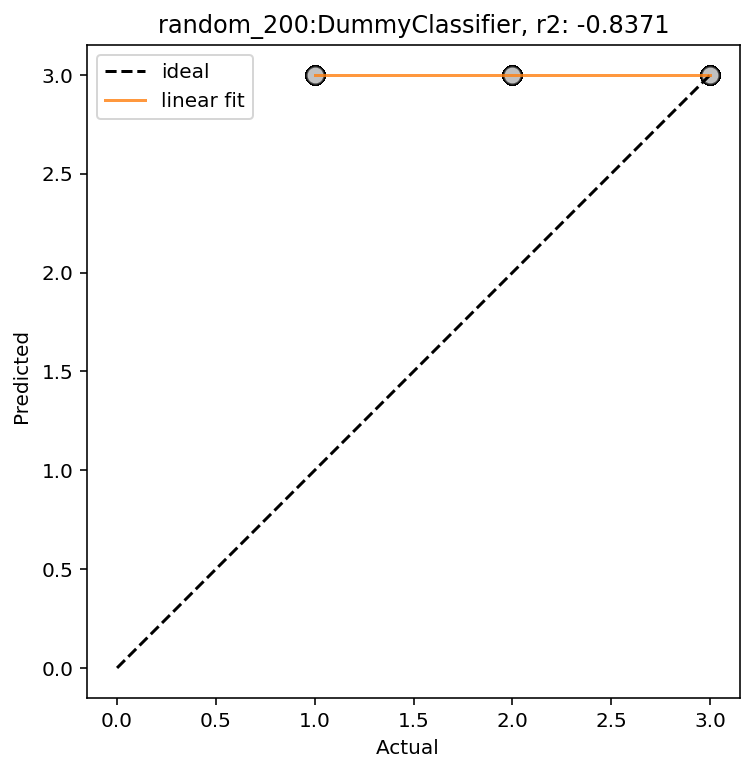

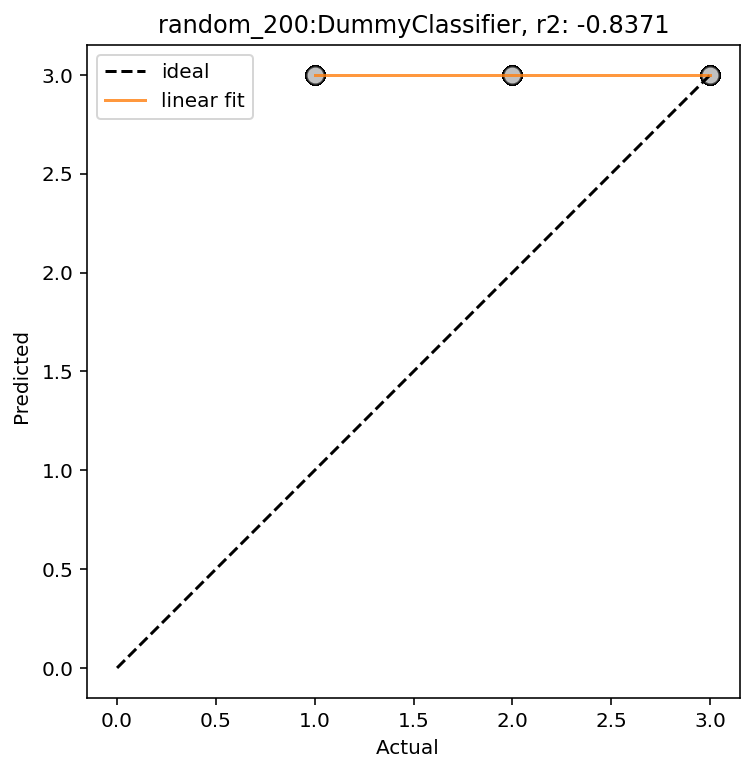

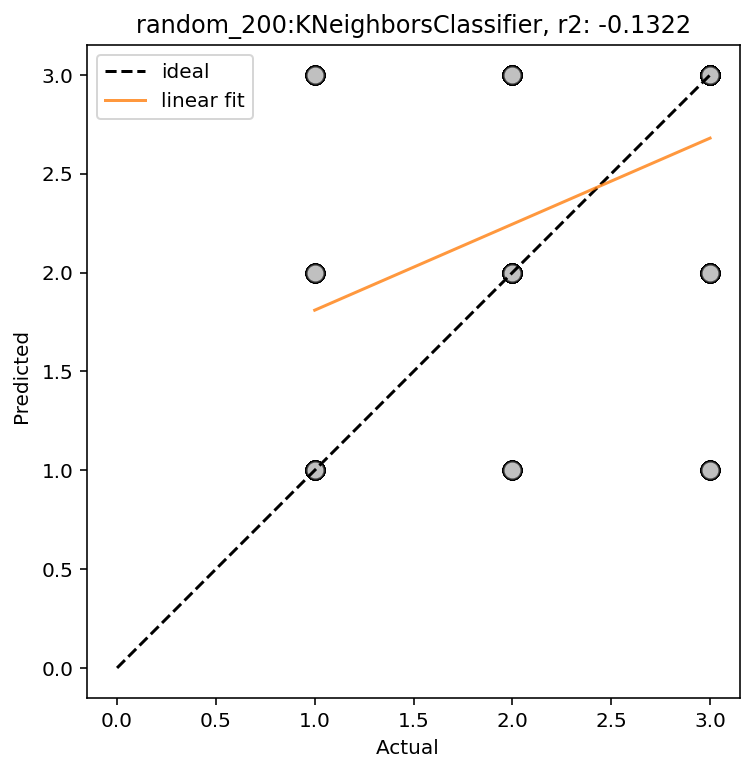

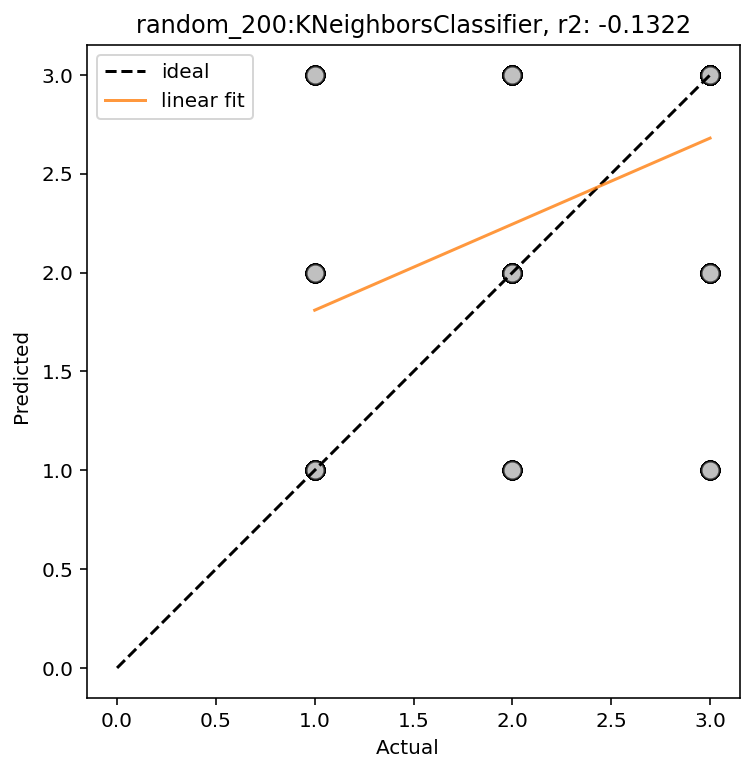

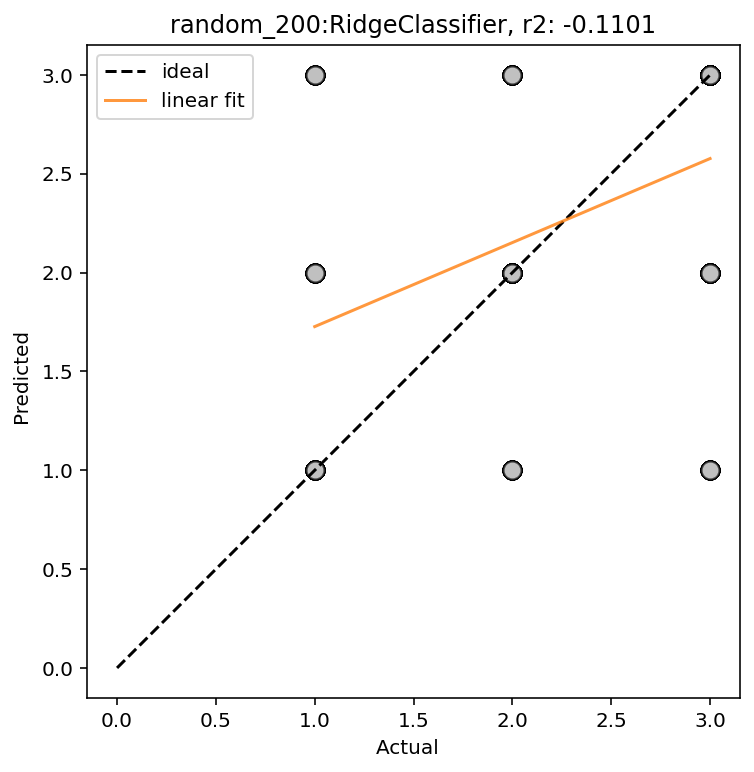

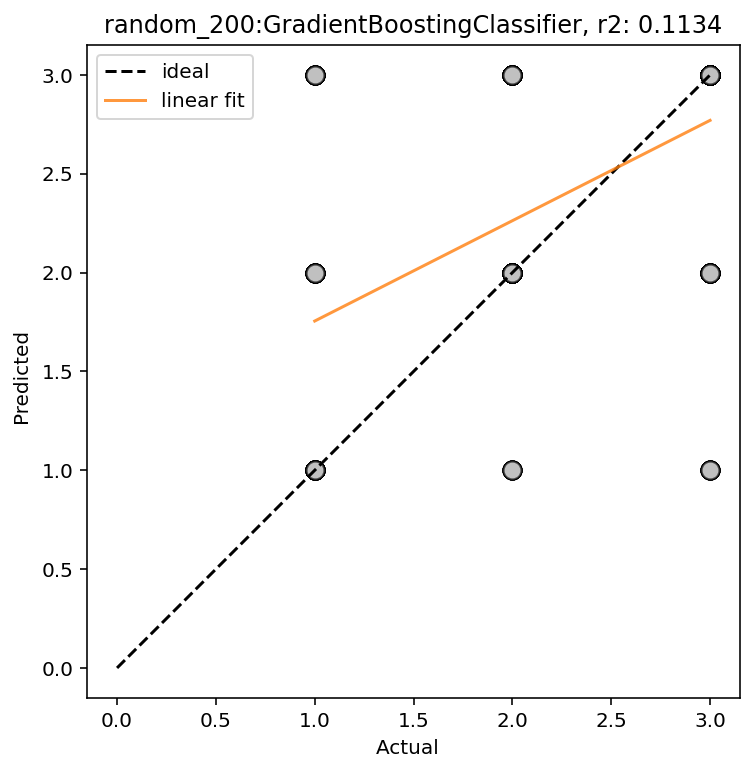

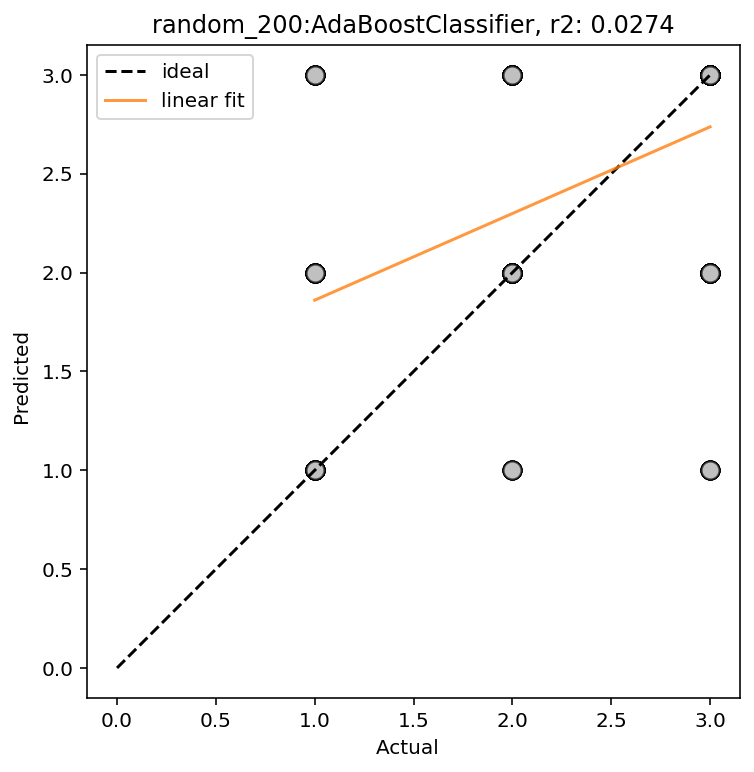

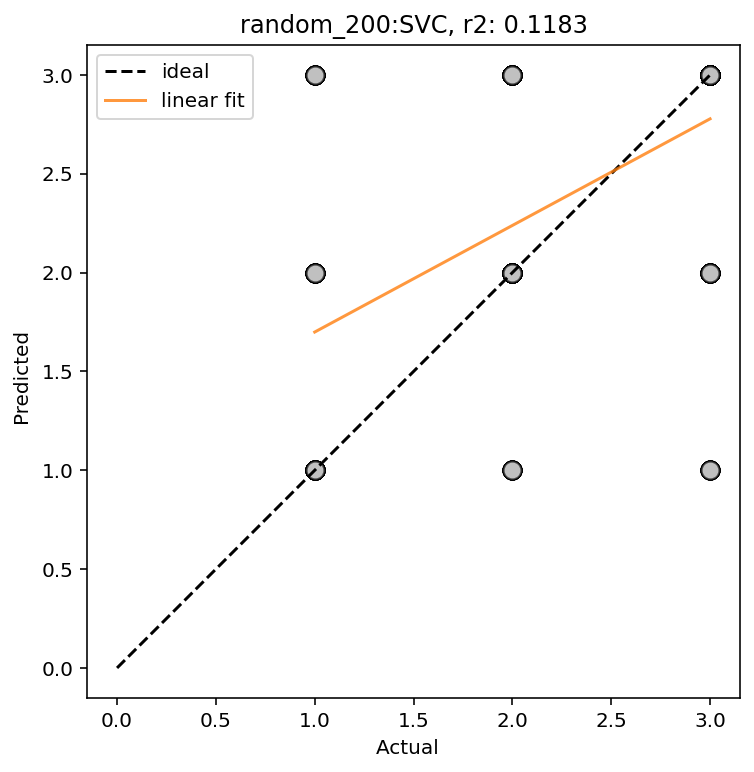

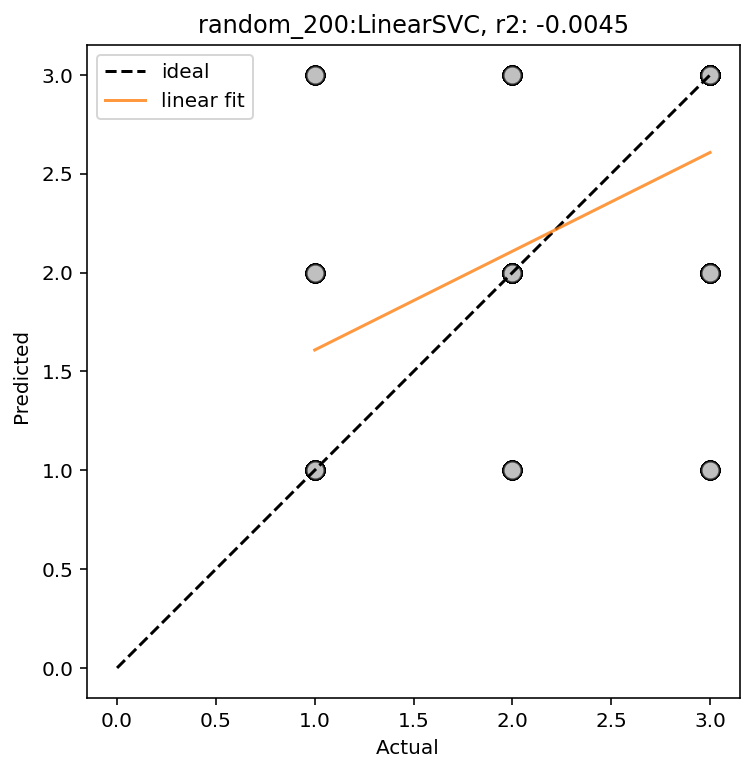

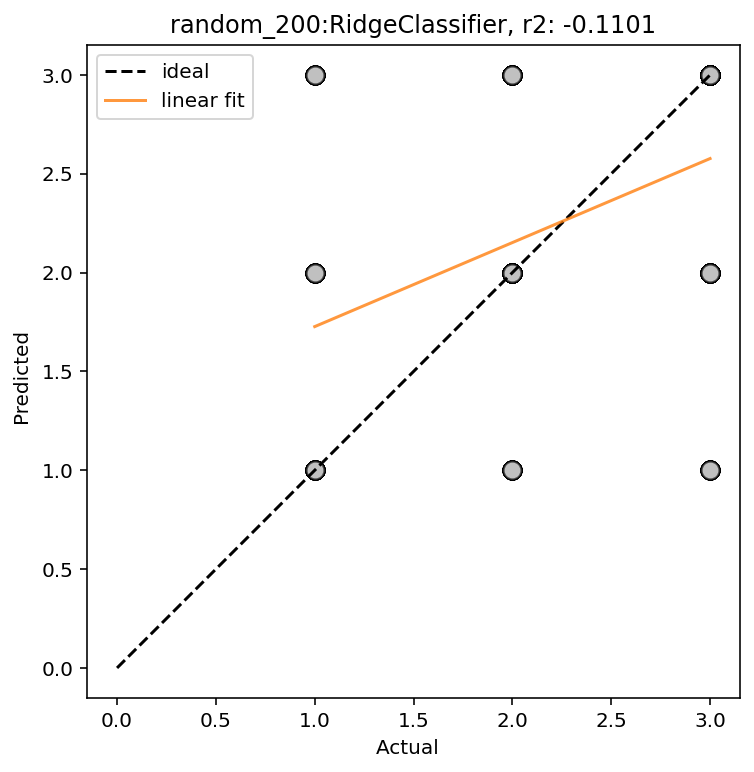

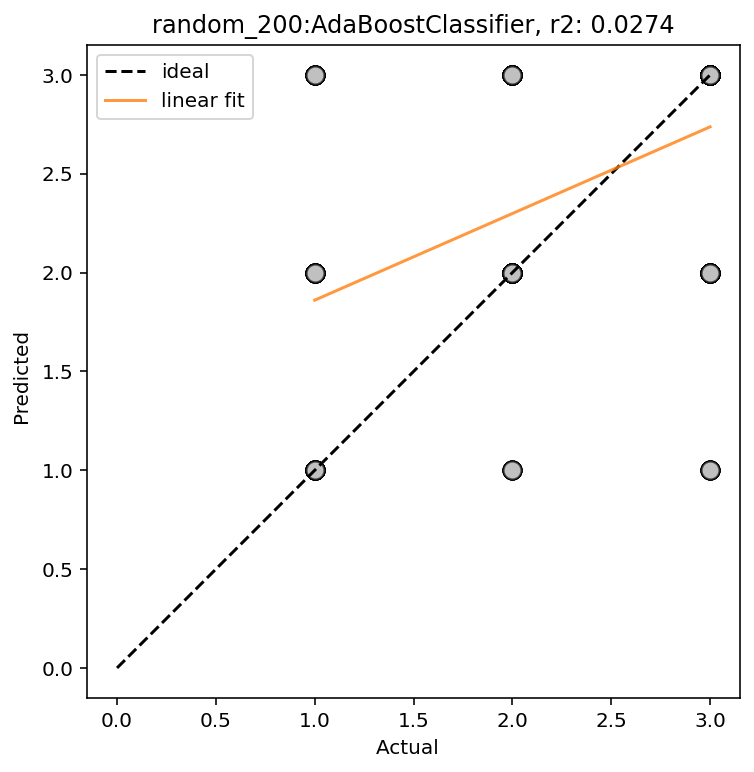

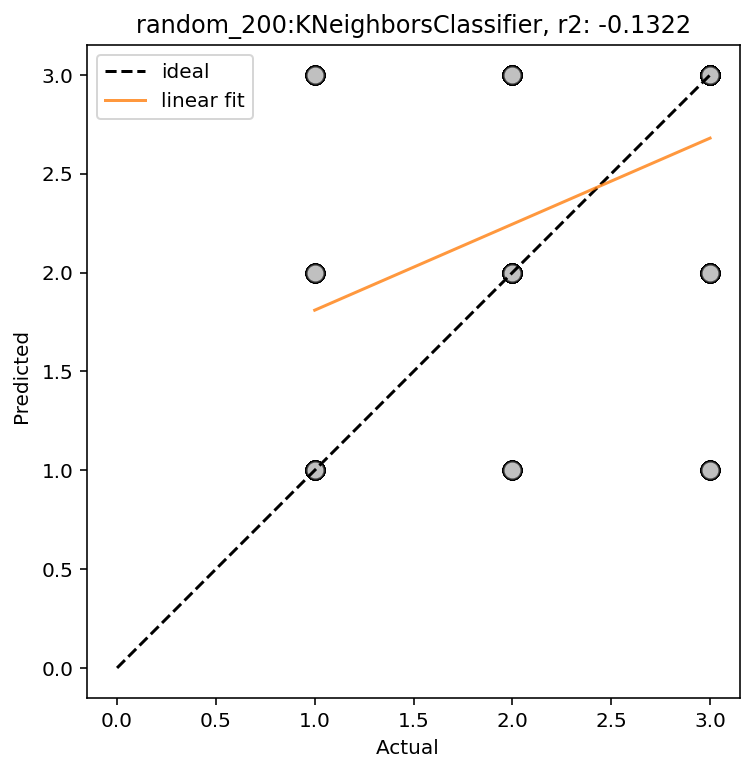

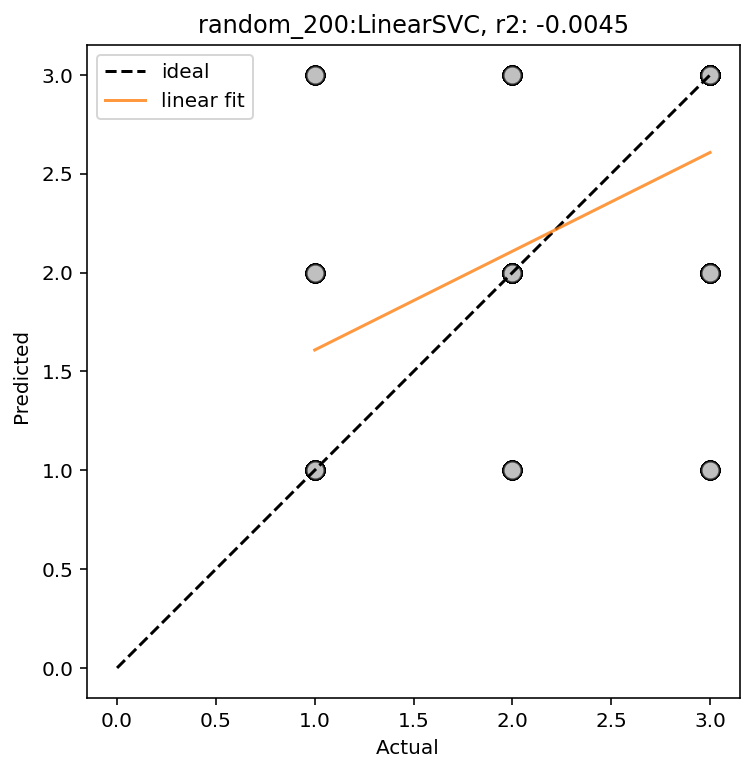

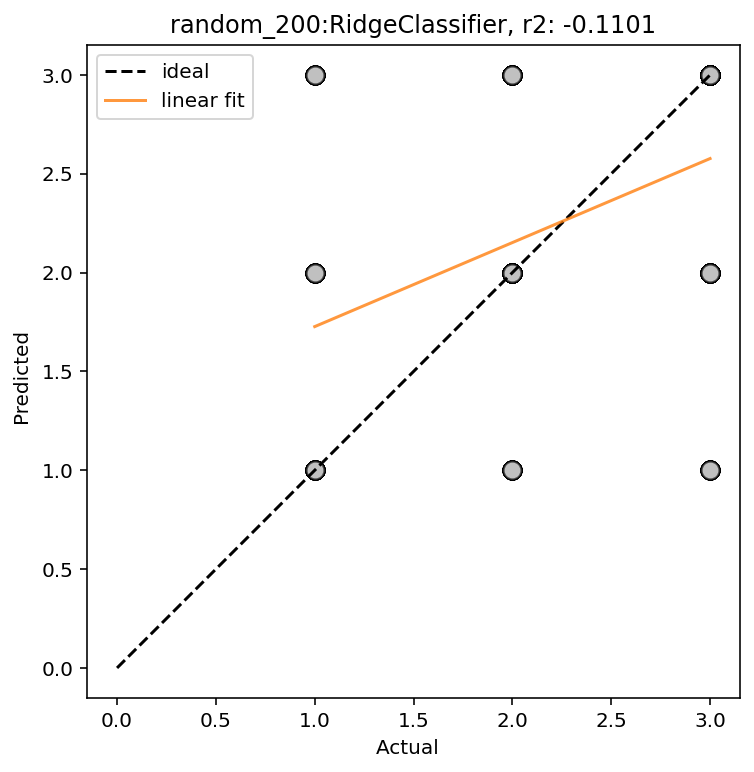

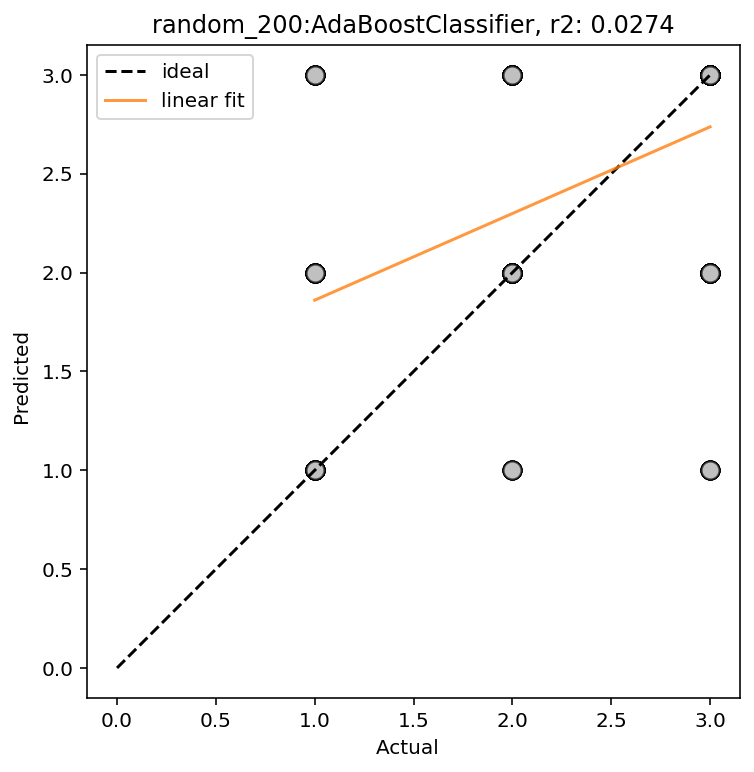

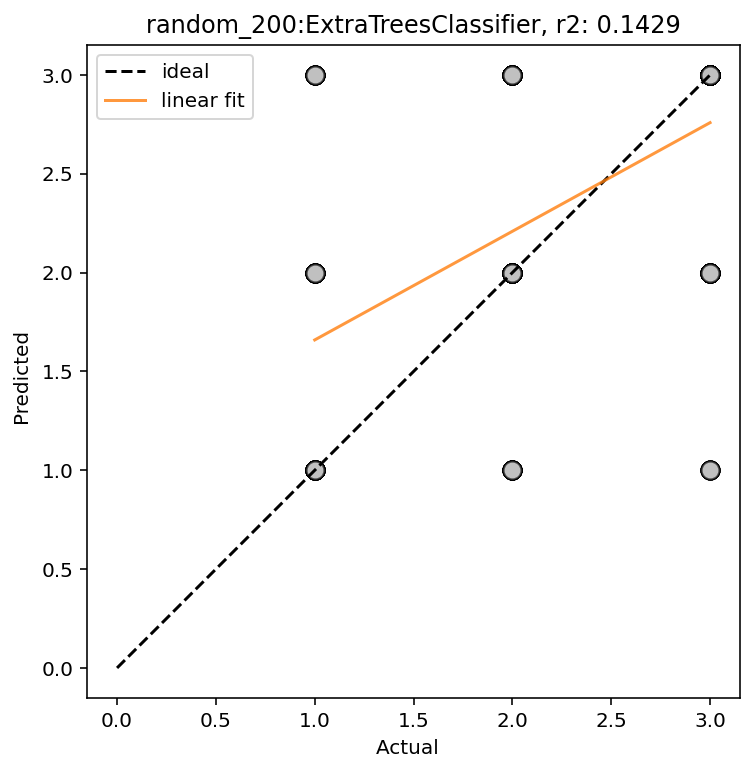

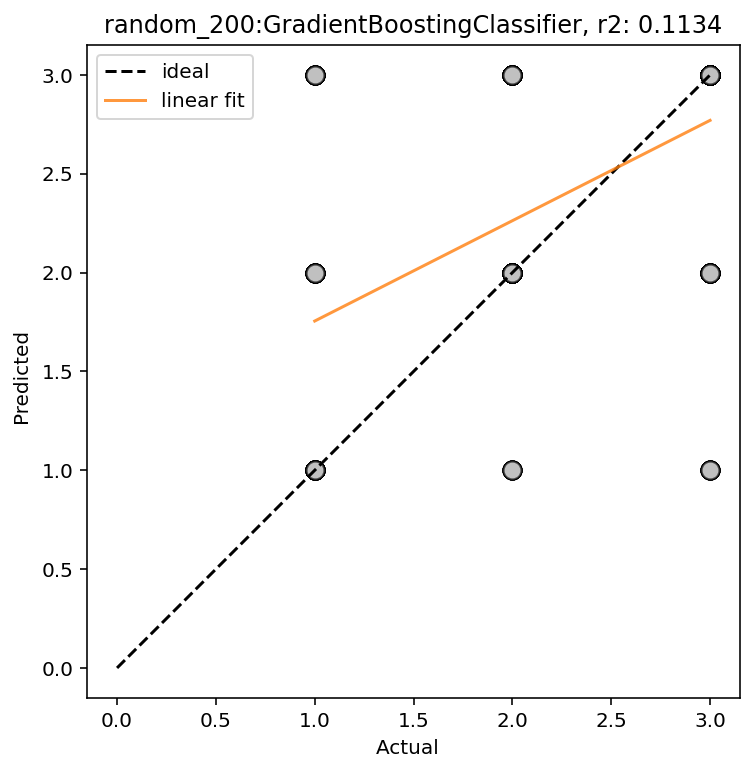

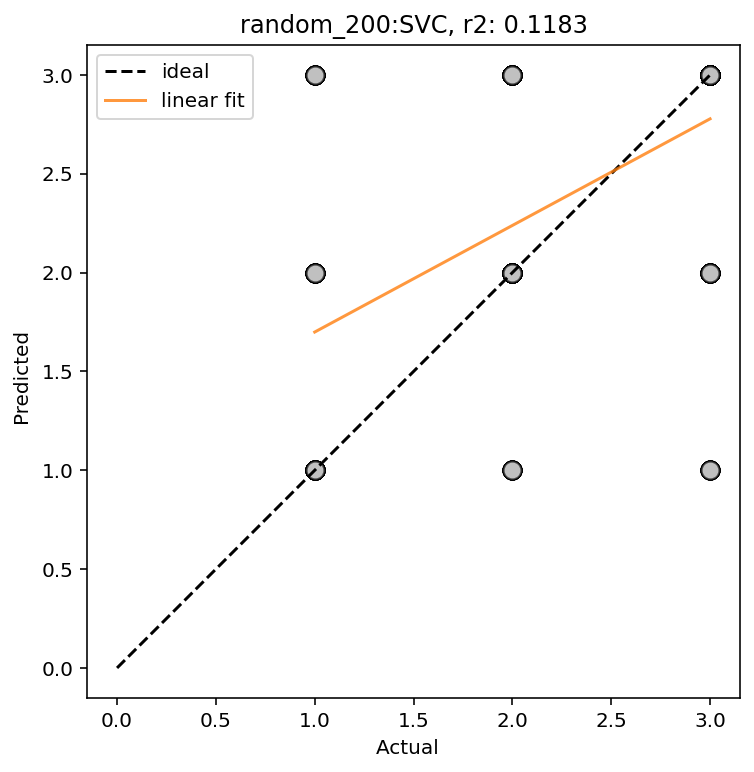

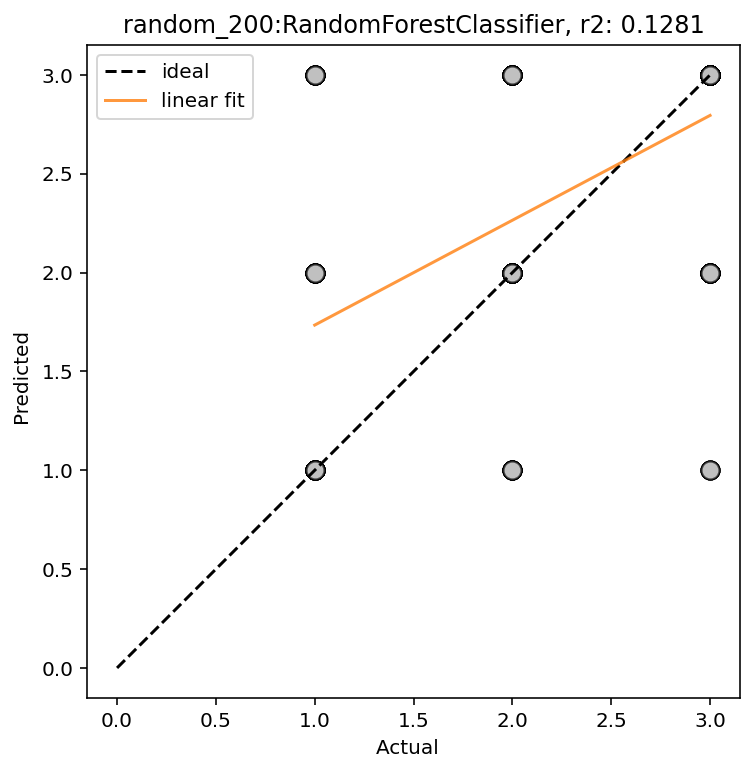

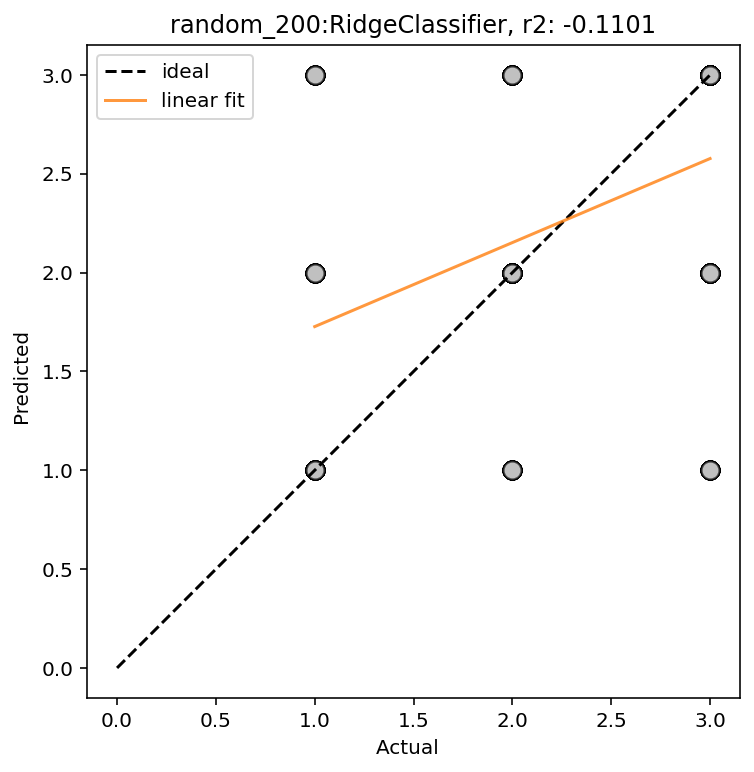

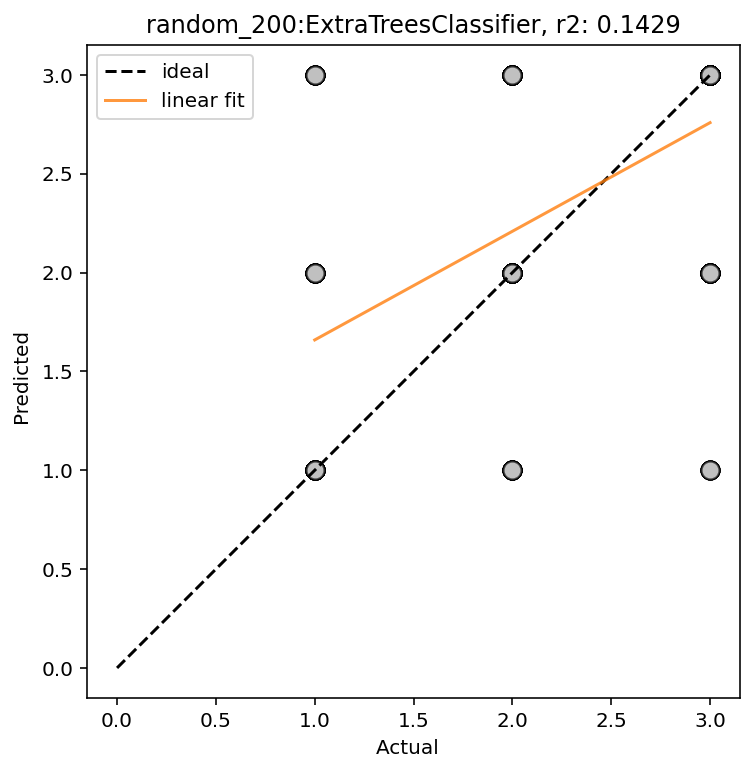

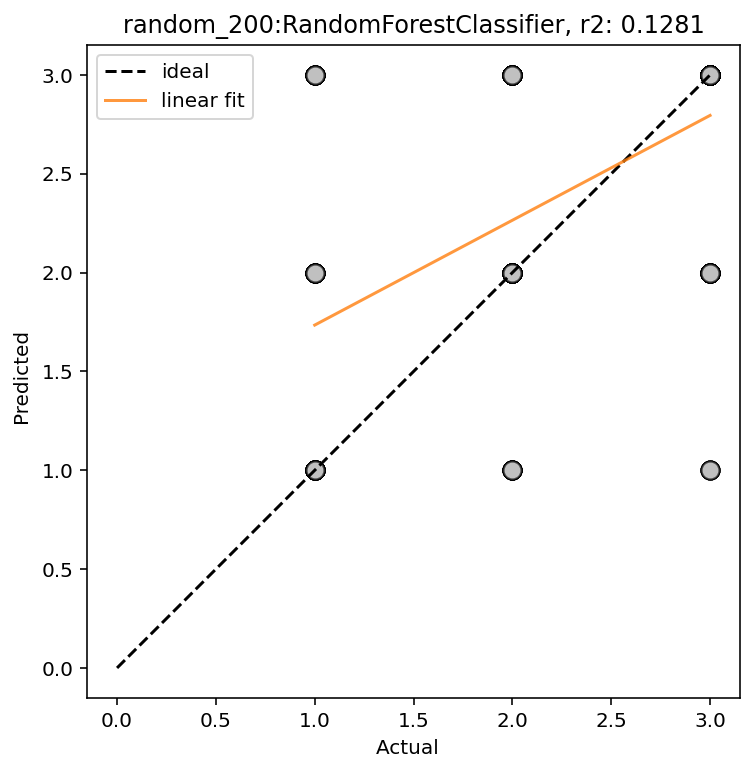

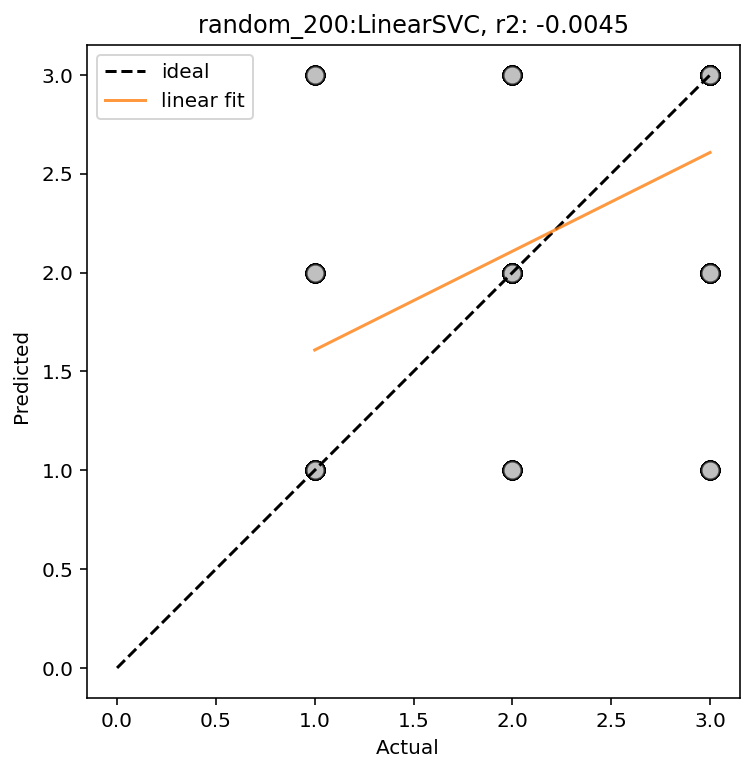

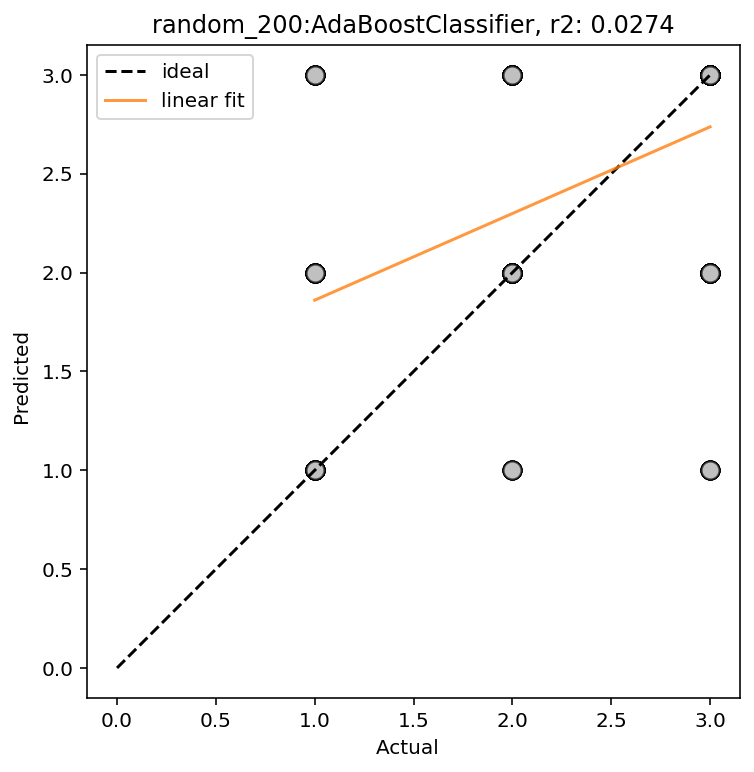

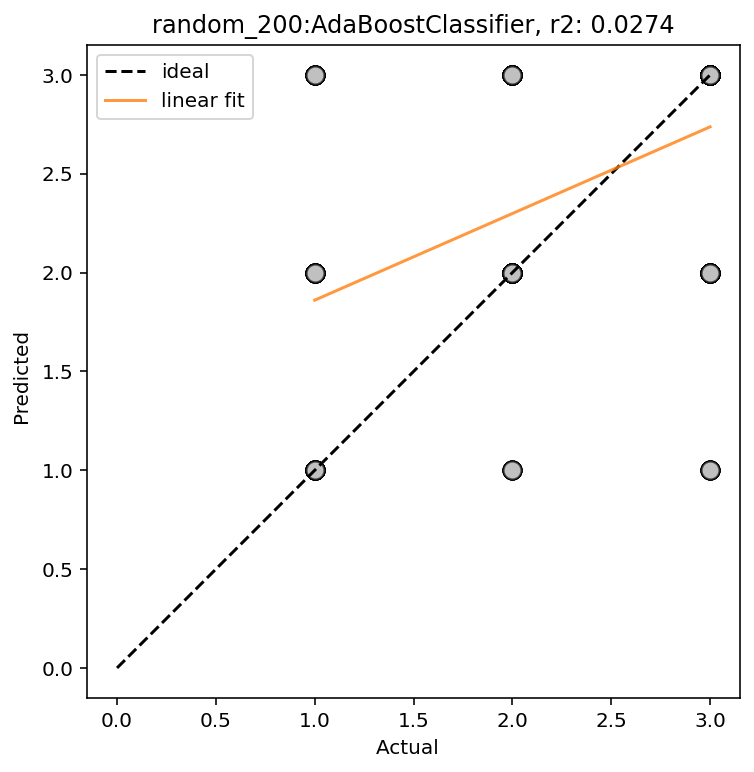

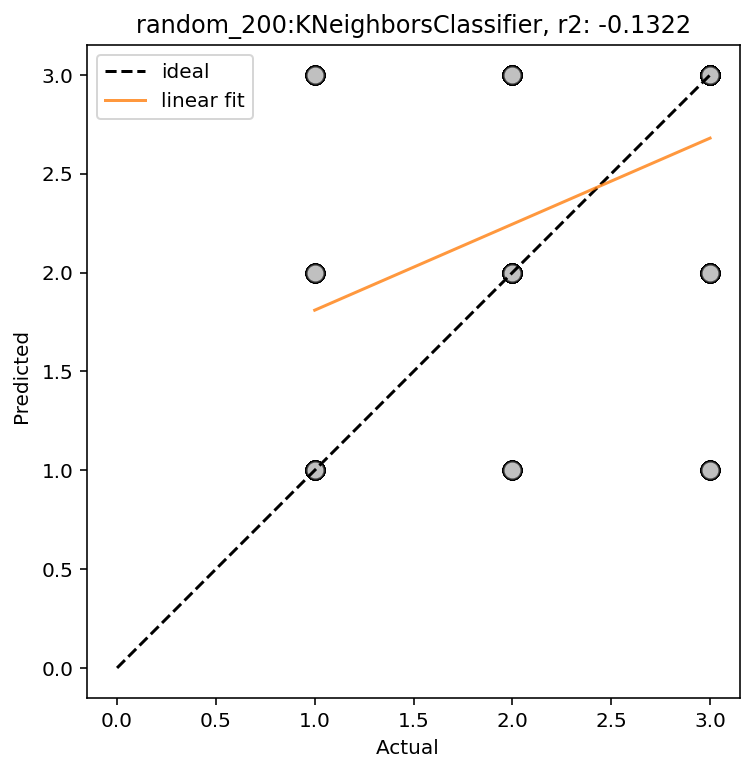

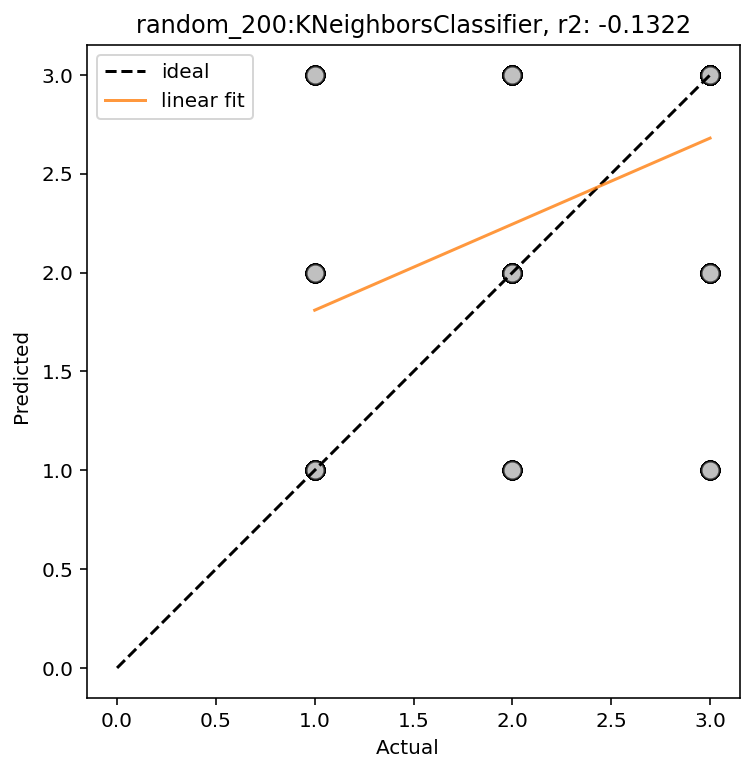

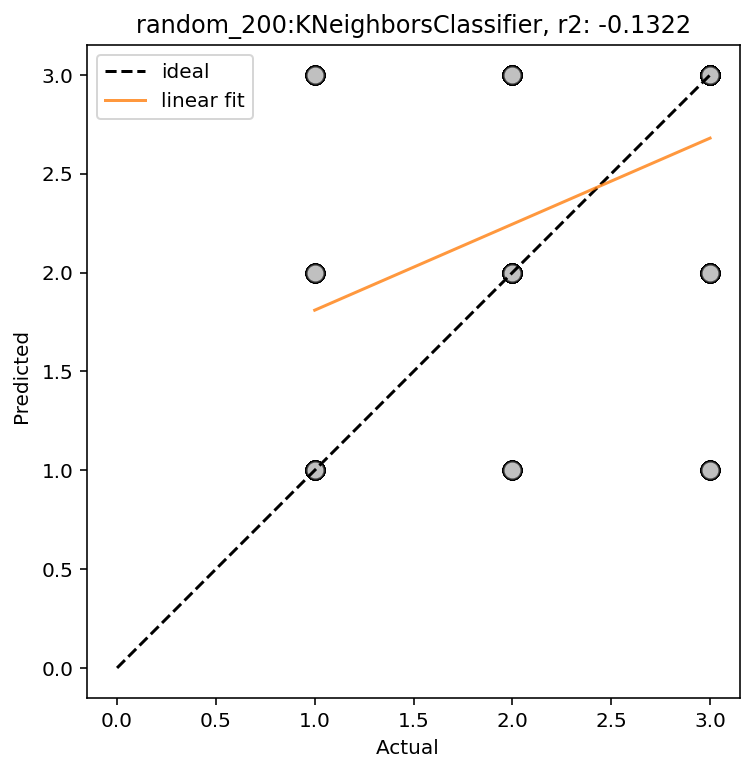

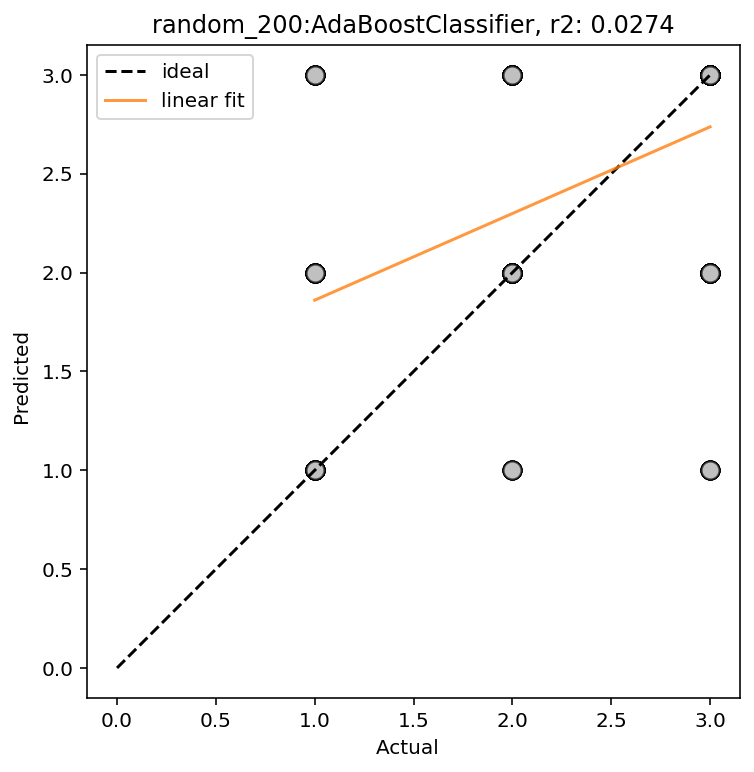

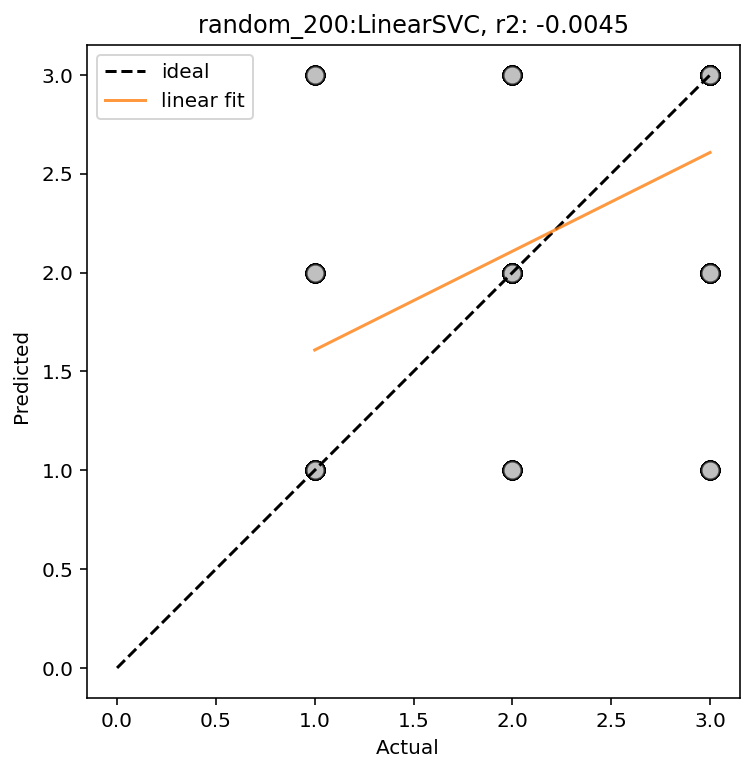

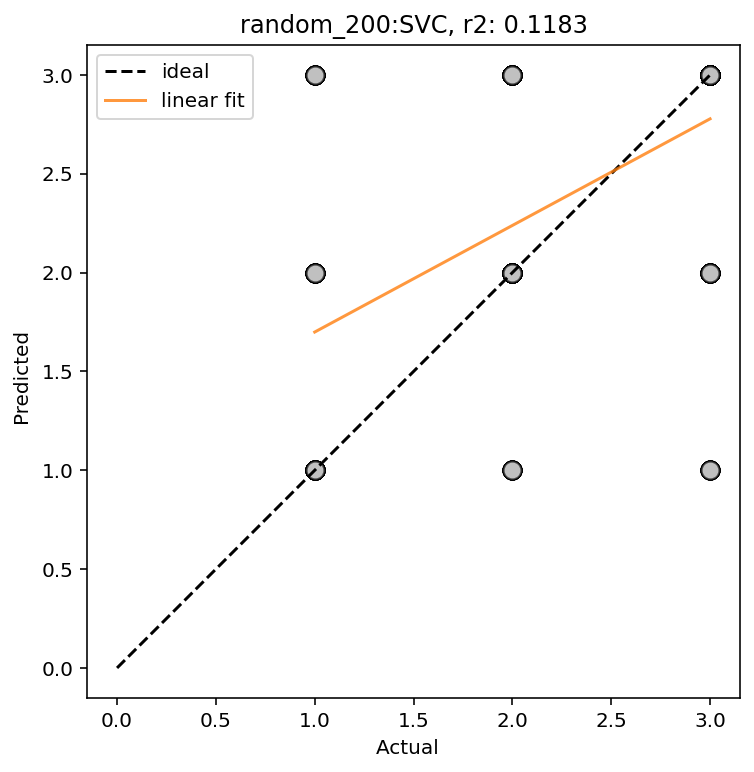

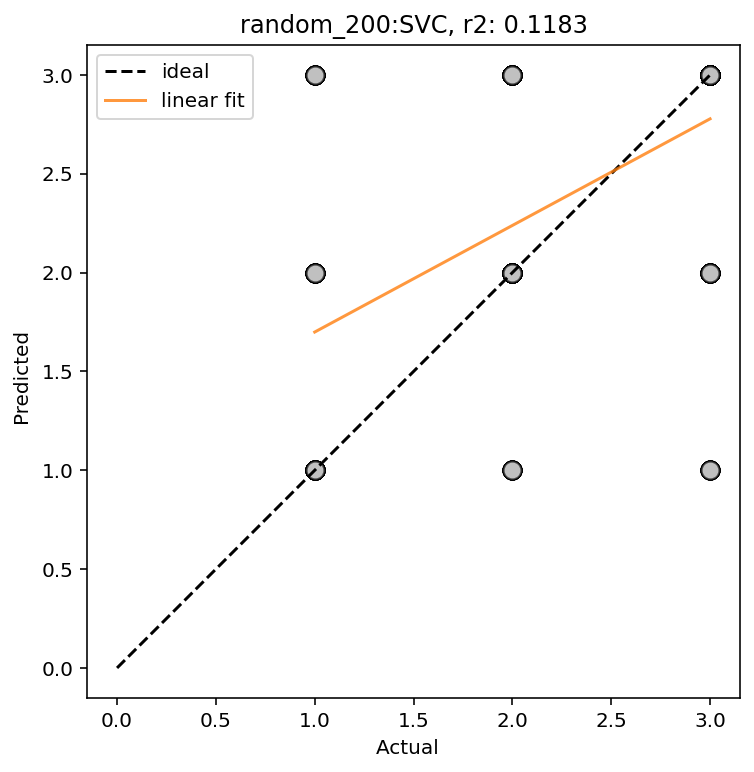

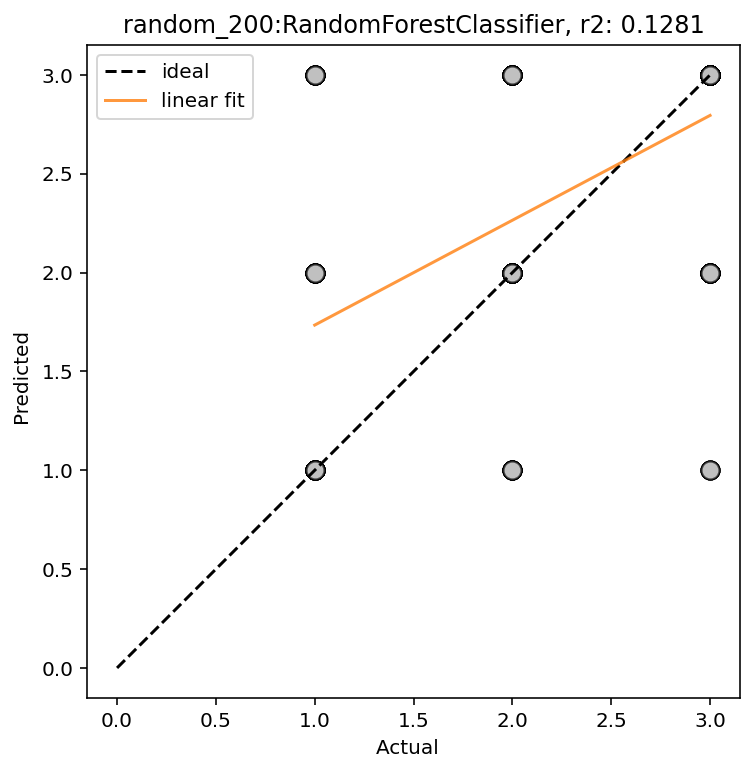

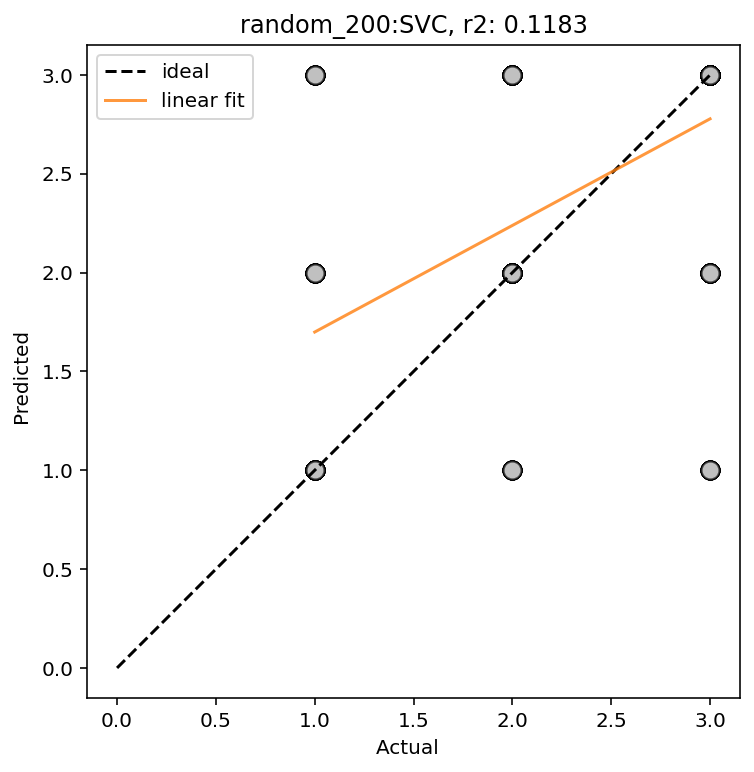

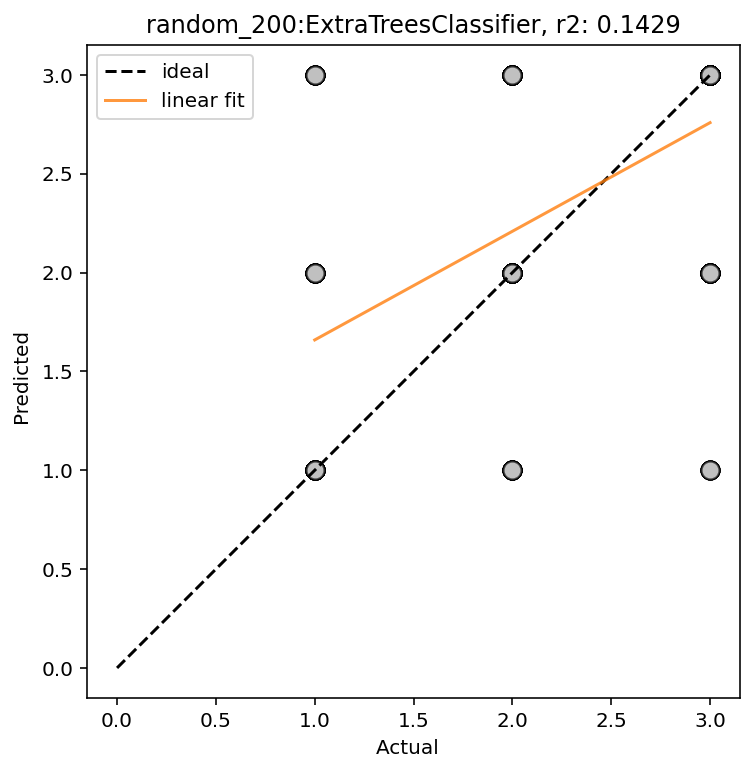

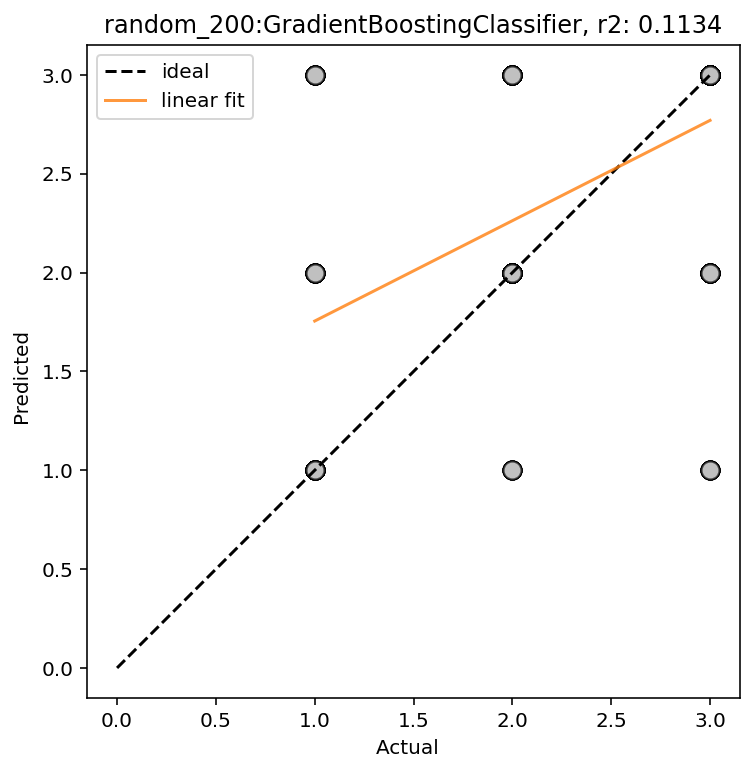

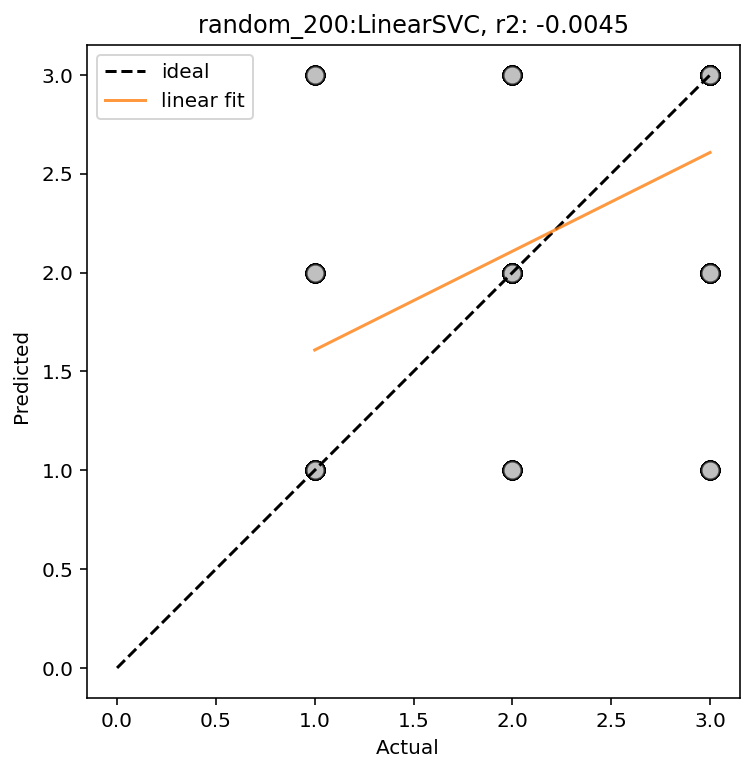

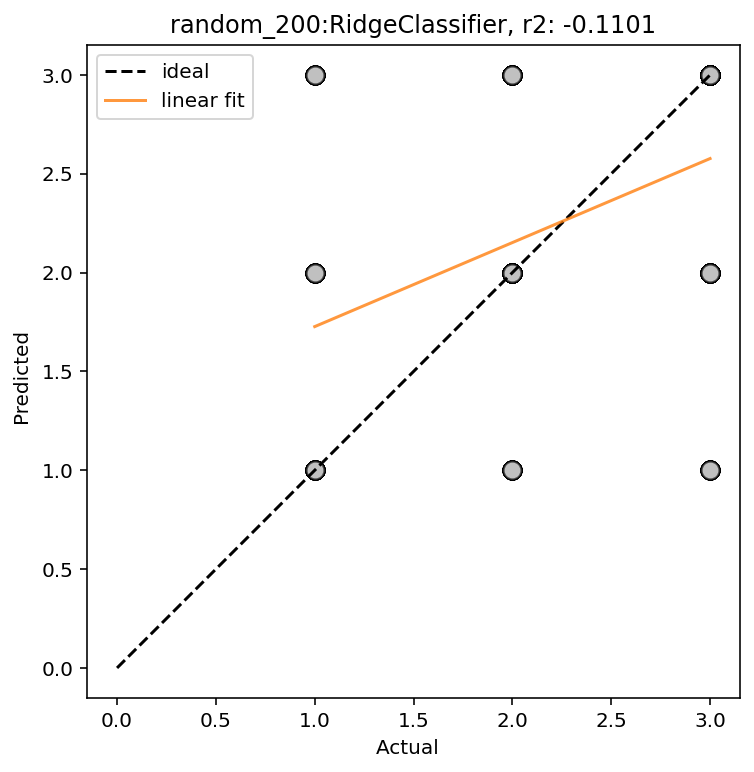

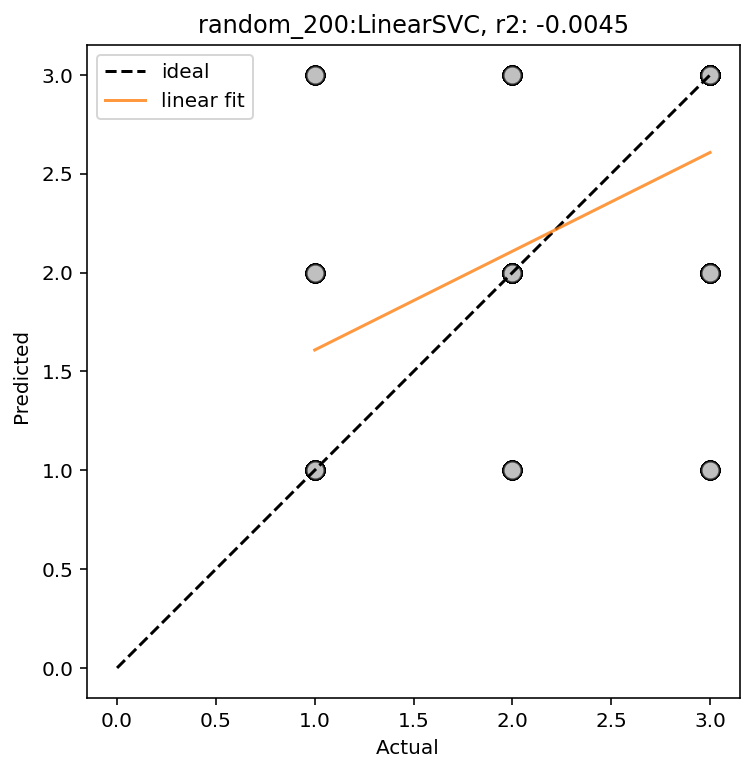

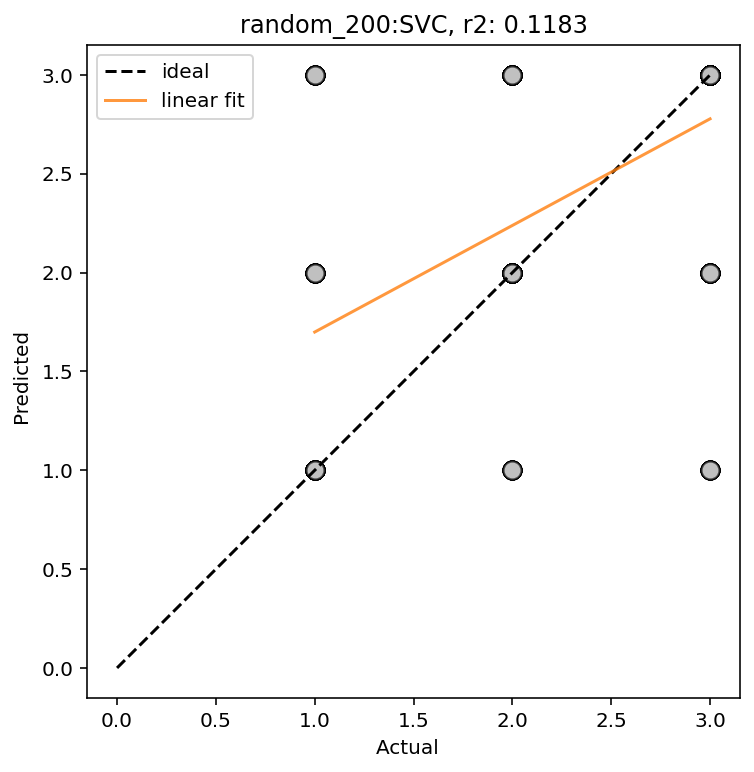

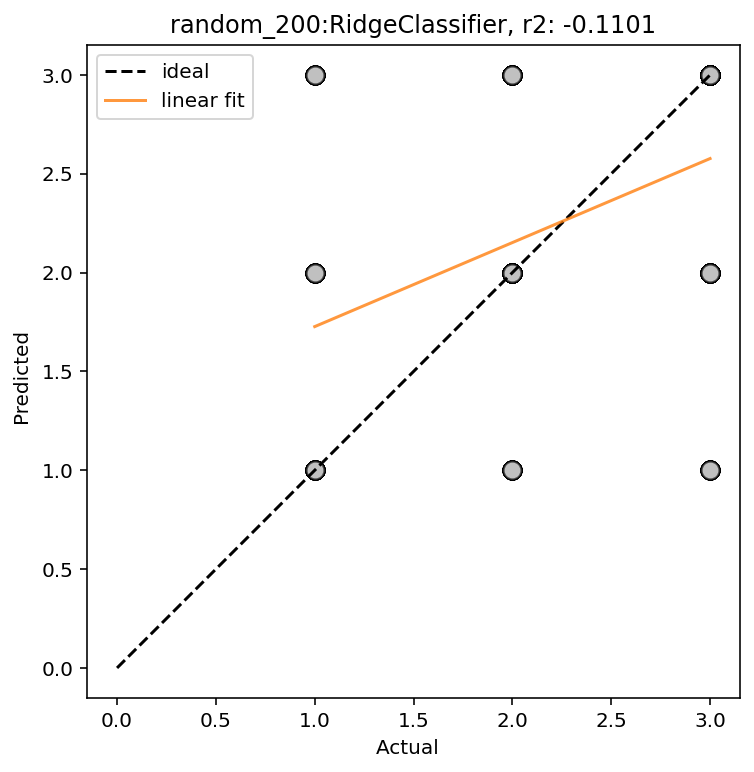

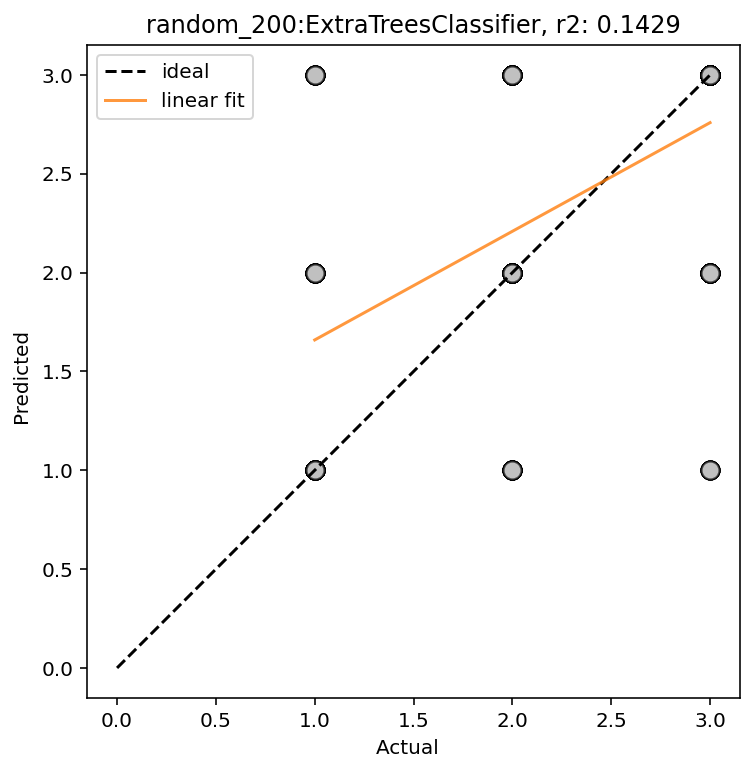

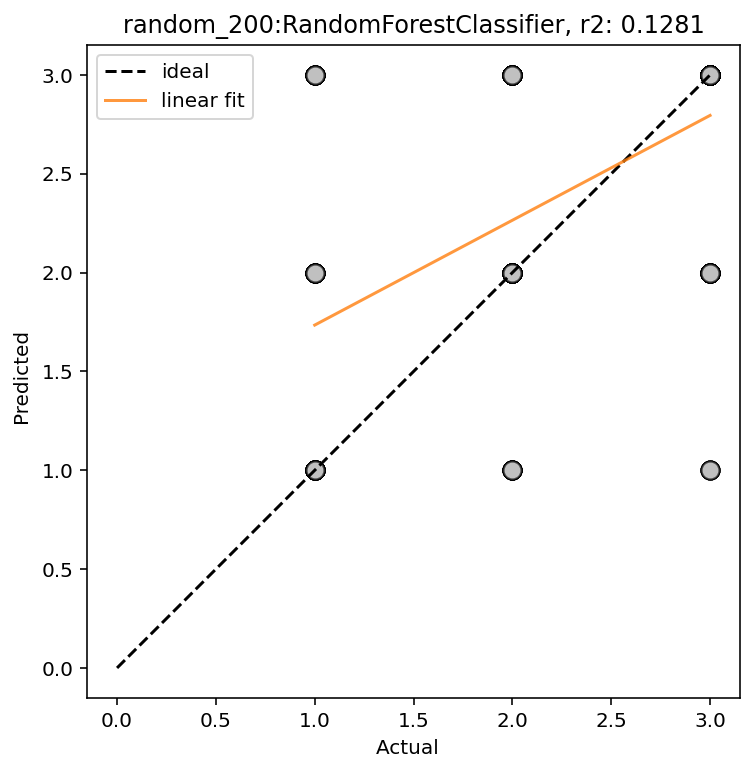

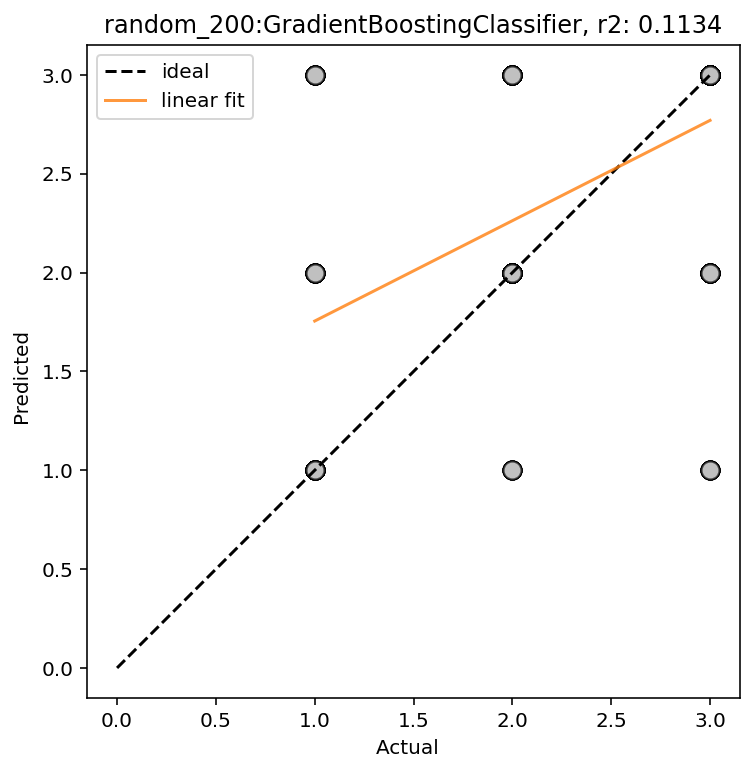

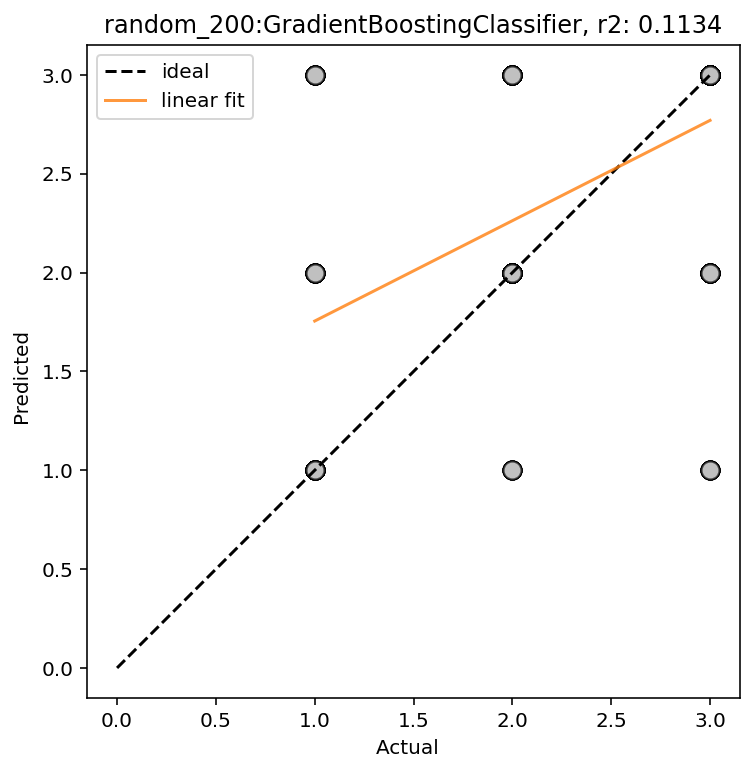

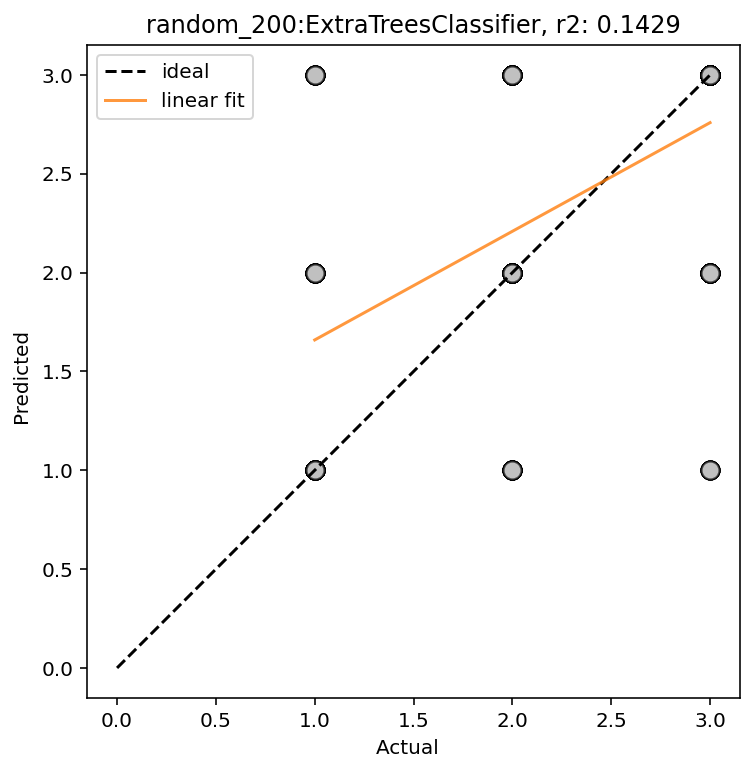

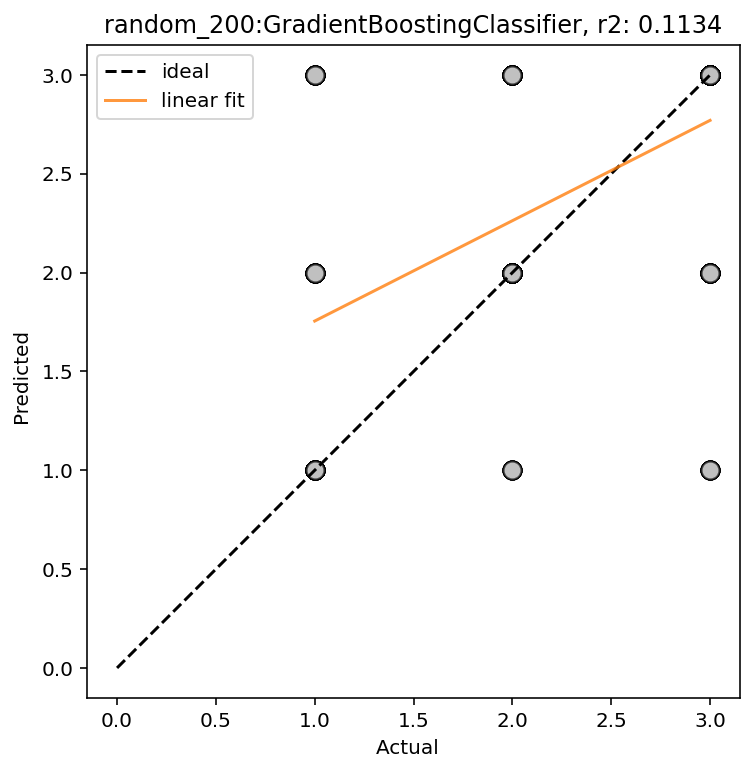

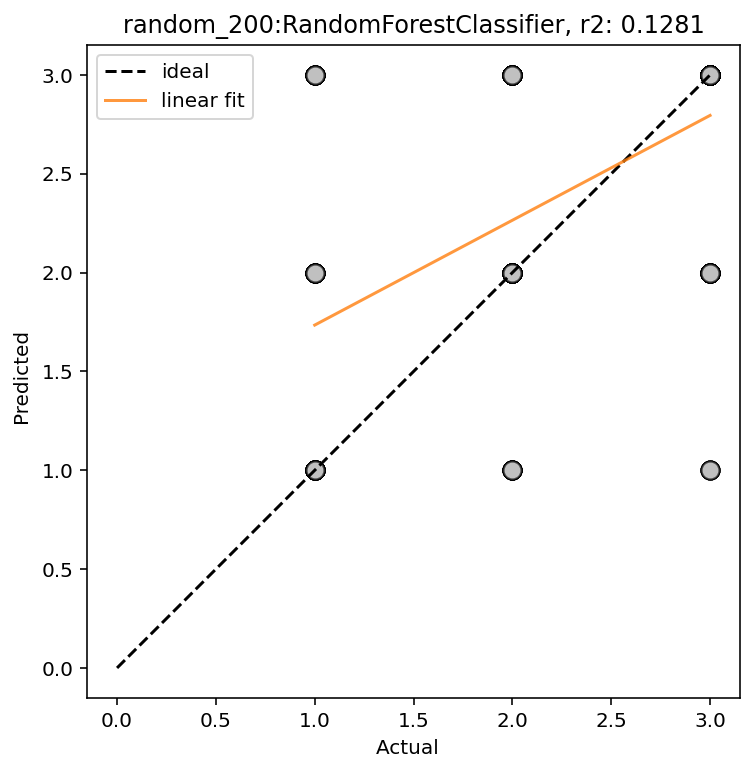

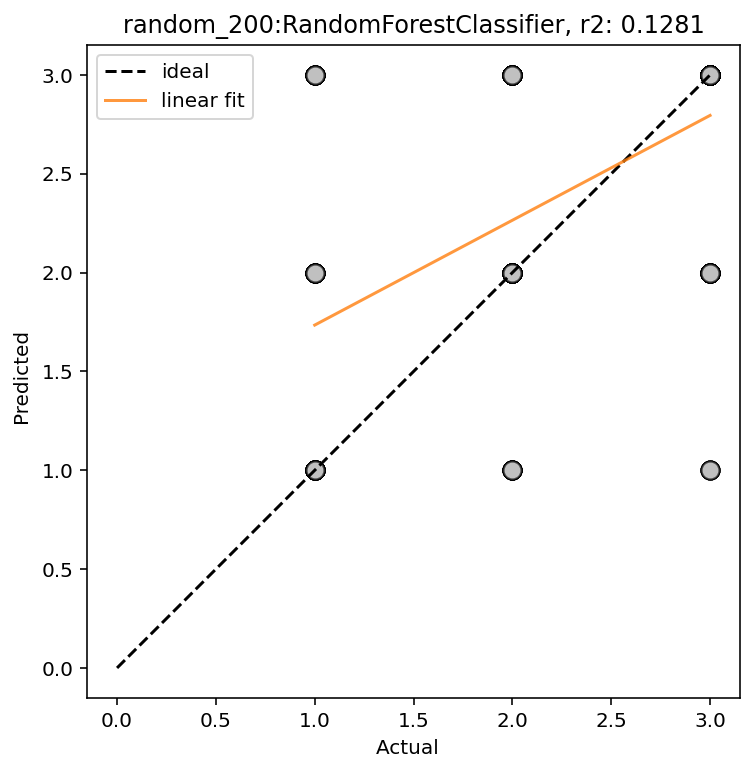

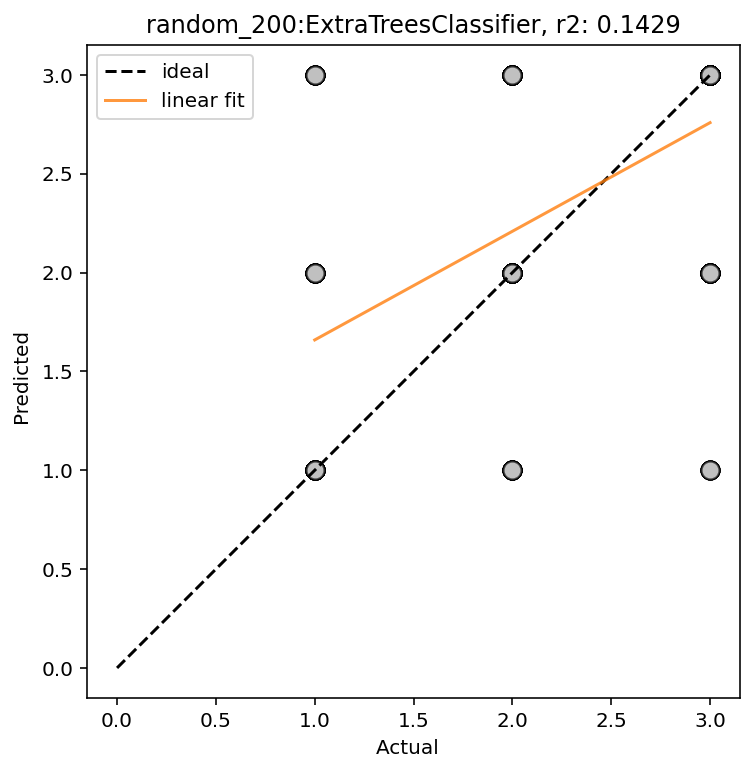

In [26]:
for f in ['jarvis', 'magpie', 'mat2vec', 'oliynyk', 'onehot','random_200']:
  X_train_unscaled, y_train, formulae_train, skipped_train = generate_features(df, elem_prop=f, drop_duplicates=False, extend_features=False, sum_feat=True)
  
  SEED = 42
  X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X_train_unscaled, y_train, test_size=0.20, random_state=SEED)
  X_train_unscaled, X_val_unscaled, y_train, y_val = train_test_split(X_train_unscaled, y_train, test_size=0.30, random_state=SEED)
  scaler = StandardScaler()

  X_train = scaler.fit_transform(X_train_unscaled)
  X_val = scaler.transform(X_val_unscaled)
  X_test = scaler.transform(X_test_unscaled)
  
  # Instantiate a dictionary to store the model objects
  classic_models = OrderedDict()

  # Keep track of elapsed time
  ti = time()

  # Loop through each model type, fit and predict, and evaluate and store results
  for model_name, model in classic_model_names.items():
      print(f'Now fitting and evaluating model {model_name}: {model.__name__}')
      model, result_dict = fit_evaluate_model(model, model_name, X_train, y_train, X_val, y_val)
      df_classics = append_result_df(df_classics, result_dict)
      classic_models = append_model_dict(classic_models, model_name, model)

  dt = time() - ti
  print(f'Finished fitting {len(classic_models)} models, total time: {dt:0.2f} s')

  # Sort in order of increasing validation r2 score
  df_classics = df_classics.sort_values('r2_val', ignore_index=True)
  df_classics

  for row in range(df_classics.shape[0]):
      model_name = df_classics.iloc[row]['model_name']

      model = classic_models[model_name]
      y_act_val = y_val
      y_pred_val = model.predict(X_val)

      plot = plot_pred_act(f, y_act_val, y_pred_val, model, reg_line=True, label=' ')

oliynyk:extratrees,r2 =~0.6839~ 0.6965


In [27]:
X_train_unscaled, y_train, formulae_train, skipped_train = generate_features(df, elem_prop='oliynyk', drop_duplicates=False, extend_features=False, sum_feat=True)

Processing Input Data: 100%|██████████| 2814/2814 [00:00<00:00, 14035.21it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 2814/2814 [00:00<00:00, 8330.88it/s]


	Creating Pandas Objects...


In [28]:
X_train_unscaled

sum_Atomic_Number  sum_Atomic_Weight  sum_Period  sum_group  \
0                  94.0          215.73640        10.0       22.0   
1                 388.0          893.29108        46.0      180.0   
2                 164.0          375.54440        18.0       56.0   
3                 178.0          403.55788        22.0       86.0   
4                 180.0          407.54320        22.0       88.0   
...                 ...                ...         ...        ...   
2809              108.0          250.89000        13.0       36.0   
2810              142.0          334.74400        15.0       34.0   
2811              108.0          249.14400        13.0       36.0   
2812              126.0          297.78400        14.0       36.0   
2813              144.0          346.42400        15.0       36.0   

      sum_families  sum_Metal  sum_Nonmetal  sum_Metalliod  \
0              8.0        2.0           0.0            0.0   
1             80.0        4.0           8.0            0.0   
2             24.0        2.0           2.0            0.0   
3             38.0        2.0           4.0            0.0   
4             38.0        2.0           4.0            0.0   
...            ...        ...           ...            ...   
2809          17.0        1.0           2.0            0.0   
2810          16.0        1.0           2.0            0.0   
2811          18.0        1.0           2.0            0.0   
2812          17.0        1.0           2.0            0.0   
2813          16.0        1.0           2.0            0.0   

      sum_Mendeleev_Number  sum_l_quantum_number  ...  \
0                    130.0                   0.0  ...   
1                   1014.0                  12.0  ...   
2                    320.0                   2.0  ...   
3                    484.0                   4.0  ...   
4                    494.0                   4.0  ...   
...                    ...                   ...  ...   
2809                 222.0                   4.0  ...   
2810                 214.0                   4.0  ...   
2811                 222.0                   4.0  ...   
2812                 223.0                   4.0  ...   
2813                 224.0                   4.0  ...   

      mode_polarizability(A^3)  mode_Melting_point_(K)  \
0                        7.900                 1235.15   
1                        2.200                  172.15   
2                        3.100                  265.95   
3                        1.100                   63.25   
4                        0.793                   54.75   
...                        ...                     ...   
2809                     2.900                  385.95   
2810                     6.600                  904.15   
2811                     3.800                  490.15   
2812                     3.800                  490.15   
2813                     5.500                  722.65   

      mode_Boiling_Point_(K)  mode_Density_(g/mL)  \
0                    2485.15             10.50000   
1                     238.55              0.00321   
2                     331.95              3.12000   
3                      77.35              0.00125   
4                      90.15              0.00143   
...                      ...                  ...   
2809                  717.85              2.07000   
2810                 2223.15              6.69000   
2811                  958.15              4.79000   
2812                  958.15              4.79000   
2813                 1262.95              6.24000   

      mode_specific_heat_(J/g_K)_  mode_heat_of_fusion_(kJ/mol)_  \
0                           0.235                       11.30000   
1                           0.480                        3.23000   
2                           0.235                        5.28600   
3                           0.235                        0.36040   
4                           0.235                        0.22259   
...  

## Splitting data 
### Normally, we could simply split the data with a simple `sklearn` function

The scikit-learn `train_test_split` function randomly splits a dataset into train and test datasets.
Typically, you can use `train_test_split` to first split your data into "train" and "test" datasets, and then use the function again to split your "train" data into "train" and "validation" dataset splits.
As a rule of thumb, you can roughly aim for the following dataset proportions when splitting your data:

| | train split | validation split | test split |
| --- | --- | --- | --- |
| proportion<br> of original<br> dataset | 50% to 70% | 20% to 30% | 10% to 20% |

In [29]:
SEED = 42
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X_train_unscaled, y_train, test_size=0.20, random_state=SEED)
X_train_unscaled, X_val_unscaled, y_train, y_val = train_test_split(X_train_unscaled, y_train, test_size=0.30, random_state=SEED)


## Data scaling & normalization

For numerical input data, scaling and normalization of the features often improves the model performance.
Scaling can partially correct the discrepancy between the orders of magnitudes of the features (e.g., some numerical features being much larger or smaller than others).
This typically improves the model learning performance, and in turn, improves the model performance.

We will scale then normalize our input data using scikit-learn's built-in `StandardScaler` class and `normalize` function.

Note, in addition to `StandardScaler`, other scalers such as `RobustScaler` and `MinMaxScaler` are also available in scikit-learn.

## Scaling the data

First, we instantiate the scaler object.

In a `StandardScaler` object:
* During the `fit` process, the statistics of the input data (mean and standard deviation) are computed.
* Then, during the `transform` process, the mean and standard deviation values calculated above are used to scale the data to having zero-mean and unit variance.

Therefore, for the first time usage of the scaler, we call the `.fit_transform()` method to fit the scaler to the input data, and then to transform the same data.
For subsequent uses, since we have already computed the statistics, we only call the `.transform()` method to scale data.

**Note:** you should *only* `.fit()` the scaler using the training dataset statistics, and then use these same statistics from the training dataset to `.transform()` the other datasets (validation and train).

In [30]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_unscaled)
X_val = scaler.transform(X_val_unscaled)
X_test = scaler.transform(X_test_unscaled)

# Modeling using "classical" machine learning models

Here we implement some classical ML models from `sklearn`:

* Ridge regression
* Support vector machine
* Linear support vector machine
* Random forest
* Extra trees
* Adaptive boosting
* Gradient boosting
* k-nearest neighbors
* Dummy (if you can't beat this, something is wrong.)

Note: the Dummy model types from `sklearn` act as a good sanity check for your ML studies. If your models do not perform significantly better than the equivalent Dummy models, then you should know that something has gone wrong in your model implementation.

In [31]:
# from time import time

# from sklearn.dummy import DummyRegressor

# from sklearn.linear_model import Ridge

# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.ensemble import ExtraTreesRegressor
# from sklearn.ensemble import RandomForestRegressor

# from sklearn.neighbors import KNeighborsRegressor

# from sklearn.svm import SVR
# from sklearn.svm import LinearSVR

# from sklearn.metrics import r2_score
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import mean_squared_error

In addition, we define some helper functions.

In [32]:
def instantiate_model(model_name):
    model = model_name()
    return model

def fit_model(model, X_train, y_train):
    ti = time()
    model = instantiate_model(model)
    model.fit(X_train, y_train)
    fit_time = time() - ti
    return model, fit_time

def evaluate_model(model, X, y_act):
    y_pred = model.predict(X)
    r2 = r2_score(y_act, y_pred)
    mae = mean_absolute_error(y_act, y_pred)
    rmse_val = mean_squared_error(y_act, y_pred, squared=False)
    return r2, mae, rmse_val

def fit_evaluate_model(model, model_name, X_train, y_train, X_val, y_act_val):
    model, fit_time = fit_model(model, X_train, y_train)
    r2_train, mae_train, rmse_train = evaluate_model(model, X_train, y_train)
    r2_val, mae_val, rmse_val = evaluate_model(model, X_val, y_act_val)
    result_dict = {
        'model_name': model_name,
        'model_name_pretty': type(model).__name__,
        'model_params': model.get_params(),
        'fit_time': fit_time,
        'r2_train': r2_train,
        'mae_train': mae_train,
        'rmse_train': rmse_train,
        'r2_val': r2_val,
        'mae_val': mae_val,
        'rmse_val': rmse_val}
    return model, result_dict

def append_result_df(df, result_dict):
    df_result_appended = df.append(result_dict, ignore_index=True)
    return df_result_appended

def append_model_dict(dic, model_name, model):
    dic[model_name] = model
    return dic

Build an empty DataFrame to store model results:

In [33]:
df_classics = pd.DataFrame(columns=['model_name',
                                    'model_name_pretty',
                                    'model_params',
                                    'fit_time',
                                    'r2_train',
                                    'mae_train',
                                    'rmse_train',
                                    'r2_val',
                                    'mae_val',
                                    'rmse_val'])
df_classics

Empty DataFrame
Columns: [model_name, model_name_pretty, model_params, fit_time, r2_train, mae_train, rmse_train, r2_val, mae_val, rmse_val]
Index: []

In [34]:
# # Build a dictionary of model names
# classic_model_names = OrderedDict({
#     'dumr': DummyRegressor,
#     'rr': Ridge,
#     'abr': AdaBoostRegressor,
#     'gbr': GradientBoostingRegressor,
#     'rfr': RandomForestRegressor,
#     'etr': ExtraTreesRegressor,
#     'svr': SVR,
#     'lsvr': LinearSVR,
#     'knr': KNeighborsRegressor,
# })

## Instantiate and fit the models

Now, we can fit the ML models.

We will loop through each of the models listed above. For each of the models, we will:
* instantiate the model (with default parameters)
* fit the model using the training data
* use the fitted model to generate predictions from the validation data
* evaluate the performance of the model using the predictions
* store the results in a DataFrame for analysis

Note: this may take several minutes, depending on your hardware/software environment, dataset size and featurization scheme (CBFV).

In [35]:
# Instantiate a dictionary to store the model objects
classic_models = OrderedDict()

# Keep track of elapsed time
ti = time()

# Loop through each model type, fit and predict, and evaluate and store results
for model_name, model in classic_model_names.items():
    print(f'Now fitting and evaluating model {model_name}: {model.__name__}')
    model, result_dict = fit_evaluate_model(model, model_name, X_train, y_train, X_val, y_val)
    df_classics = append_result_df(df_classics, result_dict)
    classic_models = append_model_dict(classic_models, model_name, model)

dt = time() - ti
print(f'Finished fitting {len(classic_models)} models, total time: {dt:0.2f} s')

Now fitting and evaluating model dumr: DummyClassifier
Now fitting and evaluating model rr: RidgeClassifier
Now fitting and evaluating model abr: AdaBoostClassifier
Now fitting and evaluating model gbr: GradientBoostingClassifier
Now fitting and evaluating model rfr: RandomForestClassifier
Now fitting and evaluating model etr: ExtraTreesClassifier
Now fitting and evaluating model svr: SVC
Now fitting and evaluating model lsvr: LinearSVC


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Now fitting and evaluating model knr: KNeighborsClassifier
Finished fitting 9 models, total time: 28.65 s


In [36]:
# Sort in order of increasing validation r2 score
df_classics = df_classics.sort_values('r2_val', ignore_index=True)
df_classics

model_name           model_name_pretty  \
0       dumr             DummyClassifier   
1        abr          AdaBoostClassifier   
2        knr        KNeighborsClassifier   
3        svr                         SVC   
4         rr             RidgeClassifier   
5       lsvr                   LinearSVC   
6        gbr  GradientBoostingClassifier   
7        rfr      RandomForestClassifier   
8        etr        ExtraTreesClassifier   

                                        model_params   fit_time  r2_train  \
0  {'constant': None, 'random_state': None, 'stra...   0.000482 -0.779313   
1  {'algorithm': 'SAMME.R', 'base_estimator': Non...   1.545792  0.334215   
2  {'algorithm': 'auto', 'leaf_size': 30, 'metric...   0.001238  0.441487   
3  {'C': 1.0, 'break_ties': False, 'cache_size': ...   0.365699  0.439155   
4  {'alpha': 1.0, 'class_weight': None, 'copy_X':...   0.023292  0.447317   
5  {'C': 1.0, 'class_weight': None, 'dual': True,...   2.640008  0.612889   
6  {'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...  21.209598  0.868242   
7  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...   1.122686  1.000000   
8  {'bootstrap': False, 'ccp_alpha': 0.0, 'class_...   0.478608  1.000000   

   mae_train  rmse_train    r2_val   mae_val  rmse_val  
0   0.651429    0.984322 -0.837063  0.710059  1.051907  
1   0.321905    0.602113  0.155147  0.390533  0.713355  
2   0.230476    0.551477  0.199355  0.366864  0.694441  
3   0.234286    0.552627  0.277946  0.334320  0.659478  
4   0.234921    0.548591  0.339345  0.309172  0.630816  
5   0.177778    0.459123  0.351625  0.298817  0.624926  
6   0.059048    0.267854  0.464599  0.257396  0.567878  
7   0.000000    0.000000  0.498983  0.242604  0.549341  
8   0.000000    0.000000  0.516175  0.235207  0.539833

## Evaluating model performance on validation dataset

Now comes the time to evaluate the trained models on the validation set.

Remember, we use the same validation set to evaluate all models. This ensures a fair comparison.

In addition, we plot the predicted vs. actual plots using the predictions made by each trained model on the same validation set.

In [37]:
def plot_pred_act(act, pred, model, reg_line=True, label=''):
    xy_max = np.max([np.max(act), np.max(pred)])

    plot = plt.figure(figsize=(6,6))
    plt.plot(act, pred, 'o', ms=9, mec='k', mfc='silver', alpha=0.4)
    plt.plot([0, xy_max], [0, xy_max], 'k--', label='ideal')
    if reg_line:
        polyfit = np.polyfit(act, pred, deg=1)
        reg_ys = np.poly1d(polyfit)(np.unique(act))
        plt.plot(np.unique(act), reg_ys, alpha=0.8, label='linear fit')
    plt.axis('scaled')
    plt.xlabel(f'Actual {label}')
    plt.ylabel(f'Predicted {label}')
    plt.title(f'{type(model).__name__}, r2: {r2_score(act, pred):0.4f}')
    plt.legend(loc='upper left')
    
    return plot

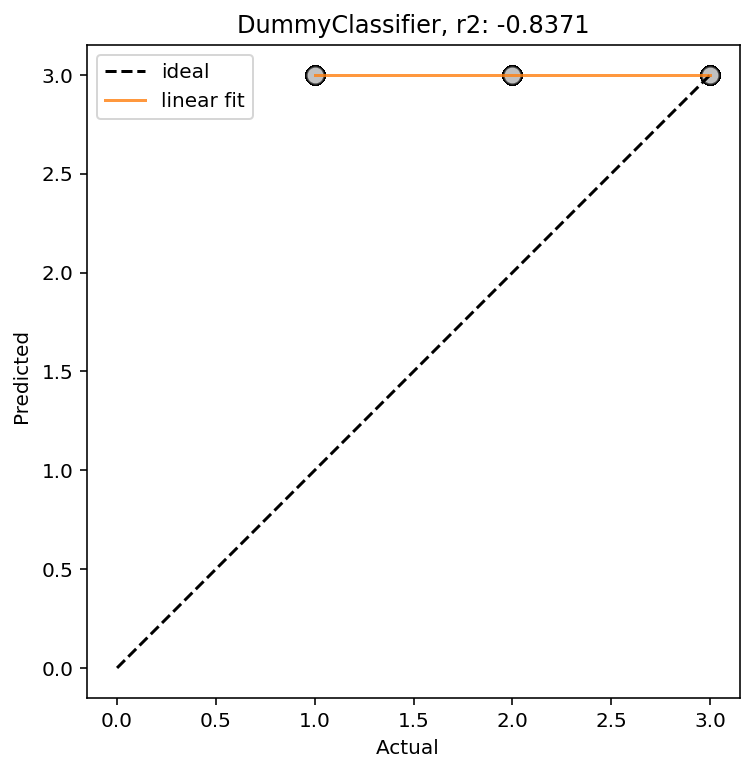

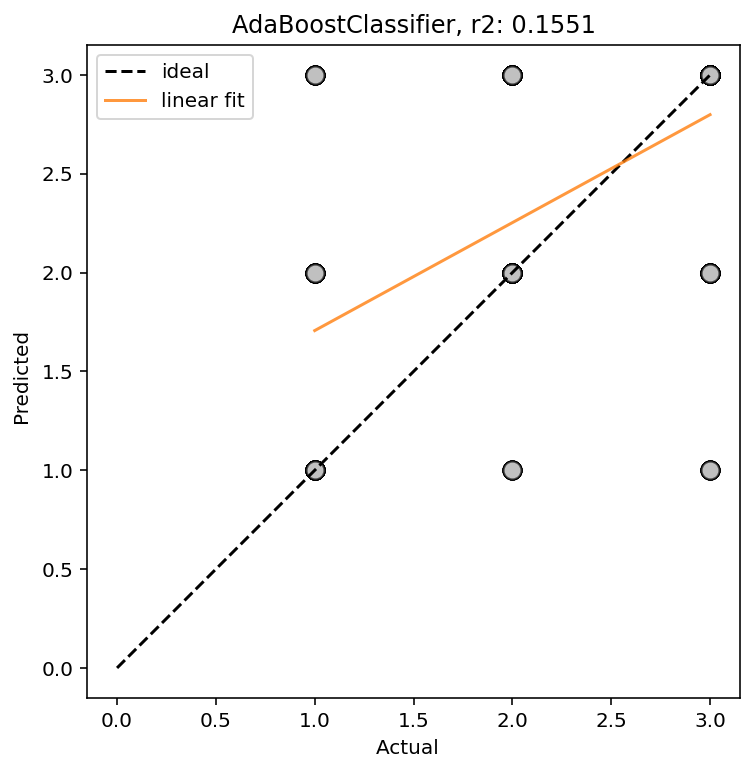

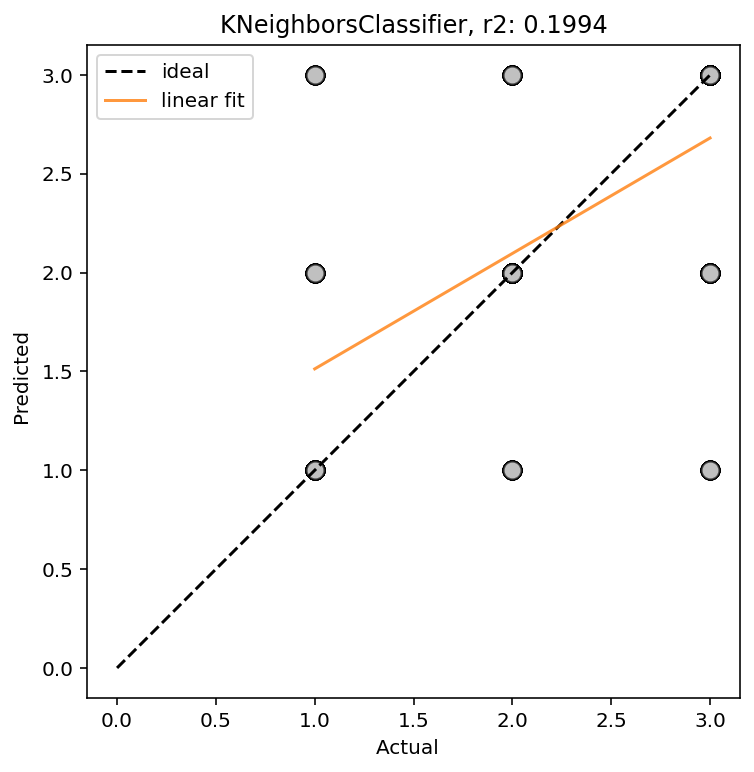

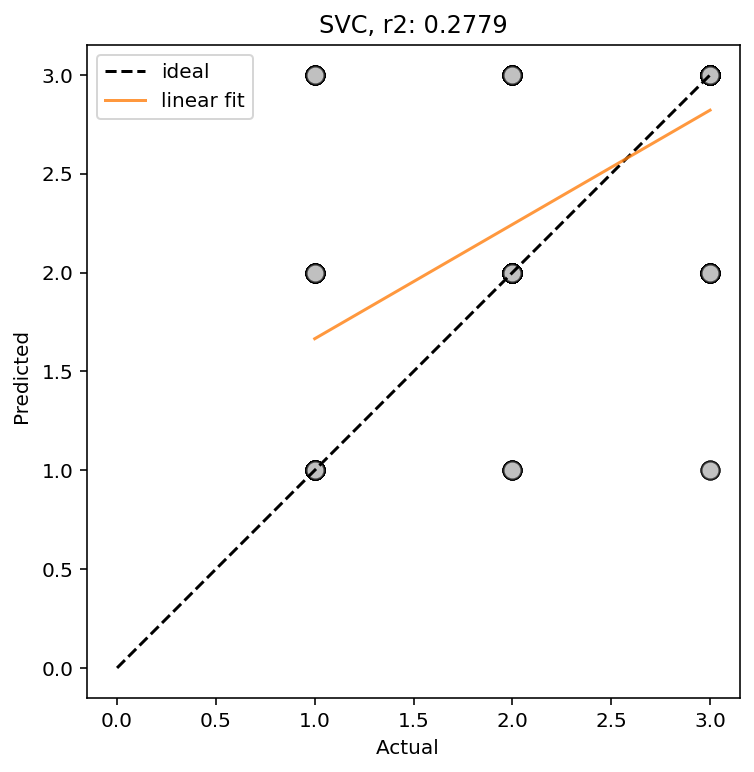

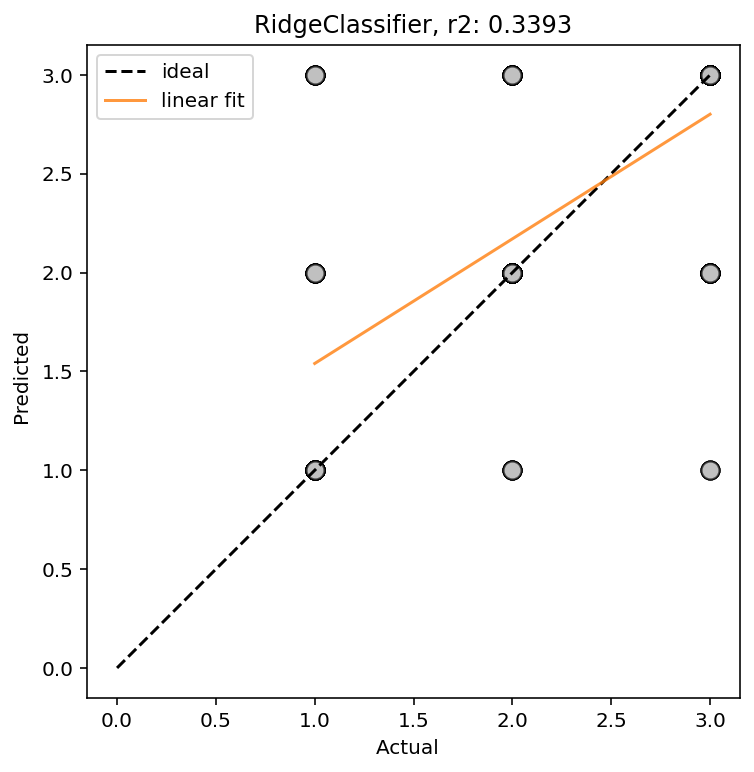

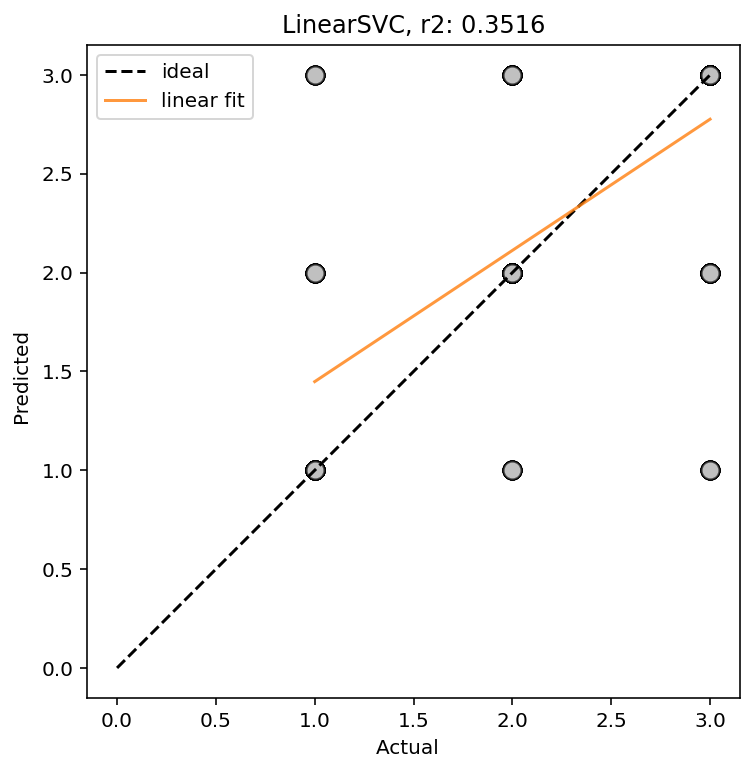

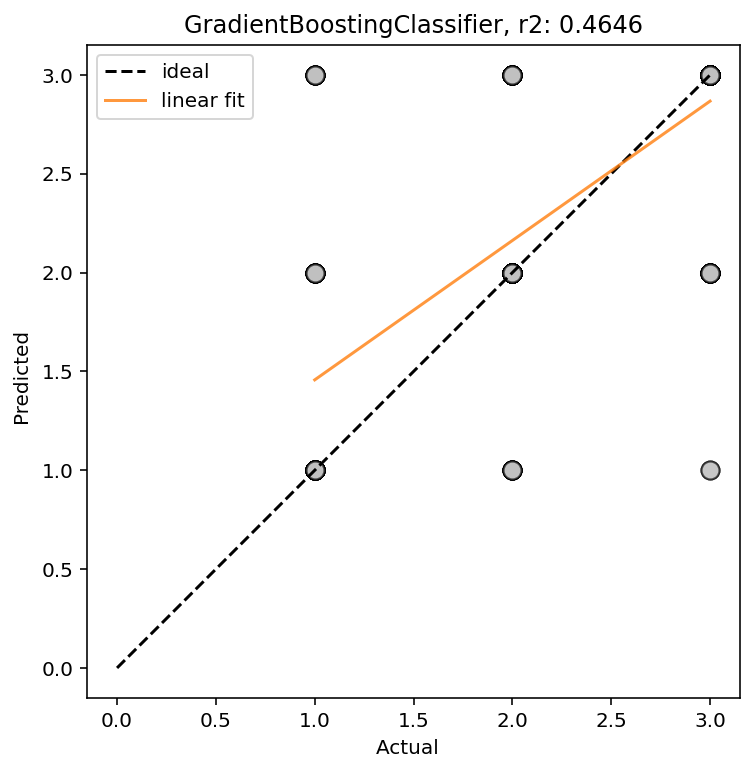

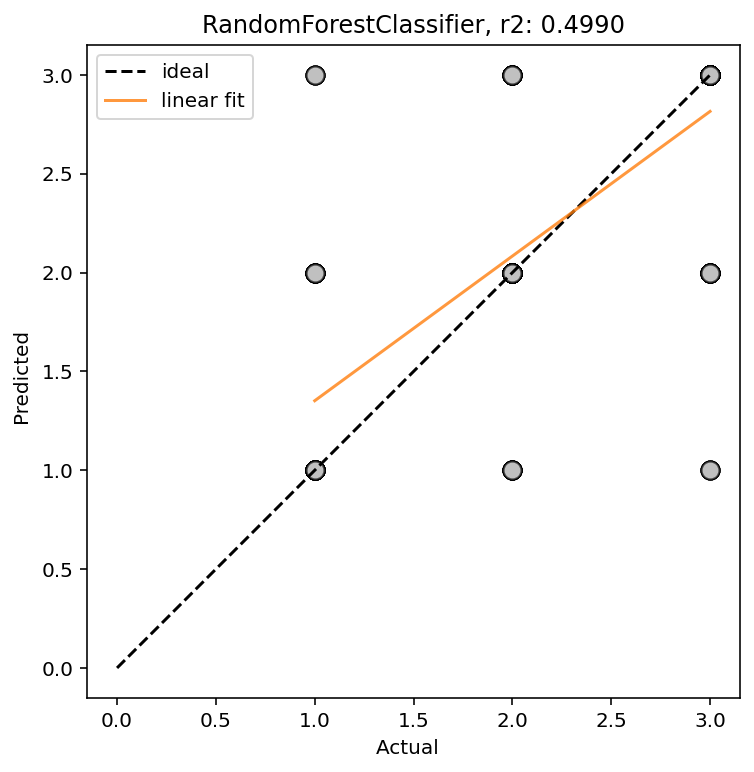

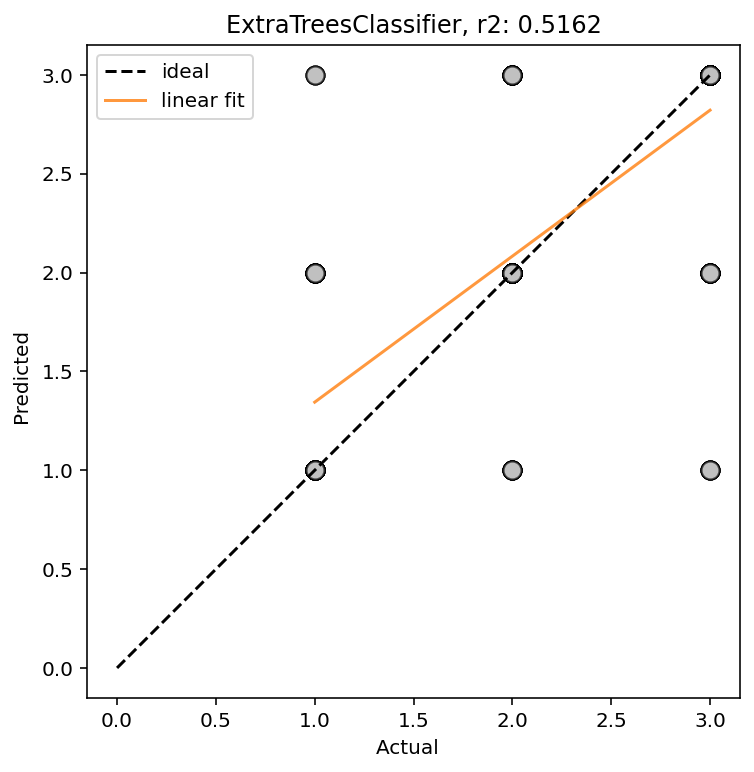

In [38]:
for row in range(df_classics.shape[0]):
    model_name = df_classics.iloc[row]['model_name']

    model = classic_models[model_name]
    y_act_val = y_val
    y_pred_val = model.predict(X_val)

    plot = plot_pred_act(y_act_val, y_pred_val, model, reg_line=True, label=' ')